In [620]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

# test_data = """
# WITH users AS (
#   SELECT distinct
#     entity_id,
#     test_id,
#     variant,
#     SUM(users_count_per_test) users
#   FROM `fulfillment-dwh-production.curated_data_shared.dps_ab_test_dashboard_cvr`
#   WHERE true
#     AND created_date_local >= "2023-01-01"
#     AND _level = 'All'
#     AND treatment = 'All'
#     AND target_group = 'All'
#   GROUP BY entity_id, test_id, variant
# ),
# orders AS (
#   SELECT
#     o.entity_id,
#     o.test_id,
#     o.dps_test_variant variant,
#     c.users users_control,
#     v.users users_variation,
#     sum(o.dps_orders) raw_orders,
#     sum(o.dps_orders * c.users / v.users) orders,    
#     sum(o.fully_loaded_gross_profit_eur_sum * c.users / v.users) flgp_eur,
#     sum(o.fully_loaded_gross_profit_eur_sum) / sum(o.dps_orders) flgpo_eur
#   FROM `fulfillment-dwh-production.curated_data_shared.dps_ab_test_dashboard_orders` o
#   LEFT JOIN users c ON o.entity_id = c.entity_id AND c.test_id = o.test_id AND c.variant = 'Control'
#   LEFT JOIN users v ON o.entity_id = v.entity_id AND v.test_id = o.test_id AND v.variant = o.dps_test_variant
#   WHERE true
#     AND o.created_date_local >= "2023-01-01"
#   GROUP BY o.entity_id, o.test_id, o.dps_test_variant,c.users, v.users
#   ORDER BY o.test_id, o.entity_id
# ),
# stats AS (  
#   SELECT
#     c.entity_id,
#     c.test_id,
#     v.variant variation,
#     c.users_control,
#     v.users_variation,
#     c.raw_orders raw_orders_control,
#     v.raw_orders raw_orders_variation,
#     c.orders orders_control,
#     v.orders orders_variation,
#     c.flgpo_eur flgpo_eur_control,
#     v.flgpo_eur flgpo_eur_variation,
#     c.flgp_eur flgp_eur_control,
#     v.flgp_eur flgp_eur_variation,
#     v.orders - c.orders incremental_orders,
#     v.flgp_eur - c.flgp_eur incremental_profit,
#     (v.orders - c.orders) / NULLIF(c.orders, null) order_change_pct, -- Avoid division by zero
#     (v.flgp_eur - c.flgp_eur) / NULLIF(c.flgp_eur, 0) profit_change_pct, -- Avoid division by zero
#     c.raw_orders / NULLIF(c.users_control, 0) orders_per_user_control, -- Avoid division by zero
#     v.raw_orders / NULLIF(v.users_variation, 0) orders_per_user_variation, -- Avoid division by zero
#     RANK() OVER (PARTITION BY c.entity_id, c.test_id ORDER BY (v.orders - c.orders) / NULLIF(c.orders, 0) DESC) AS order_rank,
#     RANK() OVER (PARTITION BY c.entity_id, c.test_id ORDER BY (v.flgp_eur - c.flgp_eur) / NULLIF(c.flgp_eur, 0) DESC) AS profit_rank,
#     case 
#       when c.orders = v.orders and c.flgpo_eur = v.flgpo_eur
#       then 'Neutral'
#       when c.orders <= v.orders and ((c.flgpo_eur <= v.flgpo_eur) or (c.flgp_eur < v.flgp_eur))
#       then 'Win-Win'
#       when c.orders >= v.orders and c.flgp_eur >= v.flgp_eur
#       then 'Lose-Lose'
#       when c.orders > v.orders and c.flgp_eur < v.flgp_eur
#       then 'MPOL - Profit at a Cost'
#       when c.orders < v.orders and c.flgp_eur > v.flgp_eur
#       then 'CPiO - Growth at a Cost'
#     end scenario  
#   FROM orders c
#   LEFT JOIN orders v ON c.entity_id = v.entity_id AND c.test_id = v.test_id AND v.variant <> 'Control'
#   WHERE c.variant = 'Control'
#     AND c.orders > 0
#     AND v.orders > 0
# ),
# weighted_ranking AS (
#   SELECT
#     *,
#     CASE 
#       WHEN (order_rank = 1 AND profit_rank = 1) or (scenario = 'Win-Win') THEN 0 
#       ELSE (order_rank * 1) + (profit_rank * 2)
#     END AS weighted_rank
#   FROM stats
# ),
# winning_variants AS (
#   SELECT
#     *,
#     ROW_NUMBER() OVER (PARTITION BY s.entity_id, s.test_id ORDER BY s.weighted_rank ASC) AS row_num
#   FROM weighted_ranking s
# ),
# experiments AS (
#   SELECT
#     distinct entity_id,
#     country_code,
#     test_id,
#     test_name,
#     hypothesis,
#     objective,
#     cast(date_trunc(test_start_date, MONTH) as date) start_month,
#     cast(date_trunc(test_start_date, ISOWEEK) as date) start_week,
#     cast(date_trunc(test_end_date, MONTH) as date) end_month,
#     cast(date_trunc(test_end_date, ISOWEEK) as date) end_week,
#     test_start_date,
#     test_end_date,
#     TIMESTAMP_DIFF(IFNULL(test_end_date, CURRENT_TIMESTAMP() - INTERVAL 1 DAY), test_start_date, DAY) test_length,
#     is_active,
#     variation_share,
#     case when test_id = 86 and entity_id = 'PY_SV' then 1 else 0 end check
#   FROM `fulfillment-dwh-production.curated_data_shared.dps_experiment_setups`
#   WHERE NOT misconfigured
#     AND is_already_executed
#     AND experiment_type = 'AB'
#     AND test_start_date >= '2023-01-01'
# )
# SELECT
#   c.region,
#   c.brand_name,
#   c.country_name,
#   e.*,
#   w.* except(entity_id, test_id)
# FROM experiments e
# INNER JOIN winning_variants w ON e.entity_id = w.entity_id AND e.test_id = w.test_id
# left join 
#           (
#             select DISTINCT
#                    p.entity_id,
#                    c.country_name,
#                    c.region,
#                    p.brand_name
#             from `fulfillment-dwh-production.cl.countries` c
#             left join unnest(c.platforms) p
#           ) c on c.entity_id = e.entity_id
# WHERE w.row_num = 1
#       and check = 0
# ORDER BY e.entity_id, e.test_id

# """


# test_data = """
# with users as (
# SELECT DISTINCT
#             entity_id,
#             test_id,
#             variant,
#             count(distinct perseus_client_id) users
#   FROM `fulfillment-dwh-production.curated_data_shared.dps_test_cvr_treatment`
#   WHERE true
#     AND created_date_local >= "2022-01-01" and created_date_local < "2024-11-01"
#     AND entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
#   GROUP BY entity_id, test_id, variant
# ), 
# orders as (
#   SELECT
#     o.entity_id,
#     o.test_id,
#     o.test_variant variant,
#     c.users users_control,
#     v.users users_variation,
#     count(distinct o.platform_order_code) raw_orders,
#     count(distinct o.platform_order_code) * (c.users / v.users) orders,    
#     sum(o.fully_loaded_gross_profit_eur * c.users / v.users) flgp_eur,
#     sum(o.fully_loaded_gross_profit_eur) / count(distinct o.platform_order_code) flgpo_eur
#   FROM `fulfillment-dwh-production.curated_data_shared.dps_test_orders` o
#   LEFT JOIN users c ON o.entity_id = c.entity_id AND c.test_id = o.test_id AND c.variant = 'Control'
#   LEFT JOIN users v ON o.entity_id = v.entity_id AND v.test_id = o.test_id AND v.variant = o.test_variant
#   WHERE true
#     AND o.created_date_local >= "2022-01-01" and o.created_date_local < "2024-11-01"
#     AND o.entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
#   GROUP BY o.entity_id, o.test_id, o.test_variant,c.users, v.users
#   HAVING c.users > 0 AND v.users > 0
#   ORDER BY o.test_id, o.entity_id
# ),  
# stats as (
#   SELECT
#     c.entity_id,
#     c.test_id,
#     v.variant variation,
#     c.users_control,
#     v.users_variation,
#     c.raw_orders raw_orders_control,
#     v.raw_orders raw_orders_variation,
#     c.orders orders_control,
#     v.orders orders_variation,
#     c.flgpo_eur flgpo_eur_control,
#     v.flgpo_eur flgpo_eur_variation,
#     c.flgp_eur flgp_eur_control,
#     v.flgp_eur flgp_eur_variation,
#     c.flgp_eur / c.users_control flgpu_control,
#     v.flgp_eur / v.users_control flgpu_variation,
#     v.orders - c.orders incremental_orders,
#     v.flgp_eur - c.flgp_eur incremental_profit,
#     (v.orders - c.orders) / NULLIF(c.orders, null) order_change_pct, 
#     (v.flgp_eur - c.flgp_eur) / NULLIF(c.flgp_eur, 0) profit_change_pct, 
#     c.raw_orders / NULLIF(c.users_control, 0) orders_per_user_control,
#     v.raw_orders / NULLIF(v.users_variation, 0) orders_per_user_variation, 
#     RANK() OVER (PARTITION BY c.entity_id, c.test_id ORDER BY (v.orders - c.orders) / NULLIF(c.orders, 0) DESC) AS order_rank,
#     RANK() OVER (PARTITION BY c.entity_id, c.test_id ORDER BY (v.flgp_eur - c.flgp_eur) / NULLIF(c.flgp_eur, 0) DESC) AS profit_rank,
#     case 
#       when c.orders = v.orders and c.flgpo_eur = v.flgpo_eur
#       then 'Neutral'
#       when c.orders <= v.orders and ((c.flgpo_eur <= v.flgpo_eur) or (c.flgp_eur < v.flgp_eur))
#       then 'Win-Win'
#       when c.orders >= v.orders and c.flgp_eur >= v.flgp_eur
#       then 'Lose-Lose'
#       when c.orders > v.orders and c.flgp_eur < v.flgp_eur
#       then 'MPOL - Profit at a Cost'
#       when c.orders < v.orders and c.flgp_eur > v.flgp_eur
#       then 'CPiO - Growth at a Cost'
#     end scenario  
#   FROM orders c
#   LEFT JOIN orders v ON c.entity_id = v.entity_id AND c.test_id = v.test_id AND v.variant <> 'Control'
#   WHERE c.variant = 'Control'
#     AND c.orders > 0
#     AND v.orders > 0
# ),
# weighted_ranking AS (
#   SELECT
#     *,
#     CASE 
#       WHEN (order_rank = 1 AND profit_rank = 1) or (scenario = 'Win-Win') THEN 0 
#       ELSE (order_rank * 1) + (profit_rank * 2)
#     END AS weighted_rank
#   FROM stats
# ),
# winning_variants AS (
#   SELECT
#     *,
#     ROW_NUMBER() OVER (PARTITION BY s.entity_id, s.test_id ORDER BY s.weighted_rank ASC) AS row_num
#   FROM weighted_ranking s
# ),
# experiments AS (
#   SELECT
#     distinct entity_id,
#     country_code,
#     test_id,
#     test_name,
#     hypothesis,
#     objective,
#     cast(date_trunc(test_start_date, MONTH) as date) start_month,
#     cast(date_trunc(test_start_date, ISOWEEK) as date) start_week,
#     cast(date_trunc(test_end_date, MONTH) as date) end_month,
#     cast(date_trunc(test_end_date, ISOWEEK) as date) end_week,
#     test_start_date,
#     test_end_date,
#     TIMESTAMP_DIFF(IFNULL(test_end_date, CURRENT_TIMESTAMP() - INTERVAL 1 DAY), test_start_date, DAY) test_length,
#     is_active,
#     variation_share,
#     case when test_id = 86 and entity_id = 'PY_SV' then 1 else 0 end check
#   FROM `fulfillment-dwh-production.curated_data_shared.dps_experiment_setups`
#   WHERE NOT misconfigured
#     AND is_already_executed
#     AND experiment_type = 'AB'
#     AND test_start_date >= '2022-01-01' and test_start_date < "2024-11-01"
#     AND ('restaurant' IN UNNEST(test_vertical_parents) OR 'Restaurant' IN UNNEST(test_vertical_parents) 
#     OR  'restaurants' IN UNNEST(test_vertical_parents))
#     AND test_name NOT LIKE '%FDNC%'
# ) 
# SELECT
#   c.region,
#   c.brand_name,
#   c.country_name,
#   e.*,
#   w.* except(entity_id, test_id)
# FROM experiments e
# INNER JOIN winning_variants w ON e.entity_id = w.entity_id AND e.test_id = w.test_id
# left join 
#           (
#             select DISTINCT
#                    p.entity_id,
#                    c.country_name,
#                    c.region,
#                    p.brand_name
#             from `fulfillment-dwh-production.cl.countries` c
#             left join unnest(c.platforms) p
#           ) c on c.entity_id = e.entity_id
# WHERE w.row_num = 1
#       and check = 0
# ORDER BY e.entity_id, e.test_id

# """

# seasonal = """
# SELECT   o.entity_id
#         ,c.country_name
#         ,c.brand_name
#         ,c.region
#         ,country_code
#         ,EXTRACT(YEAR FROM created_date_local) AS Year
#         ,DATE_TRUNC(created_date_local, MONTH) Month
#         ,sum(fully_loaded_gross_profit_eur) fully_loaded_gross_profit_eur
#         ,count(distinct platform_order_code) total_orders
#         ,count(distinct perseus_client_id) total_active_users
#         ,sum(fully_loaded_gross_profit_eur) / count(distinct perseus_client_id) flgpu_eur
#         ,count(distinct platform_order_code) / count(distinct perseus_client_id) orders_per_user
# FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
# left join 
#           (
#             select DISTINCT
#                    p.entity_id,
#                    c.country_name,
#                    c.region,
#                    p.brand_name
#             from `fulfillment-dwh-production.cl.countries` c
#             left join unnest(c.platforms) p
# ) c on c.entity_id = o.entity_id
# where o.entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'HN_DK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
# AND is_sent = True
# AND created_date_local >= '2023-01-01' 
# group by 1,2,3,4,5,6,7
# """

# seasonal = """
# SELECT   o.entity_id
#         ,EXTRACT(YEAR FROM created_date_local) AS Year
#         ,DATE_TRUNC(created_date_local, MONTH) Month
#         ,sum(fully_loaded_gross_profit_eur) fully_loaded_gross_profit_eur
#         ,count(distinct platform_order_code) total_orders
#         ,count(distinct perseus_client_id) total_active_users
#         ,sum(fully_loaded_gross_profit_eur) / count(distinct perseus_client_id) flgpu_eur
#         ,count(distinct platform_order_code) / count(distinct perseus_client_id) orders_per_user
# FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
# where o.entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'HN_DK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
# AND is_sent = True
# AND created_date_local >= '2023-01-01' 
# group by 1,2,3
# """


test_data = """
with users as (
SELECT DISTINCT
              entity_id,
              test_id,
              variant,
              count(distinct perseus_client_id) users
  FROM `fulfillment-dwh-production.curated_data_shared.dps_test_cvr_treatment`
  WHERE true
    AND created_date >= "2022-01-01" and created_date < "2025-01-01"
    AND entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
  GROUP BY entity_id, test_id, variant
), 
orders as (
  SELECT
    o.entity_id,
    o.test_id,
    o.test_variant variant,
    c.users users_control,
    v.users users_variation,
    count(distinct o.platform_order_code) raw_orders,
    count(distinct o.platform_order_code) * (c.users / v.users) orders,    
    sum(o.fully_loaded_gross_profit_eur * c.users / v.users) flgp_eur,
    sum(o.fully_loaded_gross_profit_eur) / count(distinct o.platform_order_code) flgpo_eur
  FROM `fulfillment-dwh-production.curated_data_shared.dps_test_orders` o
  LEFT JOIN users c ON o.entity_id = c.entity_id AND c.test_id = o.test_id AND c.variant = 'Control'
  LEFT JOIN users v ON o.entity_id = v.entity_id AND v.test_id = o.test_id AND v.variant = o.test_variant
  WHERE true
    AND o.created_date >= "2022-01-01" and o.created_date < "2025-01-01"
    AND o.entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
    AND is_sent = True
    AND is_own_delivery = True
    AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
  GROUP BY o.entity_id, o.test_id, o.test_variant,c.users, v.users
  HAVING c.users > 0 AND v.users > 0
  ORDER BY o.test_id, o.entity_id
),  
stats as (
  SELECT
    c.entity_id,
    c.test_id,
    v.variant variation,
    c.users_control,
    v.users_variation,
    c.raw_orders raw_orders_control,
    v.raw_orders raw_orders_variation,
    c.orders orders_control,
    v.orders orders_variation,
    c.flgpo_eur flgpo_eur_control,
    v.flgpo_eur flgpo_eur_variation,
    c.flgp_eur flgp_eur_control,
    v.flgp_eur flgp_eur_variation,
    c.flgp_eur / c.users_control flgpu_control,
    v.flgp_eur / v.users_control flgpu_variation,
    v.orders - c.orders incremental_orders,
    v.flgp_eur - c.flgp_eur incremental_profit,
    (v.orders - c.orders) / NULLIF(c.orders, null) order_change_pct, 
    (v.flgp_eur - c.flgp_eur) / NULLIF(c.flgp_eur, 0) profit_change_pct, 
    c.raw_orders / NULLIF(c.users_control, 0) orders_per_user_control,
    v.raw_orders / NULLIF(v.users_variation, 0) orders_per_user_variation, 
    RANK() OVER (PARTITION BY c.entity_id, c.test_id ORDER BY (v.orders - c.orders) / NULLIF(c.orders, 0) DESC) AS order_rank,
    RANK() OVER (PARTITION BY c.entity_id, c.test_id ORDER BY (v.flgp_eur - c.flgp_eur) / NULLIF(c.flgp_eur, 0) DESC) AS profit_rank,
    case 
      when c.orders = v.orders and c.flgpo_eur = v.flgpo_eur
      then 'Neutral'
      when c.orders <= v.orders and ((c.flgpo_eur <= v.flgpo_eur) or (c.flgp_eur < v.flgp_eur))
      then 'Win-Win'
      when c.orders >= v.orders and c.flgp_eur >= v.flgp_eur
      then 'Lose-Lose'
      when c.orders > v.orders and c.flgp_eur < v.flgp_eur
      then 'MPOL - Profit at a Cost'
      when c.orders < v.orders and c.flgp_eur > v.flgp_eur
      then 'CPiO - Growth at a Cost'
    end scenario  
  FROM orders c
  LEFT JOIN orders v ON c.entity_id = v.entity_id AND c.test_id = v.test_id AND v.variant <> 'Control'
  WHERE c.variant = 'Control'
    AND c.orders > 0
    AND v.orders > 0
),
winning_variants AS (
  SELECT
    *,
    ROW_NUMBER() OVER (
    PARTITION BY entity_id, test_id 
    ORDER BY 
        CASE WHEN scenario = 'Win-Win' THEN 1 ELSE 2 END, -- Order 'Win-Win' rows first
        order_rank ASC,
        profit_rank ASC
    ) AS final_rank
  FROM stats
),
experiments AS (
  SELECT distinct 
    entity_id,
    country_code,
    test_id,
    test_name,
    hypothesis,
    objective,
    cast(date_trunc(test_start_date, MONTH) as date) start_month,
    cast(date_trunc(test_start_date, ISOWEEK) as date) start_week,
    cast(date_trunc(test_end_date, MONTH) as date) end_month,
    cast(date_trunc(test_end_date, ISOWEEK) as date) end_week,
    test_start_date,
    test_end_date,
    TIMESTAMP_DIFF(IFNULL(test_end_date, CURRENT_TIMESTAMP() - INTERVAL 1 DAY), test_start_date, DAY) test_length,
    is_active,
    variation_share
    --case when test_id = 86 and entity_id = 'PY_SV' then 1 else 0 end check
  FROM `fulfillment-dwh-production.curated_data_shared.dps_experiment_setups`
  WHERE NOT misconfigured
    AND entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
    AND is_already_executed
    AND experiment_type = 'AB'
    AND test_start_date >= '2022-01-01' and test_start_date < "2025-01-01"
    AND ('restaurant' IN UNNEST(test_vertical_parents) OR 'Restaurant' IN UNNEST(test_vertical_parents) 
    OR  'restaurants' IN UNNEST(test_vertical_parents))
    AND test_name NOT LIKE '%FDNC%'
)
SELECT
  c.region,
  c.brand_name,
  c.country_name,
  e.*,
  w.* except(entity_id, test_id),
  w.orders_per_user_variation -  w.orders_per_user_control orders_per_user_incremental,
  w.flgpu_variation -  w.flgpu_control flgp_per_user_incremental
FROM experiments e
INNER JOIN winning_variants w ON e.entity_id = w.entity_id AND e.test_id = w.test_id 
left join 
          (
            select DISTINCT
                    p.entity_id,
                    c.country_name,
                    c.region,
                    p.brand_name
            from `fulfillment-dwh-production.cl.countries` c
            left join unnest(c.platforms) p
          ) c on c.entity_id = e.entity_id
--where check = 0
ORDER BY e.entity_id, e.test_id
"""



seasonal = """
with session as (
SELECT   ss.entity_id
        ,EXTRACT(YEAR FROM created_date) AS Year
        ,DATE_TRUNC(created_date, MONTH) Month
        ,count(distinct sessions.perseus_client_id) total_users
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_ga_sessions` ss
where entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
and created_date >= '2023-01-01' and created_date <= '2023-05-31'
group by 1,2,3
UNION ALL
SELECT   ss.entity_id
        ,EXTRACT(YEAR FROM created_date) AS Year
        ,DATE_TRUNC(created_date, MONTH) Month
        ,count(distinct sessions.perseus_client_id) total_users
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_perseus_sessions` ss
where entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
and created_date >= '2023-06-01' and created_date < '2024-11-01'
group by 1,2,3
), 
orders as (
SELECT   o.entity_id
        ,EXTRACT(YEAR FROM created_date_local) AS Year
        ,DATE_TRUNC(created_date_local, MONTH) Month
        ,sum(fully_loaded_gross_profit_eur) fully_loaded_gross_profit_eur
        ,count(distinct platform_order_code) total_orders
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
where o.entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
AND is_sent = True
AND is_own_delivery = True
AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
AND created_date >= '2022-12-31' and created_date <= '2024-11-01'
AND created_date_local >= '2023-01-01' and created_date_local < '2024-11-01'
group by 1,2,3
)
select   s.entity_id
        ,s.YEAR
        ,s.Month
        ,s.total_users
        ,o.fully_loaded_gross_profit_eur
        ,o.total_orders
        ,fully_loaded_gross_profit_eur / total_users flgpu_eur
        ,total_orders / total_users orders_per_user
from session s
left join orders o on o.entity_id = s.entity_id and o.Month = s.Month
"""

# significance = """
# WITH filtered_data AS (
#     SELECT 
#         country_code,
#         test_name,
#         group_b,
#         max(case when kpi_label = 'orders_per_user' then mean_a else null end) AS orders_per_user_control,
#         max(case when kpi_label = 'orders_per_user' then incremental else null end) AS incremental_orders_per_user,
#         max(case when kpi_label = 'orders_per_user' then significance else null end) AS significance_orders_per_user,
#         max(case when kpi_label = 'orders_per_user' then rn else null end) AS rn_orders_per_user,
#         max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then mean_a else null end) AS profit_per_user,
#         max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then incremental else null end) AS incremental_profit_per_user,
#         max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then significance else null end) AS significance_profit_per_user,
#         max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then rn else null end) AS rn_profit_per_user
#     FROM (
#         SELECT 
#             country_code,
#             test_name,
#             kpi_label,
#             mean_a,
#             group_b,
#             LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) AS min_p_value,
#             CASE 
#                 WHEN LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) <= 0.05 THEN 1 
#                 ELSE 0 
#             END AS significance,
#             (mean_b - mean_a) AS incremental,
#             ROW_NUMBER() OVER (
#                 PARTITION BY test_name, kpi_label
#                 ORDER BY 
#                     CASE 
#                         WHEN LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) <= 0.05 THEN 1 
#                         ELSE 0 
#                     END DESC,
#                     (mean_b - mean_a) DESC
#             ) AS rn
#         FROM 
#             `logistics-data-storage-staging.shared_pricing.dps_ab_test_significance_dataset`
#         WHERE processing_status = 'success'
#             AND group_a = 'Control'
#             AND group_b != 'Control'
#             AND kpi_label IN ('orders_per_user', 'fully_loaded_gross_profit_local_per_user', 'profit_local_per_user')
#             AND label = 'All'
#             AND test_name NOT LIKE '%FDNC%'
#     )
#     GROUP BY country_code, test_name, group_b
# ),
# ranked_data AS (
#     SELECT *,
#         ROW_NUMBER() OVER (
#             PARTITION BY country_code, test_name
#             ORDER BY 
#                 CASE 
#                     WHEN significance_orders_per_user = 1 AND significance_profit_per_user = 1 THEN 1
#                     WHEN significance_orders_per_user = 1 THEN 2
#                     WHEN significance_profit_per_user = 1 THEN 3
#                     ELSE 4
#                 END,
#                 CASE WHEN significance_orders_per_user = 1 THEN incremental_profit_per_user ELSE NULL END DESC,
#                 significance_orders_per_user DESC
#         ) AS rank
#     FROM filtered_data
# )
# SELECT country_code, test_name, group_b, orders_per_user_control, incremental_orders_per_user, significance_orders_per_user,
#        rn_orders_per_user, profit_per_user, incremental_profit_per_user, significance_profit_per_user, rn_profit_per_user
# FROM ranked_data
# WHERE rank = 1;
# """

# significance = """
# WITH filtered_data AS (
#     SELECT 
#         country_code
#         ,test_name
#         ,group_b variation
#         ,max(case when kpi_label = 'orders_per_user' then mean_a else null end) AS orders_per_user_control
#         ,max(case when kpi_label = 'orders_per_user' then incremental else null end) AS incremental_orders_per_user
#         ,max(case when kpi_label = 'orders_per_user' then significance else null end) AS significance_orders_per_user
#         ,max(case when kpi_label = 'orders_per_user' then rn else null end) AS rn_orders_per_user
#         ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then mean_a else null end) AS profit_per_user_control
#         ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then incremental else null end) AS incremental_profit_per_user
#         ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then significance else null end) AS significance_profit_per_user
#         ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then rn else null end) AS rn_profit_per_user
#         ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then mean_a else null end) AS fully_loaded_gross_profit_local_per_user_control
#         ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then incremental else null end) AS incremental_fully_loaded_gross_profit_local_per_user
#         ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then significance else null end) AS significance_fully_loaded_gross_profit_local_per_user
#         ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then rn else null end) AS rn_fully_loaded_gross_profit_local_per_user
#     FROM (
#         SELECT 
#              country_code
#             ,test_name
#             ,kpi_label
#             ,mean_a
#             ,group_b
#             ,LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) AS min_p_value
#             ,CASE 
#                 WHEN LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) <= 0.05 THEN 1 
#                 ELSE 0 
#             END AS significance
#             ,(mean_b - mean_a) AS incremental
#             ,ROW_NUMBER() OVER (
#                 PARTITION BY test_name, kpi_label
#                 ORDER BY 
#                     CASE 
#                         WHEN LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) <= 0.05 THEN 1 
#                         ELSE 0 
#                     END DESC,
#                     (mean_b - mean_a) DESC
#             ) AS rn
#         FROM 
#             `fulfillment-dwh-production.rl.dps_ab_test_significance_dataset_temp`
#         WHERE processing_status = 'success'
#             AND group_a = 'Control'
#             AND group_b != 'Control'
#             AND kpi_label IN ('orders_per_user', 'fully_loaded_gross_profit_local_per_user', 'profit_local_per_user')
#             AND label = 'All'
#             AND test_name NOT LIKE '%FDNC%'
#     )
#     GROUP BY country_code, test_name, group_b
# ),
# ranked_data AS (
#     SELECT *,
#         ROW_NUMBER() OVER (
#             PARTITION BY country_code, test_name
#             ORDER BY 
#                 CASE 
#                     WHEN significance_orders_per_user = 1 AND significance_profit_per_user = 1 THEN 1
#                     WHEN significance_orders_per_user = 1 THEN 2
#                     WHEN significance_profit_per_user = 1 THEN 3
#                     ELSE 4
#                 END ASC,
#                 significance_orders_per_user DESC
#         ) AS rank
#     FROM filtered_data
# )
# SELECT  *
# FROM ranked_data
# --where rank = 1
# """

significance = """
WITH filtered_data AS (
    SELECT 
        country_code
        ,test_name
        ,group_b variation
        ,max(case when kpi_label = 'orders_per_user' then mean_a else null end) AS orders_per_user_control
        ,max(case when kpi_label = 'orders_per_user' then incremental else null end) AS incremental_orders_per_user
        ,max(case when kpi_label = 'orders_per_user' then significance else null end) AS significance_orders_per_user
        ,max(case when kpi_label = 'orders_per_user' then rn else null end) AS rn_orders_per_user
        ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then mean_a else null end) AS profit_per_user_control
        ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then incremental else null end) AS incremental_profit_per_user
        ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then significance else null end) AS significance_profit_per_user
        ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then rn else null end) AS rn_profit_per_user
        ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then mean_a else null end) AS fully_loaded_gross_profit_local_per_user_control
        ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then incremental else null end) AS incremental_fully_loaded_gross_profit_local_per_user
        ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then significance else null end) AS significance_fully_loaded_gross_profit_local_per_user
        ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then rn else null end) AS rn_fully_loaded_gross_profit_local_per_user
    FROM (
        SELECT 
             country_code
            ,test_name
            ,kpi_label
            ,mean_a
            ,group_b
            ,LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) AS min_p_value
            ,CASE 
                WHEN LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) <= 0.05 THEN 1 
                ELSE 0 
            END AS significance
            ,(mean_b - mean_a) AS incremental
            ,ROW_NUMBER() OVER (
                PARTITION BY test_name, kpi_label
                ORDER BY 
                    CASE 
                        WHEN LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) <= 0.05 THEN 1 
                        ELSE 0 
                    END DESC,
                    (mean_b - mean_a) DESC
            ) AS rn
        FROM 
            `fulfillment-dwh-production.rl.dps_ab_test_significance_dataset_temp`
        WHERE processing_status = 'success'
            AND group_a = 'Control'
            AND group_b != 'Control'
            AND kpi_label IN ('orders_per_user', 'fully_loaded_gross_profit_local_per_user', 'profit_local_per_user')
            AND label = 'All'
            AND test_name NOT LIKE '%FDNC%'
    )
    GROUP BY country_code, test_name, group_b
),
ranked_data AS (
    SELECT *,
        ROW_NUMBER() OVER (
        PARTITION BY country_code, test_name
        ORDER BY 
            CASE 
                WHEN significance_orders_per_user = 1 AND significance_profit_per_user = 1 THEN 1
                WHEN significance_orders_per_user = 1 THEN 2
                WHEN significance_profit_per_user = 1 THEN 3
                WHEN incremental_orders_per_user > 0 AND incremental_profit_per_user > 0 THEN 4
                ELSE 5
            END ASC,
            CASE 
                WHEN incremental_orders_per_user > 0 AND incremental_profit_per_user > 0 THEN NULL
                ELSE incremental_orders_per_user
            END DESC,
            significance_orders_per_user DESC
    ) AS rank
    FROM filtered_data
)
SELECT  *
FROM ranked_data
--where rank = 1
"""


hungersta_seasonal = """
with session as (
SELECT   ss.entity_id
        ,EXTRACT(YEAR FROM created_date) AS Year
        ,DATE_TRUNC(created_date, MONTH) Month
        ,count(distinct sessions.perseus_client_id) total_users
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_ga_sessions` ss
where entity_id = 'HS_SA'
and created_date >= '2023-01-01' and created_date <= '2023-05-31'
group by 1,2,3
UNION ALL
SELECT   ss.entity_id
        ,EXTRACT(YEAR FROM created_date) AS Year
        ,DATE_TRUNC(created_date, MONTH) Month
        ,count(distinct sessions.perseus_client_id) total_users
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_perseus_sessions` ss
where entity_id ='HS_SA'
and created_date >= '2023-06-01' and created_date < '2024-11-01'
group by 1,2,3
),
orders as (
select entity_id,
       Year,
       Month,
       adjusted_manual_revenue + (total_revenue - manual_revenue) - total_costs AS Adjusted_Flgp_eur,
       flgp_eur non_adjusted_flgp,
       total_orders
from (
SELECT 
    o.entity_id,
    EXTRACT(YEAR FROM created_date_local) AS Year,
    DATE_TRUNC(created_date_local, MONTH) Month,
    count(distinct o.platform_order_code) total_orders,
    SUM(rdf.OD_delivery_fee / ex.exchange_rate) AS converted_OD_delivery_fee,
    SUM(
        COALESCE((rdf.OD_delivery_fee + 4.7) / ex.exchange_rate, o.delivery_fee_eur)
    ) AS rdf_adjusted_df,
    SUM(o.revenue_eur) AS total_revenue,
    SUM(o.revenue_eur) - SUM(o.delivery_costs_eur) gross_profit_eur,
    SUM(o.revenue_eur) - SUM(o.delivery_costs_eur) - SUM(o.discount_dh_eur) - SUM(o.voucher_dh_eur) AS flgp_manual_eur,
    SUM(o.delivery_costs_eur) + SUM(o.discount_dh_eur) + SUM(o.voucher_dh_eur) total_costs,
    SUM(o.fully_loaded_gross_profit_eur) AS flgp_eur,
    (
        SUM(o.joker_vendor_fee_eur)
        + SUM(commission_eur)
        + SUM(o.priority_fee_eur * (1 - o.vat_rate))
        + SUM(o.service_fee_eur * (1 - o.vat_rate))
        + SUM(o.mov_customer_fee_eur * (1 - o.vat_rate))
        + SUM(o.front_margin_eur)
        + SUM(o.delivery_fee_eur * (1 - o.vat_rate))
    ) AS manual_revenue,
    (
        SUM(o.joker_vendor_fee_eur)
        + SUM(commission_eur)
        + SUM(o.priority_fee_eur * (1 - o.vat_rate))
        + SUM(o.service_fee_eur * (1 - o.vat_rate))
        + SUM(o.mov_customer_fee_eur * (1 - o.vat_rate))
        + SUM(o.front_margin_eur)
        + SUM(
        COALESCE((rdf.OD_delivery_fee + 4.7) / ex.exchange_rate, o.delivery_fee_eur)
         * (1 - o.vat_rate))
    ) AS adjusted_manual_revenue
--     o.created_date,
--     o.platform_order_code,
--     o.delivery_fee_eur,
--     rdf.OD_delivery_fee,
--     ex.exchange_rate,
--     o.vat_rate
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
left JOIN `logistics-data-storage-staging.long_term_pricing.hs_sa_rdf_orders` rdf ON CAST(rdf.platform_order_code AS STRING) = o.platform_order_code
LEFT JOIN (
    SELECT 
        date,
        currency_code, 
        max(exchange_rate) exchange_rate
    FROM 
        `fulfillment-dwh-production.cl._currency_exchange`
    WHERE 
        country_code = 'sa' 
    GROUP BY 1,2
) ex ON ex.currency_code = o.currency_code and ex.date = o.created_date
WHERE o.entity_id = 'HS_SA'
      AND is_sent = True
      AND is_own_delivery = True
      AND (vendor_vertical_parent in ('Restaurant','restaurant','restaurants','Restaurants')) or vendor_vertical_parent is null
      AND created_date >= '2022-12-31' and created_date < '2024-11-02'
      AND created_date_local >= '2023-01-01' and created_date_local < '2024-11-01'
group by 1,2,3
))
select   s.entity_id
        ,s.YEAR
        ,s.Month
        ,s.total_users
        ,o.Adjusted_Flgp_eur fully_loaded_gross_profit_eur
        ,o.total_orders
        ,o.Adjusted_Flgp_eur / s.total_users flgpu_eur
        ,o.total_orders / s.total_users orders_per_user
from session s
left join orders o on o.entity_id = s.entity_id and o.Month = s.Month
"""

hungersta_seasonal = """
with session as (
SELECT   ss.entity_id
        ,EXTRACT(YEAR FROM created_date) AS Year
        ,DATE_TRUNC(created_date, MONTH) Month
        ,count(distinct sessions.perseus_client_id) total_users
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_ga_sessions` ss
where entity_id = 'HS_SA'
and created_date >= '2023-01-01' and created_date <= '2023-05-31'
group by 1,2,3
UNION ALL
SELECT   ss.entity_id
        ,EXTRACT(YEAR FROM created_date) AS Year
        ,DATE_TRUNC(created_date, MONTH) Month
        ,count(distinct sessions.perseus_client_id) total_users
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_perseus_sessions` ss
where entity_id ='HS_SA'
and created_date >= '2023-06-01' and created_date < '2024-11-01'
group by 1,2,3
),
orders as (
select entity_id,
       Year,
       Month,
       adjusted_manual_revenue + (total_revenue - manual_revenue) - total_costs AS Adjusted_Flgp_eur,
       flgp_eur non_adjusted_flgp,
       total_orders
from (
SELECT 
    o.entity_id,
    EXTRACT(YEAR FROM created_date_local) AS Year,
    DATE_TRUNC(created_date_local, MONTH) Month,
    count(distinct o.platform_order_code) total_orders,
    SUM(rdf.OD_delivery_fee / ex.exchange_rate) AS converted_OD_delivery_fee,
    SUM(
        COALESCE((rdf.OD_delivery_fee + 4.7) / ex.exchange_rate, o.delivery_fee_eur)
    ) AS rdf_adjusted_df,
    SUM(o.revenue_eur) AS total_revenue,
    SUM(o.revenue_eur) - SUM(o.delivery_costs_eur) gross_profit_eur,
    SUM(o.revenue_eur) - SUM(o.delivery_costs_eur) - SUM(o.discount_dh_eur) - SUM(o.voucher_dh_eur) AS flgp_manual_eur,
    SUM(o.delivery_costs_eur) + SUM(o.discount_dh_eur) + SUM(o.voucher_dh_eur) total_costs,
    SUM(o.fully_loaded_gross_profit_eur) AS flgp_eur,
    (
        SUM(o.joker_vendor_fee_eur)
        + SUM(commission_eur)
        + SUM(o.priority_fee_eur * (1 - o.vat_rate))
        + SUM(o.service_fee_eur * (1 - o.vat_rate))
        + SUM(o.mov_customer_fee_eur * (1 - o.vat_rate))
        + SUM(o.front_margin_eur)
        + SUM(o.delivery_fee_eur * (1 - o.vat_rate))
    ) AS manual_revenue,
    (
        SUM(o.joker_vendor_fee_eur)
        + SUM(commission_eur)
        + SUM(o.priority_fee_eur * (1 - o.vat_rate))
        + SUM(o.service_fee_eur * (1 - o.vat_rate))
        + SUM(o.mov_customer_fee_eur * (1 - o.vat_rate))
        + SUM(o.front_margin_eur)
        + SUM(
        COALESCE((rdf.OD_delivery_fee + 4.7) / ex.exchange_rate, o.delivery_fee_eur)
         * (1 - o.vat_rate))
    ) AS adjusted_manual_revenue
--     o.created_date,
--     o.platform_order_code,
--     o.delivery_fee_eur,
--     rdf.OD_delivery_fee,
--     ex.exchange_rate,
--     o.vat_rate
FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
left JOIN `logistics-data-storage-staging.long_term_pricing.hs_sa_rdf_orders` rdf ON CAST(rdf.platform_order_code AS STRING) = o.platform_order_code
LEFT JOIN (
    SELECT 
        date,
        currency_code, 
        max(exchange_rate) exchange_rate
    FROM 
        `fulfillment-dwh-production.cl._currency_exchange`
    WHERE 
        country_code = 'sa' 
    GROUP BY 1,2
) ex ON ex.currency_code = o.currency_code and ex.date = o.created_date
WHERE o.entity_id = 'HS_SA'
      AND is_sent = True
      AND is_own_delivery = True
      AND created_date >= '2022-12-31' and created_date < '2024-11-02'
      AND created_date_local >= '2023-01-01' and created_date_local < '2024-11-01'
      AND vendor_id in (
                select distinct vendor_id
                from (
                SELECT 
                    vendor_id,
                    COALESCE(
                    FIRST_VALUE(vendor_vertical_parent IGNORE NULLS) OVER (
                        PARTITION BY vendor_id
                        ORDER BY created_date DESC
                    ),
                    FIRST_VALUE(vertical_type IGNORE NULLS) OVER (
                        PARTITION BY vendor_id
                        ORDER BY created_date DESC
                    )
                ) AS selected_vertical
            FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders`
            WHERE entity_id = 'HS_SA'
            QUALIFY ROW_NUMBER() OVER (PARTITION BY vendor_id ORDER BY created_date DESC) = 1
            )
            where selected_vertical in('Restaurant','restaurant','restaurants','Restaurants')
) 
group by 1,2,3
))
select   s.entity_id
        ,s.YEAR
        ,s.Month
        ,s.total_users
        ,o.non_adjusted_flgp fully_loaded_gross_profit_eur
        ,o.total_orders
        ,o.non_adjusted_flgp / s.total_users flgpu_eur
        ,o.total_orders / s.total_users orders_per_user
from session s
left join orders o on o.entity_id = s.entity_id and o.Month = s.Month
"""


def combine_seasonal():
    # Fetch dataframes from queries
    tmp = client.query(seasonal).to_dataframe()
    tmp2 = client.query(hungersta_seasonal).to_dataframe()

    # Concatenate dataframes
    combined_df = pd.concat([tmp, tmp2], ignore_index=True)  # ignore_index=True to reset the index

    return combined_df


def filter_merged_df(df1, df2):
    
    df2['incremental_orders_per_user_sig'] = df2['incremental_orders_per_user']
    df2['orders_per_user_control_sig'] = df2['orders_per_user_control']

    # Merge the dataframes
    tmp = df2[['country_code', 'test_name', 'variation', 'rank','orders_per_user_control_sig', 'incremental_orders_per_user_sig',
                           'significance_profit_per_user', 'significance_orders_per_user']]
    merged_df = pd.merge(df1, tmp, on=['country_code', 'test_name', 'variation'], how='left')

    # Define a condition to check if 'rank' column has non-null values in each group
    merged_df['use_rank'] = merged_df.groupby(['country_name', 'test_name'])['rank'].transform(lambda x: x.notna().any())

    # Filter the dataframe based on the condition
    merged_df_filtered = merged_df[
        ((merged_df['use_rank']) & (merged_df['rank'] == 1)) |
        ((~merged_df['use_rank']) & (merged_df['final_rank'] == 1))
    ]

    # Drop the helper column
    merged_df_filtered = merged_df_filtered.drop(columns=['use_rank'])
    
    return merged_df_filtered


In [1361]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

test_df = client.query(test_data).to_dataframe()
seasonal_df = combine_seasonal()
significance_df = client.query(significance).to_dataframe()

In [3005]:
test_df_sig = filter_merged_df(test_df, significance_df)

In [3006]:
#data filter
# filtered_df = test_df_sig.groupby('country_name').apply(
#     lambda group: group[np.abs((group['flgp_per_user_incremental'] - group['flgp_per_user_incremental'].mean()) /
#                                group['flgp_per_user_incremental'].std()) < 3]
# ).reset_index(drop=True)

# filtered_df = test_df_sig.groupby('country_name').apply(
#     lambda group: group[
#         np.abs(
#             (group['flgp_per_user_incremental'] / group['flgpu_control'] - 
#              (group['flgp_per_user_incremental'] / group['flgpu_control']).mean()) / 
#             (group['flgp_per_user_incremental'] / group['flgpu_control']).std()
#         ) < 3
#     ]
# ).reset_index(drop=True)

#filtered_df = filtered_df[(filtered_df['flgp_per_user_incremental'] / filtered_df['flgpu_control']) <= 1]

filtered_df = test_df_sig.copy()

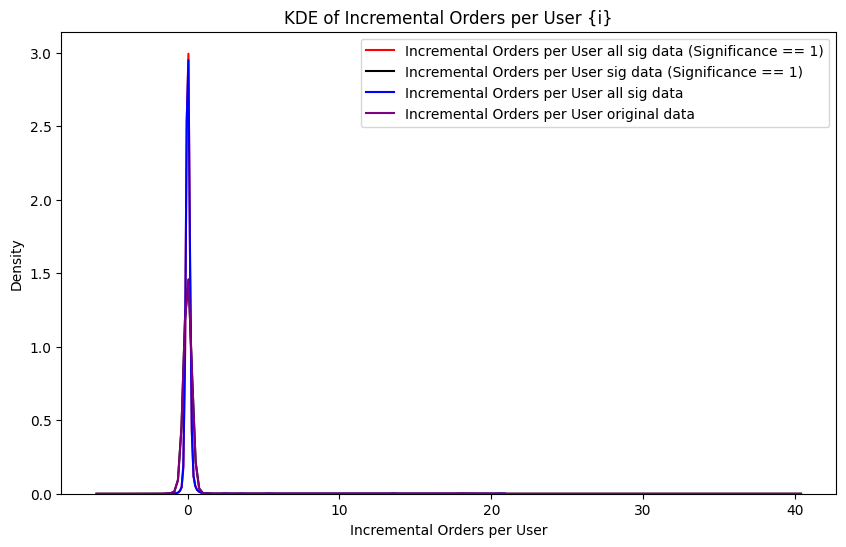

all_data_significance: count    2357.000000
mean        0.041653
std         0.536670
min        -1.071432
25%        -0.006507
50%         0.007152
75%         0.032387
max        20.567399
Name: orders_per_user_incremental, dtype: float64, all_data: count    2357.000000
mean        0.040370
std         1.138207
min        -5.288216
25%        -0.051540
50%         0.002031
75%         0.041694
max        39.689018
Name: flgp_per_user_incremental, dtype: float64, significance_data: count    2357.000000
mean        0.038324
std         0.537191
min        -1.071432
25%        -0.009666
50%         0.005576
75%         0.031506
max        20.567399
Name: orders_per_user_incremental, dtype: float64,ordiginal_data: count    2357.000000
mean        0.042153
std         1.138255
min        -5.288216
25%        -0.050252
50%         0.003181
75%         0.045360
max        39.689018
Name: flgp_per_user_incremental, dtype: float64 


In [3007]:
# Extract values for a, b, c, d after cleaning
s_a = test_df[test_df['final_rank'] == 1]['orders_per_user_incremental']
s_b = test_df[test_df['final_rank'] == 1]['flgp_per_user_incremental']
s_c = filtered_df['orders_per_user_incremental']
s_d = filtered_df['flgp_per_user_incremental']

plt.figure(figsize=(10, 6))

sns.kdeplot(s_a, 
            label='Incremental Orders per User all sig data (Significance == 1)', color='red')

sns.kdeplot(s_b, 
            label='Incremental Orders per User sig data (Significance == 1)', color='black')

sns.kdeplot(s_c, 
            label='Incremental Orders per User all sig data', color='blue')

sns.kdeplot(s_d, 
            label='Incremental Orders per User original data', color='purple')

# Adding labels and legend
plt.xlabel('Incremental Orders per User')
plt.ylabel('Density')
plt.legend()
plt.title('KDE of Incremental Orders per User {i}')

# Show the plot
plt.show()

# Print descriptive statistics
print(f"all_data_significance: {s_a.describe()}, all_data: {s_b.describe()}, significance_data: {s_c.describe()},ordiginal_data: {s_d.describe()} ")
#significance_stats_all, test_flgp_stats

In [3008]:
from scipy.stats import boxcox
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

lst_m1  = []
lst_m2  = []
lst_m3  = []
lst_m4  = []

# Assuming test_df_sig is a defined DataFrame
countries = test_df_sig['country_name'].unique()

for i in countries:
    # Filter data for the current country
    df = test_df_sig[test_df_sig['country_name'] == i]
    s_a = df['flgp_per_user_incremental']
    
    # Original KDE plot
    #plt.figure(figsize=(10, 6))
    #sns.kdeplot(s_a, label='Original', color='red')
    avg_value = np.mean(s_a)
    median_value = np.median(s_a)
    lst_m1.append(avg_value)
    # plt.axvline(avg_value, color='blue', linestyle='--', label=f'Average: {avg_value:.5f}')
    # plt.axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.5f}')
    # plt.text(avg_value, plt.ylim()[1] * 0.8, f'Avg: {avg_value:.5f}', color='blue', fontsize=10, ha='center')
    # plt.text(median_value, plt.ylim()[1] * 0.6, f'Med: {median_value:.5f}', color='green', fontsize=10, ha='center')
    # plt.title(f'Original KDE - {i}')
    # plt.xlabel('FLGP per User')
    # plt.ylabel('Density')
    # plt.legend()
    # plt.show()
    
    # 1. Transformation (Box-Cox)
    if (s_a > 0).all():  # Box-Cox requires positive values
        s_a_boxcox, _ = boxcox(s_a)
        #plt.figure(figsize=(10, 6))
        #sns.kdeplot(s_a_boxcox, label='Box-Cox Transformed', color='green')
        avg_value = np.mean(s_a_boxcox)
        median_value = np.median(s_a_boxcox)
        lst_m2.append(avg_value)
        # plt.axvline(avg_value, color='blue', linestyle='--', label=f'Average: {avg_value:.5f}')
        # plt.axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.5f}')
        # plt.text(avg_value, plt.ylim()[1] * 0.8, f'Avg: {avg_value:.5f}', color='blue', fontsize=10, ha='center')
        # plt.text(median_value, plt.ylim()[1] * 0.6, f'Med: {median_value:.5f}', color='green', fontsize=10, ha='center')
        # plt.title(f'Box-Cox Transformed KDE - {i}')
        # plt.xlabel('Transformed FLGP per User')
        # plt.ylabel('Density')
        # plt.legend()
        # plt.show()

    # 2. Removing Outliers (Z-score)
    z_scores = np.abs((s_a - np.mean(s_a)) / np.std(s_a))
    s_a_filtered = s_a[z_scores < 3]
    #plt.figure(figsize=(10, 6))
    #sns.kdeplot(s_a_filtered, label='Outliers Removed (Z-Score)', color='orange')
    avg_value = np.mean(s_a_filtered)
    median_value = np.median(s_a_filtered)
    lst_m3.append(avg_value)
    # plt.axvline(avg_value, color='blue', linestyle='--', label=f'Average: {avg_value:.5f}')
    # plt.axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.5f}')
    # plt.text(avg_value, plt.ylim()[1] * 0.8, f'Avg: {avg_value:.5f}', color='blue', fontsize=10, ha='center')
    # plt.text(median_value, plt.ylim()[1] * 0.6, f'Med: {median_value:.5f}', color='green', fontsize=10, ha='center')
    # plt.title(f'Outliers Removed KDE - {i}')
    # plt.xlabel('FLGP per User')
    # plt.ylabel('Density')
    # plt.legend()
    # plt.show()
    
    # 3. Clipping Extreme Values
    lower_bound, upper_bound = np.percentile(s_a, [5, 95])
    s_a_clipped = np.clip(s_a, lower_bound, upper_bound)
    #plt.figure(figsize=(10, 6))
    #sns.kdeplot(s_a_clipped, label='Clipped Values', color='purple')
    avg_value = np.mean(s_a_clipped)
    median_value = np.median(s_a_clipped)
    lst_m4.append(avg_value)
    # plt.axvline(avg_value, color='blue', linestyle='--', label=f'Average: {avg_value:.5f}')
    # plt.axvline(median_value, color='green', linestyle='--', label=f'Median: {median_value:.5f}')
    # plt.text(avg_value, plt.ylim()[1] * 0.8, f'Avg: {avg_value:.5f}', color='blue', fontsize=10, ha='center')
    # plt.text(median_value, plt.ylim()[1] * 0.6, f'Med: {median_value:.5f}', color='green', fontsize=10, ha='center')
    # plt.title(f'Clipped KDE - {i}')
    # plt.xlabel('FLGP per User')
    # plt.ylabel('Density')
    # plt.legend()
    # plt.show()


In [3009]:
# significance opu == 1 significance data
# significance opu == 1 significane all data
# opu custom selected variant data
# opu final_rank == 1 data

In [3010]:
# def create_change_columns(all_data, all_sig_data, sig_data):

#     all_data['perc_change_opu'] = all_data['orders_per_user_incremental'] / all_data['orders_per_user_control']
#     all_data['perc_change_flgpu'] = all_data['flgp_per_user_incremental'] / all_data['flgpu_control']

#     all_sig_data['perc_change_opu_sig_all'] = all_sig_data['orders_per_user_incremental'] / all_sig_data['orders_per_user_control']
#     all_sig_data['perc_change_flgpu_sig_all'] = all_sig_data['flgp_per_user_incremental'] / all_sig_data['flgpu_control']

#     sig_data['per_change_sig_opu'] = test_df_sig['incremental_orders_per_user_sig'] / test_df_sig['orders_per_user_control_sig']

#     return all_data, all_sig_data, sig_data


# def remove_outliers(df, column, group_column='country_code'):
    
#     def filter_outliers_iq(group):
#         q1 = group[column].quantile(0.05)
#         q3 = group[column].quantile(0.95)
#         iqr = q3 - q1
#         lower_bound = q1 - 1.5 * iqr
#         upper_bound = q3 + 1.5 * iqr
        
#         return group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]

#     def filter_outliers_percentile(group):
#         q1 = group[column].quantile(0.05)
#         q3 = group[column].quantile(0.95)
    
#         return group[(group[column] >= q1) & (group[column] <= q3)]
    
#     return df.groupby(group_column, group_keys=False).apply(filter_outliers_percentile)


# # Apply outlier removal for each column
# # test_df_sig = remove_outliers(test_df_sig, 'perc_change')
# # test_df_sig = remove_outliers(test_df_sig, 'per_change_sig')
# # test_df = remove_outliers(test_df, 'per_change_og')

# def scenarios_impact(all_data, all_sig_data, sig_data):

#     # Extract values for a, b, c, d after cleaning
#     s_a = all_sig_data[all_sig_data['significance_orders_per_user'] == 1]['perc_change_opu_sig_all']
#     s_b = sig_data[sig_data['significance_orders_per_user'] == 1]['per_change_sig_opu']
#     s_c = all_sig_data['perc_change_opu_sig_all']
#     s_d = all_data[all_data['final_rank'] == 1]['perc_change_opu']

#     plt.figure(figsize=(10, 6))

#     sns.kdeplot(s_a, 
#                 label='Incremental Orders per User all sig data (Significance == 1)', color='red')

#     sns.kdeplot(s_b, 
#                 label='Incremental Orders per User sig data (Significance == 1)', color='black')

#     sns.kdeplot(s_c, 
#                 label='Incremental Orders per User all sig data', color='blue')

#     sns.kdeplot(d, 
#                 label='Incremental Orders per User original data', color='purple')

#     # Adding labels and legend
#     plt.xlabel('Incremental Orders per User')
#     plt.ylabel('Density')
#     plt.legend()
#     plt.title('KDE of Incremental Orders per User {i}')

#     # Show the plot
#     plt.show()

#     # Print descriptive statistics
#     print(f"all_data_significance: {s_a.describe()}, all_data: {s_b.describe()}, significance_data: {s_c.describe()},ordiginal_data: {s_d.describe()} ")
#     #significance_stats_all, test_flgp_stats


# all_data = test_df.copy()
# all_sig_data = test_df_sig.copy()
# sig_data = significance_df.copy()

# all_data, all_sig_data, sig_data = create_change_columns(all_data, all_sig_data, sig_data)

# all_data = remove_outliers(all_data, 'perc_change_opu')
# all_sig_data = remove_outliers(all_sig_data, 'perc_change_opu_sig_all')
# sig_data = remove_outliers(sig_data, 'per_change_sig_opu')

# scenarios_impact(all_data, all_sig_data, sig_data)


In [3011]:
## significance vs non-significant data check impact

def create_change_columns(all_data, all_sig_data, sig_data):

    all_data['perc_change_opu'] = all_data['orders_per_user_incremental'] / all_data['orders_per_user_control']
    all_data['perc_change_flgpu'] = all_data['flgp_per_user_incremental'] / all_data['flgpu_control']

    all_sig_data['perc_change_opu_sig_all'] = all_sig_data['orders_per_user_incremental'] / all_sig_data['orders_per_user_control']
    all_sig_data['perc_change_flgpu_sig_all'] = all_sig_data['flgp_per_user_incremental'] / all_sig_data['flgpu_control']

    sig_data['per_change_sig_opu'] = test_df_sig['incremental_orders_per_user_sig'] / test_df_sig['orders_per_user_control_sig']

    return all_data, all_sig_data, sig_data


def remove_outliers(df, column, group_column='country_code'):
    
    def filter_outliers_iq(group):
        q1 = group[column].quantile(0.04)
        q3 = group[column].quantile(0.96)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        return group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]

    def filter_outliers_percentile(group):
        q1 = group[column].quantile(0.01)
        q3 = group[column].quantile(0.99)
    
        return group[(group[column] >= q1) & (group[column] <= q3)]
    
    return df.groupby(group_column, group_keys=False).apply(filter_outliers_percentile)


all_data = test_df.copy()
all_sig_data = filtered_df.copy()
sig_data = significance_df.copy()

all_data, all_sig_data, sig_data = create_change_columns(all_data, all_sig_data, sig_data)

# all_data = remove_outliers(all_data, 'perc_change_opu')
# all_sig_data = remove_outliers(all_sig_data, 'perc_change_opu_sig_all')
# sig_data = remove_outliers(sig_data, 'per_change_sig_opu')

all_data = remove_outliers(all_data, 'perc_change_flgpu')
all_sig_data = remove_outliers(all_sig_data, 'perc_change_flgpu_sig_all')
#sig_data = remove_outliers(sig_data, 'per_change_sig_opu')


def calculate_sig_difference(
    base_control, oppc, oppc2, avg_total_active_users, total_exponent, increment
):  

    # Calculate number of steps for incremental application
    num_steps = int(total_exponent / increment) + 1

    # Generate exponents
    exponents = [i * increment for i in range(num_steps)]

    # Calculate results for OPPC and OPPC2
    results_oppc = [base_control * (oppc ** exp) * avg_total_active_users for exp in exponents]
    results_oppc2 = [base_control * (oppc2 ** exp) * avg_total_active_users for exp in exponents]

    # Get the first and last values for both OPPC and OPPC2 results
    first_value_oppc = results_oppc[0]
    last_value_oppc = results_oppc[-1]
    first_value_oppc2 = results_oppc2[0]
    last_value_oppc2 = results_oppc2[-1]

    return (last_value_oppc - first_value_oppc) - (last_value_oppc2 - first_value_oppc2)


def sig_diff_summary(df, agg): 

    lst = [] 
    summation = 0

    if agg == 'profit':
        
        df = remove_outliers(df, 'perc_change_flgpu_sig_all') 
        significance = 'significance_profit_per_user'
        metric = 'perc_change_flgpu_sig_all'
        base = 'flgpu_control'

    elif agg == 'orders':

        df = remove_outliers(df, 'perc_change_opu_sig_all')
        significance = 'significance_orders_per_user'
        metric = 'perc_change_opu_sig_all'
        base = 'orders_per_user_control'


    for i in df['country_name'].unique():
        
        tmp = df[df['country_name'] == i]
        sig_average = tmp[tmp[significance] == 1][metric].mean()
        all_average = tmp[metric].mean()
        avg_control = tmp[base].mean()
            
        total_users = tmp['users_control'] + tmp['users_variation']

        # Test the function with given parameters
        oppc = (1 + sig_average)
        oppc2 = (1 + all_average)
        avg_total_active_users = total_users.mean()
        total_exponent = 4
        increment = 1

        result = calculate_sig_difference(
            avg_control, oppc, oppc2, avg_total_active_users, total_exponent, increment
        )
        
        if result is not None and not pd.isna(result):  # Use pandas to check for missing values
            lst.append((i, result))
            summation += result

    return lst, summation


def create_cumulative_difference_chart(cumulative_differences, total_sum, color):
   
    # Prepare data for the bar chart
    countries = [item[0] for item in cumulative_differences]
    differences = [item[1] for item in cumulative_differences]

    # Example DataFrame
    chart_data = pd.DataFrame({
        'Country': countries,
        'Cumulative Difference': differences
    })

    # Create the bar chart
    fig = px.bar(
        chart_data,
        x="Cumulative Difference",
        y="Country",
        orientation='h',
        title="Cumulative Differences Between Significant and Significant + Non-significant Data by Country",
        labels={"Cumulative Difference": "Cumulative Difference", "Country": "Country Code"},
        color="Cumulative Difference",
        color_continuous_scale= color
    )

    # Update layout for better readability and increased height
    fig.update_layout(
        xaxis_title="Cumulative Difference",
        yaxis_title="Country Name",
        coloraxis_showscale=True,
        template="plotly_white",
        margin=dict(l=80, r=20, t=100, b=40),  # Increased top margin for annotation
        height=800  # Increased height
    )

    # Add the annotation at the top
    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.5, y=1.15,  # Position above the chart
        text=f"Total Sum of Differences: {total_sum:.2f}",
        showarrow=False,
        font=dict(size=14, color="black"),
        align="center"
    )

    fig.show()

cumulative_differences_orders, total_sum_orders = sig_diff_summary(all_sig_data, 'orders')
create_cumulative_difference_chart(cumulative_differences_orders, total_sum_orders, 'Reds')

cumulative_differences_profit, total_sum_profit = sig_diff_summary(all_sig_data, 'profit')
create_cumulative_difference_chart(cumulative_differences_profit, total_sum_profit, 'Blues')


# # Prepare data for the bar chart
# countries = [item[0] for item in cumulative_differences]
# differences = [item[1] for item in cumulative_differences]

# # Example DataFrame
# chart_data = pd.DataFrame({
#     'Country': countries,
#     'Cumulative Difference': differences
# })

# # Create the bar chart
# fig = px.bar(
#     chart_data,
#     x="Cumulative Difference",
#     y="Country",
#     orientation='h',
#     title="Cumulative Differences Between Significant and Significant + Non-significant Data by Country",
#     labels={"Cumulative Difference": "Cumulative Difference", "Country": "Country Code"},
#     color="Cumulative Difference",
#     color_continuous_scale="Reds"
# )

# # Update layout for better readability and increased height
# fig.update_layout(
#     xaxis_title="Cumulative Difference",
#     yaxis_title="Country Name",
#     coloraxis_showscale=True,
#     template="plotly_white",
#     margin=dict(l=80, r=20, t=100, b=40),  # Increased top margin for annotation
#     height=800  # Increased height
# )

# # Add the annotation at the top
# fig.add_annotation(
#     xref="paper", yref="paper",
#     x=0.5, y=1.15,  # Position above the chart
#     text=f"Total Sum of Differences: {total_sum:.2f}",
#     showarrow=False,
#     font=dict(size=14, color="black"),
#     align="center"
# )

# # Show the interactive chart
# fig.show()

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_81748/2062942891.py:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_81748/2062942891.py:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_81748/2062942891.py:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_81748/2062942891.py:33: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [3012]:
# # Create a single chart with all countries represented
# plt.figure(figsize=(12, 8))
# plt.barh(countries, cumulative_differences, color='lightgreen', edgecolor='black')
# plt.title("Cumulative Differences Between OPPC and OPPC2 Across All Countries")
# plt.xlabel("Cumulative Difference")
# plt.ylabel("Countries")
# plt.grid(axis='x', linestyle='--', alpha=0.7)

# # Add total sum annotation
# plt.figtext(0.85, 0.01, f"Total Sum of Differences: {total_sum}", horizontalalignment='right', fontsize=10)

# # Display the chart
# plt.tight_layout()
# plt.show()

In [3013]:
# # Function to remove outliers by column and country
# def remove_outliers(df, column, group_column='country_name'):
#     """Remove outliers in a column grouped by another column."""
#     def filter_outliers(group):
#         q1 = group[column].quantile(0.05)
#         q3 = group[column].quantile(0.95)
#         iqr = q3 - q1
#         lower_bound = q1 - 1.5 * iqr
#         upper_bound = q3 + 1.5 * iqr
#         return group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
    
#     return df.groupby(group_column, group_keys=False).apply(filter_outliers)

# # Apply outlier removal for each column
# test_df_sig = remove_outliers(test_df_sig, 'perc_change')
# test_df_sig = remove_outliers(test_df_sig, 'per_change_sig')
# test_df = remove_outliers(test_df, 'per_change_og')

# # Extract values for a, b, c, d after cleaning
# a = test_df_sig[~test_df_sig['rank'].isna()]['perc_change']
# b = test_df_sig['perc_change']
# c = test_df_sig[~test_df_sig['rank'].isna()]['per_change_sig']
# d = test_df[test_df['final_rank'] == 1]['per_change_og']


In [3014]:


# a = test_df_sig[~test_df_sig['rank'].isna()]['per_change']
# b = test_df_sig['perc_change']
# c = test_df_sig[~test_df_sig['rank'].isna()]['per_change_sig']
# d = test_df[test_df['final_rank'] == 1]['per_change_og']

In [3015]:
# def incremental_exponentiation_plot(
#     avg_orders_per_user, oppc, oppc2, avg_total_active_users, total_exponent, increment
# ):
#     """
#     Function to calculate and plot incremental application of exponentiation on given parameters.

#     Parameters:
#     avg_orders_per_user (float): Average orders per user.
#     oppc (float): OPPC multiplier for the first scenario.
#     oppc2 (float): OPPC multiplier for the second scenario.
#     avg_total_active_users (float): Average total active users.
#     total_exponent (int): Total exponent limit.
#     increment (int): Increment value for each step.

#     Returns:
#     tuple: First and last values for both OPPC and OPPC2 results.
#     """
#     # Calculate number of steps for incremental application
#     num_steps = int(total_exponent / increment) + 1

#     # Generate exponents
#     exponents = [i * increment for i in range(num_steps)]

#     # Calculate results for OPPC and OPPC2
#     results_oppc = [avg_orders_per_user * (oppc ** exp) * avg_total_active_users for exp in exponents]
#     results_oppc2 = [avg_orders_per_user2 * (oppc2 ** exp) * avg_total_active_users for exp in exponents]

#     # Get the first and last values for both OPPC and OPPC2 results
#     first_value_oppc = results_oppc[0]
#     last_value_oppc = results_oppc[-1]
#     first_value_oppc2 = results_oppc2[0]
#     last_value_oppc2 = results_oppc2[-1]

#     # Plotting the incremental results
#     plt.figure(figsize=(10, 6))
#     plt.plot(exponents, results_oppc, marker='o', linestyle='-', label="OPPC", color='orange')
#     plt.plot(exponents, results_oppc2, marker='s', linestyle='--', label="OPPC2", color='blue')
#     plt.title("Incremental Application of Exponent on Function Result with Scaling")
#     plt.xlabel("Exponent")
#     plt.ylabel("Function Result")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return first_value_oppc, last_value_oppc, first_value_oppc2, last_value_oppc2

# # Test the function with given parameters
# avg_orders_per_user = 1.7015330341252861
# avg_orders_per_user2 = 1.7015330341252861
# oppc = (1 + 0.005537)
# oppc2 = (1 + 0.005643)
# avg_total_active_users = 134600.20741056217
# total_exponent = 3
# increment = 1

# dd = incremental_exponentiation_plot(
#     avg_orders_per_user, oppc, oppc2, avg_total_active_users, total_exponent, increment
# )

In [3016]:
# tmp = significance_df[['country_code', 'test_name', 'variation','rank','significance_profit_per_user','significance_orders_per_user']]
# merged_df = pd.merge(test_df, tmp, on=['country_code','test_name', 'variation'], how='left')

# # Define a condition to check if 'rank' column has non-null values in each group
# merged_df['use_rank'] = merged_df.groupby(['country_name','test_name'])['rank'].transform(lambda x: x.notna().any())

# # Filter the dataframe based on the condition: 
# # If 'use_rank' is True for the group, take rows where rank == 1; otherwise, take rows where final_rank == 1
# merged_df_filtered = merged_df[
#     ((merged_df['use_rank']) & (merged_df['rank'] == 1)) |
#     ((~merged_df['use_rank']) & (merged_df['final_rank'] == 1))
# ]

# # Drop the helper column if it's no longer needed
# merged_df_filtered = merged_df_filtered.drop(columns=['use_rank'])

In [3017]:
# # KDE plot creation
# plt.figure(figsize=(10, 6))

# sns.kdeplot(a, 
#             label='Incremental Orders per User all data (Significance = 1)', color='red')

# sns.kdeplot(b, 
#             label='Incremental Orders per User all data', color='black')

# sns.kdeplot(c, 
#             label='Incremental Orders per User significance data', color='blue')


# sns.kdeplot(d, 
#             label='Incremental Orders per User original data', color='purple')


# # sns.kdeplot(tmp['incremental_orders_per_user'], 
# #             label='Incremental Orders per User (All)', color='orange')

# # sns.kdeplot(tmp['orders_per_user_incremental'], 
# #             label='Orders per User Incremental', color='green')

# # Adding labels and legend
# plt.xlabel('Incremental Orders per User')
# plt.ylabel('Density')
# plt.legend()
# plt.title('KDE of Incremental Orders per User {i}')

# # Show the plot
# plt.show()

# # Print descriptive statistics
# print(f"all_data_significance: {a.describe()}, all_data: {b.describe()}, significance_data: {c.describe()}, original_data: {d.describe()}")
# #significance_stats_all, test_flgp_stats

In [3018]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming `test_df`, `test_df_sig`, and `significance_df` are already defined

# # Calculate the difference for filtering
# test_df_sig['diff'] = test_df_sig['perc_change_data'] - significance_df.loc[test_df_sig.index, 'per_change_sig']

# # Sort and get the top 10 countries with the highest difference
# top_countries = test_df_sig.groupby('country_code')['diff'].mean().nlargest(10).index

# for i in top_countries:
#     df1 = test_df_sig[test_df_sig['country_code'] == i]
#     df2 = significance_df[significance_df['country_code'] == i]
#     df3 = test_df[test_df['country_code'] == i]

#     a = df1[~df1['rank'].isna()]['perc_change_data']
#     b = df1['perc_change_data']
#     c = df2[df2['rank'] == 1]['per_change_sig']
#     d = df3[df3['final_rank'] == 1]['per_change_og']

#     print(i)
 
#     # KDE plot creation
#     plt.figure(figsize=(10, 6))

#     sns.kdeplot(a, label='Incremental Orders per User all data (Significance = 1)', color='red')
#     sns.kdeplot(b, label='Incremental Orders per User all data', color='black')
#     sns.kdeplot(c, label='Incremental Orders per User significance data', color='blue')
#     sns.kdeplot(d, label='Incremental Orders per User original data', color='green')

#     # Adding labels and legend
#     plt.xlabel('Incremental Orders per User')
#     plt.ylabel('Density')
#     plt.legend()
#     plt.title(f'KDE of Incremental Orders per User for Country {i}')

#     # Show the plot
#     plt.show()

#     # Print descriptive statistics
#     print(f"all_data_significance: {a.describe()}, all_data: {b.describe()}, significance_data: {c.describe()}, original_data: {d.describe()}")


In [3019]:
# for i in test_df['country_code'].unique():
    
#     df1 = test_df_sig[test_df_sig['country_code'] == i]
#     df2 = significance_df[significance_df['country_code'] == i]
#     df3 = test_df[test_df['country_code'] == i]

#     a = df1[~df1['rank'].isna()]['perc_change_data']
#     b = df1['perc_change_data']
#     c = df2[df2['rank'] == 1]['per_change_sig']
#     d = df3[df3['final_rank'] == 1]['per_change_og']


#     print(i)
 
#     # KDE plot creation
#     plt.figure(figsize=(10, 6))

#     sns.kdeplot(a, 
#                 label='Incremental Orders per User all data (Significance = 1)', color='red')

#     sns.kdeplot(b, 
#                 label='Incremental Orders per User all data', color='black')

#     sns.kdeplot(c, 
#                 label='Incremental Orders per User significance data', color='black')


#     sns.kdeplot(d, 
#                 label='Incremental Orders per User original data', color='black')


#     # sns.kdeplot(tmp['incremental_orders_per_user'], 
#     #             label='Incremental Orders per User (All)', color='orange')

#     # sns.kdeplot(tmp['orders_per_user_incremental'], 
#     #             label='Orders per User Incremental', color='green')

#     # Adding labels and legend
#     plt.xlabel('Incremental Orders per User')
#     plt.ylabel('Density')
#     plt.legend()
#     plt.title('KDE of Incremental Orders per User for Country {i}')

#     # Show the plot
#     plt.show()

#     # Print descriptive statistics
#     print(f"all_data_significance: {a.describe()}, all_data: {b.describe()}, significance_data: {c.describe()}, original_data: {d.describe()}")
#     #significance_stats_all, test_flgp_stats

In [3020]:
# significance_df['incremental_orders_per_user_sig'] =  significance_df['incremental_orders_per_user']
# significance_df['orders_per_user_control_sig'] =  significance_df['orders_per_user_control']

# tmp = significance_df[['country_code', 'test_name', 'variation', 'orders_per_user_control_sig', 'incremental_orders_per_user_sig']]
# merged_df = pd.merge(test_df, tmp, on=['test_name', 'variation'], how='left')

# merged_df['perc_change_sig_data'] = merged_df['incremental_orders_per_user_sig'] / merged_df['orders_per_user_control_sig']
# merged_df['perc_change_data'] = merged_df['orders_per_user_incremental'] / merged_df['orders_per_user_control']

In [3021]:
# a = merged_df[~merged_df['orders_per_user_control_sig'].isna()]['perc_change_sig_data']
# b = merged_df[~merged_df['orders_per_user_control_sig'].isna()]['perc_change_data']
# c = merged_df['perc_change_data']


In [3022]:
# def calculate_yoy_growth(df, target_year=2024, base_year=2023):
#     """
#     Calculate Year-over-Year (YoY) growth for fully loaded gross profit, orders, and users.
#     Fills missing target year values based on the average YoY growth for each entity.
    
#     Parameters:
#         df (pd.DataFrame): The input DataFrame with 'Month', 'entity_id', 'fully_loaded_gross_profit_eur',
#                            'total_orders', and 'total_users' columns.
#         target_year (int): The year for which we want to fill missing values (default is 2024).
#         base_year (int): The base year for calculating YoY growth (default is 2023).
    
#     Returns:
#         pd.DataFrame: A DataFrame with aggregated total values for each entity in both the base and target years.
#     """
#     df = df.copy()

#     # Extract month and year from the date column
#     df['Month_o'] = pd.to_datetime(df['Month']).dt.month
#     df['Year_o'] = pd.to_datetime(df['Month']).dt.year

#     # Initialize an empty DataFrame to store results for all entities
#     all_entities_results = pd.DataFrame()

#     # Get unique entities
#     entities = df['entity_id'].unique()

#     # Loop through each entity to calculate metrics and fill missing target year values
#     for entity in entities:
#         # Filter data for the current entity
#         entity_df = df[df['entity_id'] == entity]

#         pivot_df = entity_df.pivot_table(
#             index=['entity_id', 'Month_o'],
#             columns='Year_o', 
#             values=['fully_loaded_gross_profit_eur', 'total_orders', 'total_users'], 
#             fill_value=0
#         ).reset_index()

#         # Flatten the multi-level columns to a single level
#         pivot_df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in pivot_df.columns]

#         pivot_df.rename(columns={'entity_id_': 'entity_id'}, inplace = True)

#         # Calculate percentage change for each metric
#         pivot_df["profit_yoy_change"] = np.where(
#             pivot_df[f"fully_loaded_gross_profit_eur_{target_year}"] != 0,
#             ((pivot_df[f"fully_loaded_gross_profit_eur_{target_year}"] - pivot_df[f"fully_loaded_gross_profit_eur_{base_year}"]) /
#              pivot_df[f"fully_loaded_gross_profit_eur_{base_year}"]),
#             np.nan
#         )
        
#         pivot_df["orders_yoy_change"] = np.where(
#             pivot_df[f"total_orders_{target_year}"] != 0,
#             ((pivot_df[f"total_orders_{target_year}"] - pivot_df[f"total_orders_{base_year}"]) /
#              pivot_df[f"total_orders_{base_year}"]),
#             np.nan
#         )

#         pivot_df["users_yoy_change"] = np.where(
#             pivot_df[f"total_users_{target_year}"] != 0,
#             ((pivot_df[f"total_users_{target_year}"] - pivot_df[f"total_users_{base_year}"]) /
#              pivot_df[f"total_users_{base_year}"]),
#             np.nan
#         )

#         # Calculate average YoY changes
#         average_yoy_profit = pivot_df["profit_yoy_change"].mean()
#         average_yoy_orders = pivot_df["orders_yoy_change"].mean()
#         average_yoy_users = pivot_df["users_yoy_change"].mean()

#         # Fill missing target year values based on average YoY change
#         pivot_df[f'fully_loaded_gross_profit_eur_{target_year}'] = np.where(
#             pivot_df[f'fully_loaded_gross_profit_eur_{target_year}'] == 0,
#             pivot_df[f'fully_loaded_gross_profit_eur_{base_year}'] * (1 + average_yoy_profit),
#             pivot_df[f'fully_loaded_gross_profit_eur_{target_year}']
#         )
        
#         pivot_df[f'total_orders_{target_year}'] = np.where(
#             pivot_df[f'total_orders_{target_year}'] == 0,
#             pivot_df[f'total_orders_{base_year}'] * (1 + average_yoy_orders),
#             pivot_df[f'total_orders_{target_year}']
#         )
        
#         pivot_df[f'total_users_{target_year}'] = np.where(
#             pivot_df[f'total_users_{target_year}'] == 0,
#             pivot_df[f'total_users_{base_year}'] * (1 + average_yoy_users),
#             pivot_df[f'total_users_{target_year}']
#         )

#         all_entities_results = pd.concat([all_entities_results, pivot_df], ignore_index=True)

#     # Aggregate results for each entity
#     result_df = all_entities_results.groupby('entity_id').agg({
#         f'total_orders_{base_year}': 'sum',
#         f'total_orders_{target_year}': 'sum',
#         f'fully_loaded_gross_profit_eur_{base_year}': 'sum',
#         f'fully_loaded_gross_profit_eur_{target_year}': 'sum',
#         f'total_users_{base_year}': 'sum',
#         f'total_users_{target_year}': 'sum'
#     }).reset_index()

#     return result_df

# calculate_yoy_growth(seasonal_df)

In [3023]:
# df = seasonal_df.copy()

# # Extract month and year from the date column
# df['Month_o'] = pd.to_datetime(df['Month']).dt.month
# df['Year_o'] = pd.to_datetime(df['Month']).dt.year

# # Initialize an empty DataFrame to store results for all entities
# all_entities_results = pd.DataFrame()

# # Get unique entities
# entities = df['entity_id'].unique()

# # Loop through each entity to calculate metrics and fill missing target year values
# for entity in entities:
#     # Filter data for the current entity
#     entity_df = df[df['entity_id'] == entity]

#     pivot_df = entity_df.pivot_table(
#         index=['entity_id', 'Month_o'],
#         columns='Year_o', 
#         values=['fully_loaded_gross_profit_eur','total_orders','total_users'], 
#         fill_value=0
#     ).reset_index()

#     # Flatten the multi-level columns to a single level
#     pivot_df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in pivot_df.columns]

#     # Calculate percentage change for fully_loaded_gross_profit_eur
#     pivot_df["profit_yoy_change"] = np.where( pivot_df["fully_loaded_gross_profit_eur_2024"] != 0,
#         ((pivot_df["fully_loaded_gross_profit_eur_2024"] - pivot_df["fully_loaded_gross_profit_eur_2023"]) /
#                                     pivot_df["fully_loaded_gross_profit_eur_2023"]),
#         np.nan)
    
#     pivot_df["orders_yoy_change"] = np.where( pivot_df["total_orders_2024"] != 0,
#         ((pivot_df["total_orders_2024"] - pivot_df["total_orders_2023"]) /
#                                     pivot_df["total_orders_2023"]),
#         np.nan)

#     pivot_df["users_yoy_change"] = np.where( pivot_df["total_users_2024"] != 0,
#         ((pivot_df["total_users_2024"] - pivot_df["total_users_2023"]) /
#                                     pivot_df["total_users_2023"]),
#         np.nan)

#     average_yoy_profit = pivot_df["profit_yoy_change"].mean()
#     average_yoy_orders = pivot_df["orders_yoy_change"].mean()
#     average_yoy_users = pivot_df["users_yoy_change"].mean()

#     pivot_df['fully_loaded_gross_profit_eur_2024'] = np.where(pivot_df['fully_loaded_gross_profit_eur_2024'] == 0,
#             pivot_df['fully_loaded_gross_profit_eur_2023'] * (1 + average_yoy_profit), pivot_df['fully_loaded_gross_profit_eur_2024'])
    
#     pivot_df['total_orders_2024'] = np.where(pivot_df['total_orders_2024'] == 0,
#             pivot_df['total_orders_2023'] * (1 + average_yoy_orders), pivot_df['total_orders_2024'])
    
#     pivot_df['total_users_2024'] = np.where(pivot_df['total_users_2024'] == 0,
#             pivot_df['total_users_2023'] * (1 + average_yoy_orders), pivot_df['total_users_2024'])

#     all_entities_results = pd.concat([all_entities_results, pivot_df], ignore_index=True)

#     result_df = all_entities_results.groupby('entity_id_').agg({'total_orders_2023':'sum','total_orders_2024':'sum','fully_loaded_gross_profit_eur_2023':'sum','fully_loaded_gross_profit_eur_2024':'sum','total_users_2023':'sum','total_users_2024':'sum'}).reset_index()


# result_df

   

In [3024]:
# def fill_missing_values_for_years(df, date_col='date', entity_col='entity_id', 
#                                   value_cols=['fully_loaded_gross_profit_eur', 'total_orders'], 
#                                   base_year=2023, target_year=2024):
#     # Extract month and year from the date column
#     df['Month_o'] = pd.to_datetime(df[date_col]).dt.month
#     df['Year_o'] = pd.to_datetime(df[date_col]).dt.year
    
#     # Initialize an empty DataFrame to store results for all entities
#     all_entities_results = pd.DataFrame()
    
#     # Get unique entities
#     entities = df[entity_col].unique()
    
#     # Loop through each entity to calculate metrics and fill missing target year values
#     for entity in entities:
#         # Filter data for the current entity
#         entity_df = df[df[entity_col] == entity]
        
#         # Pivot the table for each value column
#         for value_col in value_cols:
#             pivot_df = entity_df.pivot_table(
#                 index=[entity_col, 'Month_o'],
#                 columns='Year_o', 
#                 values=value_col, 
#                 fill_value=0
#             ).reset_index()
            
#             # Flatten the multi-level columns to a single level
#             pivot_df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in pivot_df.columns]
            
#             # Define column names for base and target years
#             base_col = f'{value_col}_{base_year}'
#             target_col = f'{value_col}_{target_year}'
            
#             # Check if both columns are present in the pivoted DataFrame
#             if base_col not in pivot_df.columns or target_col not in pivot_df.columns:
#                 # If either column is missing, add it with default values of 0
#                 if base_col not in pivot_df.columns:
#                     pivot_df[base_col] = 0
#                 if target_col not in pivot_df.columns:
#                     pivot_df[target_col] = 0
            
#             # Calculate YoY change with condition to avoid division by zero
#             pivot_df[f'yoy_change_{value_col}'] = np.where(
#                 pivot_df[target_col] != 0,
#                 (pivot_df[target_col] - pivot_df[base_col]) / pivot_df[target_col],
#                 np.nan  # or 0, depending on preference
#             )
            
#             # Calculate MoM change for base and target years
#             pivot_df[f'mom_{base_year}_{value_col}'] = pivot_df[base_col].pct_change() * 100
#             pivot_df[f'mom_{target_year}_{value_col}'] = pivot_df[target_col].pct_change() * 100

#             # Calculate average YoY change, ignoring NaNs
#             average_yoy = pivot_df[f'yoy_change_{value_col}'].mean()

#             # Fill missing target year values with base year value + YoY growth
#             pivot_df[target_col] = np.where(
#                 pivot_df[target_col] == 0,
#                 pivot_df[base_col] * (1 + average_yoy),
#                 pivot_df[target_col]
#             )

#             # Calculate total for base and target years
#             total_base = pivot_df[base_col].sum()
#             total_target = pivot_df[target_col].sum()

#             # Calculate percentage of total for each row
#             pivot_df[f'{base_year}_pct_of_total_{value_col}'] = (pivot_df[base_col] / total_base) * 100
#             pivot_df[f'{target_year}_pct_of_total_{value_col}'] = (pivot_df[target_col] / total_target) * 100

#             # Append the processed data for this value column to the final result
#             all_entities_results = pd.concat([all_entities_results, pivot_df], ignore_index=True)
    
#     return all_entities_results

# result_df = fill_missing_values_for_years(
#     seasonal_df, date_col='Month', 
#     value_cols=['fully_loaded_gross_profit_eur', 'total_orders'], 
#     base_year=2023, target_year=2024
# )

In [3025]:
# result_df

In [3026]:
# pivot_table_flat.columns

In [3027]:
# seasonal_df

In [3028]:
# a = seasonal_df[seasonal_df['entity_id'] == 'HS_SA']
# b = a.pivot_table(index=['entity_id', 'Month_o'],
#                              columns='Year_o', values='total_orders', fill_value=0)


# # Reset index for easier readability
# b = b.reset_index()

# # Flatten the multi-level columns to a single level
# pivot_table_flat = b.copy()
# pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]     


# # Calculate YoY change with a condition to avoid infinity
# pivot_table_flat['yoy_change'] = np.where(
#     pivot_table_flat[2024] != 0,
#     (pivot_table_flat[2024] - pivot_table_flat[2023]) / pivot_table_flat[2024],
#     np.nan  # or 0, depending on how you want to handle the zero cases
# )

# pivot_table_flat['mom_2023'] = pivot_table_flat[2023].pct_change() * 100
# pivot_table_flat['mom_2024'] = pivot_table_flat[2024].pct_change() * 100

# average_yoy = pivot_table_flat['yoy_change'].mean()

# pivot_table_flat[2024] = np.where(pivot_table_flat[2024] == 0,
#         pivot_table_flat[2023] * (1 + average_yoy), pivot_table_flat[2024])

# # Calculate the total sum for 2023 and 2024
# total_2023 = pivot_table_flat[2023].sum()
# total_2024 = pivot_table_flat[2024].sum()

# # Calculate the % of total for each row and add as new columns
# pivot_table_flat['2023_pct_of_total'] = (pivot_table_flat[2023] / total_2023) * 100
# pivot_table_flat['2024_pct_of_total'] = (pivot_table_flat[2024] / total_2024) * 100

# pivot_table_flat

In [3029]:
# ## check average distribution ##

# tmp = pd.merge(significance_df, test_df, on = 'test_name', how = 'inner')

# tmp['perc_change_sig_data'] = tmp['incremental_orders_per_user'] / tmp['orders_per_user_control_x']
# tmp['perc_change_data'] = tmp['orders_per_user_incremental'] / tmp['orders_per_user_control_y']


# significance_stats_sig1 = tmp[tmp['significance_orders_per_user'] == 1]['perc_change_sig_data'].describe()
# significance_stats_sig2 = tmp[tmp['significance_orders_per_user'] == 1]['perc_change_data'].describe()
# #significance_stats_all = tmp['incremental_orders_per_user'].describe()
# #test_flgp_stats = tmp['orders_per_user_incremental'].describe()

# # KDE plot creation
# plt.figure(figsize=(10, 6))

# sns.kdeplot(tmp[tmp['significance_orders_per_user'] == 1]['incremental_orders_per_user'], 
#             label='Incremental Orders per User significance data (Significance = 1)', color='red')

# sns.kdeplot(tmp[tmp['significance_orders_per_user'] == 1]['orders_per_user_incremental'], 
#             label='Incremental Orders per User all data (Significance = 1)', color='black')

# # sns.kdeplot(tmp['incremental_orders_per_user'], 
# #             label='Incremental Orders per User (All)', color='orange')

# # sns.kdeplot(tmp['orders_per_user_incremental'], 
# #             label='Orders per User Incremental', color='green')

# # Adding labels and legend
# plt.xlabel('Incremental Orders per User')
# plt.ylabel('Density')
# plt.legend()
# plt.title('KDE of Incremental Orders per User')

# # Show the plot
# plt.show()

# # Print descriptive statistics
# significance_stats_sig1, significance_stats_sig2, 
# #significance_stats_all, test_flgp_stats

In [3030]:
# print(tmp['incremental_orders_per_user'].mean())
# print(tmp['orders_per_user_control_x'].mean())
# print((1 + (-0.0012562817171329018 / 1.5612718318403207)))
# tmp['total_users'] = tmp['users_control'] + tmp['users_variation']
# print(tmp['total_users'].mean())


# print(tmp[tmp['significance_orders_per_user'] == 1]['incremental_orders_per_user'].mean())
# print((1 + (-0.009908569876628765 / 1.5612718318403207)))


In [3031]:
# ## check average distribution ##

# tmp = pd.merge(significance_df, test_df, on = 'test_name', how = 'inner')

# significance_stats_sig2 = tmp[tmp['significance_orders_per_user'] == 1]['flgp_per_user_incremental'].describe()
# significance_stats_all = tmp['flgp_per_user_incremental'].describe()

# # KDE plot creation
# plt.figure(figsize=(10, 6))

# sns.kdeplot(tmp[tmp['significance_orders_per_user'] == 1]['flgp_per_user_incremental'], 
#             label='Incremental Orders per User significance data (Significance = 1)', color='red')

# sns.kdeplot(tmp['flgp_per_user_incremental'], 
#             label='Incremental FLGPU per User all data', color='black')

# # Adding labels and legend
# plt.xlabel('Incremental FLGPU per User')
# plt.ylabel('Density')
# plt.legend()
# plt.title('KDE of Incremental FLGPU per User')

# # Show the plot
# plt.show()

# # Print descriptive statistics
# significance_stats_sig2, significance_stats_all

In [3032]:
# print(tmp['flgp_per_user_incremental'].mean())
# print(tmp['flgpu_control'].mean())
# tmp['total_users'] = tmp['users_control'] + tmp['users_variation']
# print(tmp['total_users'].mean())


In [3033]:
# # Given parameters
# avg_orders_per_user = 1.5698274266782875
# oppc = (1 + 0.038197)
# oppc2 = (1 + 0.012220)
# avg_total_active_users = 180262.63702359347
# total_exponent = 3  # Derived from discount_factor * testing_capacity * percentage_growth
# increment = 1  # Smaller increment for gradual application

# # Calculate number of steps for incremental application
# num_steps = int(total_exponent / increment) + 1

# # Calculate exponents and function results for both oppc and oppc2
# exponents = [i * increment for i in range(num_steps)]
# results_oppc = [avg_orders_per_user * (oppc ** exp) * avg_total_active_users for exp in exponents]
# results_oppc2 = [avg_orders_per_user * (oppc2 ** exp) * avg_total_active_users for exp in exponents]

# # Get the first and last values for both oppc and oppc2 results
# first_value_oppc = results_oppc[0]
# last_value_oppc = results_oppc[-1]
# first_value_oppc2 = results_oppc2[0]
# last_value_oppc2 = results_oppc2[-1]

# # Plotting the incremental results
# plt.figure(figsize=(10, 6))
# plt.plot(exponents, results_oppc, marker='o', linestyle='-', label="OPPC", color='orange')
# plt.plot(exponents, results_oppc2, marker='s', linestyle='--', label="OPPC2", color='blue')
# plt.title("Incremental Application of Exponent on Function Result with Scaling")
# plt.xlabel("Exponent")
# plt.ylabel("Function Result")
# plt.legend()
# plt.grid(True)
# plt.show()

# first_value_oppc, last_value_oppc, first_value_oppc2, last_value_oppc2

In [3034]:
# print(first_value_oppc)
# print(first_value_oppc2)
# print(last_value_oppc)
# print(last_value_oppc2)

# print(last_value_oppc - first_value_oppc)
# print(last_value_oppc2 - first_value_oppc2)

In [3035]:
# # Given parameters
# avg_orders_per_user = 1.5612718318403207
# oppc = 0.999
# oppc2 = 0.994
# avg_total_active_users = 179595.57245724573
# total_exponent = 3  # Derived from discount_factor * testing_capacity * percentage_growth
# increment = 1  # Smaller increment for gradual application

# # Calculate number of steps for incremental application
# num_steps = int(total_exponent / increment) + 1

# # Calculate exponents and function results for both oppc and oppc2
# exponents = [i * increment for i in range(num_steps)]
# results_oppc = [avg_orders_per_user * (oppc ** exp) * avg_total_active_users for exp in exponents]
# results_oppc2 = [avg_orders_per_user * (oppc2 ** exp) * avg_total_active_users for exp in exponents]

# # Get the first and last values for both oppc and oppc2 results
# first_value_oppc = results_oppc[0]
# last_value_oppc = results_oppc[-1]
# first_value_oppc2 = results_oppc2[0]
# last_value_oppc2 = results_oppc2[-1]

# # Plotting the incremental results
# plt.figure(figsize=(10, 6))
# plt.plot(exponents, results_oppc, marker='o', linestyle='-', label="OPPC", color='orange')
# plt.plot(exponents, results_oppc2, marker='s', linestyle='--', label="OPPC2", color='blue')
# plt.title("Incremental Application of Exponent on Function Result with Scaling")
# plt.xlabel("Exponent")
# plt.ylabel("Function Result")
# plt.legend()
# plt.grid(True)
# plt.show()

# first_value_oppc, last_value_oppc, first_value_oppc2, last_value_oppc2

In [3036]:
# def calculate_orders_impact(avg_orders_per_user, orders_per_user_perc_change, discount_factor, testing_capacity, percentage_growth, avg_total_active_users):
#     return avg_orders_per_user * ((orders_per_user_perc_change ** (discount_factor * testing_capacity * percentage_growth))) * avg_total_active_users

# # Define parameters
# discount_factor_adjusted = 1     
# testing_capacity_adjusted = 3   
# oppc = 0.999
# avg_total_active_users = 179595.57245724573
# percentage_growth_adjusted = 1
# avg_orders_per_user = 1.5612718318403207

# orders_impact = calculate_orders_impact(avg_orders_per_user, oppc, discount_factor_adjusted, testing_capacity_adjusted, percentage_growth_adjusted, avg_total_active_users)
# orders_impact

In [3037]:
# def calculate_duration_df(test_df):
    
#     # Ensure 'variation_share' is numeric
#     test_df['variation_share'] = pd.to_numeric(test_df['variation_share'], errors='coerce')

#     # Grouping and calculating median test length and mean variation share
#     duration_df = test_df.groupby(['region', 'brand_name', 'entity_id', 'country_name']).agg(
#         test_length=('test_length', lambda x: x[test_df['test_length'] > 7].median()),
#         variation_share=('variation_share', 'mean')
#     ).reset_index().rename(columns={'test_length': 'median_test_length_days'})

#     # Adding 7 to median test length and calculating testing capacity
#     duration_df['median_test_length_days'] = duration_df['median_test_length_days'] + 7
#     duration_df['testing_capacity'] = round(330 / duration_df['median_test_length_days'], 2)

#     return duration_df

# def calculate_percentage_of_tests(test_df):
#     # Grouping and counting unique tests
#     pivot_table = test_df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#         {'test_id': 'nunique'}
#     ).reset_index().pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                                 columns='scenario', values='test_id', fill_value=0)

#     # Reset index and calculate percentage metrics
#     pivot_table = pivot_table.reset_index()
#     pivot_table['Total_tests'] = pivot_table['CPiO - Growth at a Cost'] + pivot_table['Lose-Lose'] \
#                                  + pivot_table['MPOL - Profit at a Cost'] + pivot_table['Win-Win']

#     pivot_table['percentage_growth'] = round(((pivot_table['CPiO - Growth at a Cost'] / pivot_table['Total_tests']) * 100), 2)
#     pivot_table['percentage_lose_lose'] = round(((pivot_table['Lose-Lose'] / pivot_table['Total_tests']) * 100), 2)
#     pivot_table['percentage_profit'] = round(((pivot_table['MPOL - Profit at a Cost'] / pivot_table['Total_tests']) * 100), 2)
#     pivot_table['percentage_win_win'] = round(((pivot_table['Win-Win'] / pivot_table['Total_tests']) * 100), 2)

#     return pivot_table

# def calculate_average_incremental(test_df):
#     # Groupby and aggregation for 'incremental_profit' and 'incremental_orders'
#     pivot_table_extended = test_df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#         {'incremental_profit': 'mean', 'incremental_orders': 'mean'}).reset_index()

#     # Convert this to a pivot table with 'scenario' as columns
#     pivot_table_extended_pivot = pivot_table_extended.pivot_table(
#         index=['region', 'brand_name', 'entity_id', 'country_name'],
#         columns='scenario',
#         values=['incremental_profit', 'incremental_orders'],
#         fill_value=0
#     )

#     # Reset index for easier readability
#     pivot_table_extended_pivot_reset = pivot_table_extended_pivot.reset_index()

#     # Flatten the multi-level columns to a single level
#     pivot_table_flat = pivot_table_extended_pivot_reset.copy()
#     pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]

#     # Rename columns for consistency
#     pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
#                                                         'entity_id_': 'entity_id', 'country_name_': 'country_name'})

#     return pivot_table_flat


In [3038]:
# test_df['variation_share'] = pd.to_numeric(test_df['variation_share'], errors='coerce')

# #base table
# duration_df = test_df.groupby(['region','brand_name','entity_id','country_name']).agg(
#             test_length = ('test_length', lambda x: x[test_df['test_length'] > 7].median()),
#             variation_share = ('variation_share', 'mean')
# ).reset_index().rename(columns={'test_length': 'median_test_length_days'})

# duration_df['median_test_length_days'] = duration_df['median_test_length_days'] + 7 

# duration_df['testing_capacity'] = round(330 / duration_df['median_test_length_days'],2)

# # percentage_of_tests
# pivot_table = test_df.groupby(['region','brand_name','entity_id','country_name','scenario']).agg(
#     {'test_id': 'nunique'}
# ).reset_index().pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                             columns='scenario', values='test_id', fill_value=0)


# pivot_table = pivot_table.reset_index()

# pivot_table['Total_tests'] = pivot_table['CPiO - Growth at a Cost'] + pivot_table['Lose-Lose'] \
#                       + pivot_table['MPOL - Profit at a Cost'] + pivot_table['Win-Win']

# pivot_table['percentage_growth'] = round(((pivot_table['CPiO - Growth at a Cost'] / pivot_table['Total_tests']) * 100),2)
# pivot_table['percentage_lose_lose'] = round(((pivot_table['Lose-Lose'] / pivot_table['Total_tests']) * 100),2)
# pivot_table['percentage_profit'] = round(((pivot_table['MPOL - Profit at a Cost'] / pivot_table['Total_tests']) * 100),2)
# pivot_table['percentage_win_win'] = round(((pivot_table['Win-Win'] / pivot_table['Total_tests']) * 100),2)


# #average incremental
# # Groupby and aggregation for 'incremental_profit' and 'incremental_orders'
# pivot_table_extended = test_df.groupby(['region','brand_name','entity_id','country_name','scenario']).agg(
#     {'incremental_profit': 'mean',
#     'incremental_orders': 'mean'}).reset_index()

# # Convert this to a pivot table with 'scenario' as columns
# pivot_table_extended_pivot = pivot_table_extended.pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                                                               columns='scenario',
#                                                               values=['incremental_profit', 'incremental_orders'],
#                                                               fill_value=0)

# # Reset index for easier readability
# pivot_table_extended_pivot_reset = pivot_table_extended_pivot.reset_index()

# # Flatten the multi-level columns to a single level
# pivot_table_flat = pivot_table_extended_pivot_reset.copy()
# pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]

# pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region','brand_name_':'brand_name','entity_id_':'entity_id','country_name_':'country_name'})


In [3039]:
# merged_df = pd.merge(duration_df, pivot_table, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')
# final_df = pd.merge(merged_df, pivot_table_flat, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')

In [3040]:
# final_df.columns

In [3041]:
# final_df['flgp_target_all'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) * final_df['incremental_profit_Win-Win']) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) * final_df['incremental_profit_MPOL - Profit at a Cost']) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) * final_df['incremental_profit_CPiO - Growth at a Cost']) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_lose_lose']/100)) * final_df['incremental_profit_Lose-Lose'])


# final_df['order_target_all'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) * final_df['incremental_orders_Win-Win']) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) * final_df['incremental_orders_MPOL - Profit at a Cost']) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_lose_lose']/100)) * final_df['incremental_orders_Lose-Lose']) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) * final_df['incremental_orders_CPiO - Growth at a Cost'])   


# final_df['flgp_target_win'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) * final_df['incremental_profit_Win-Win']) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) * final_df['incremental_profit_MPOL - Profit at a Cost']) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) * final_df['incremental_profit_CPiO - Growth at a Cost']) 

# final_df['order_target_win'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) * final_df['incremental_orders_Win-Win']) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) * final_df['incremental_orders_MPOL - Profit at a Cost']) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) * final_df['incremental_orders_CPiO - Growth at a Cost'])   




In [3042]:
# final_df.to_csv('target.csv')

In [3043]:
# final_df

In [3044]:
# user level

In [3045]:
# def convert_to_numeric(df):
    
#     df['variation_share'] = pd.to_numeric(df['variation_share'], errors='coerce')
    
#     return df

# def calculate_users(df, growth = 0):

#     df['total_users'] = (df['users_control'] + df['users_variation']) * (1 + growth)

#     return df

# def calculate_incremental(df):

#     df['orders_per_user_incremental'] = df['orders_per_user_variation'] - df['orders_per_user_control']
#     df['flgp_per_user_incremental'] = df['flgpu_variation'] - df['flgpu_control']

#     return df

# # Function to create test_capacity
# def create_duration_table(df, days_slack = 7, total_days = 330):
    
#     duration_df = df.groupby(['region', 'brand_name', 'entity_id', 'country_name']).agg(
#         test_length=('test_length', lambda x: x[df['test_length'] > 7].median()),
#         total_users=('total_users', 'mean')
#     ).reset_index().rename(columns={'test_length': 'median_test_length_days'})
    
#     duration_df['median_test_length_days'] += days_slack
#     duration_df['testing_capacity'] = round(total_days / duration_df['median_test_length_days'], 2)
    
#     return duration_df

# # Function to create the scenario pivot table
# def test_pecentage(df):
    
#     pivot_table = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#         {'test_id': 'nunique'}
#     ).reset_index().pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                                 columns='scenario', values='test_id', fill_value=0)
    
#     pivot_table = pivot_table.reset_index()
    
#     # Calculate total tests and percentages
#     pivot_table['Total_tests'] = pivot_table['CPiO - Growth at a Cost'] + pivot_table['Lose-Lose'] + \
#                                  pivot_table['MPOL - Profit at a Cost'] + pivot_table['Win-Win']
    
#     pivot_table['percentage_growth'] = round(((pivot_table['CPiO - Growth at a Cost'] / pivot_table['Total_tests']) * 100), 2)
#     pivot_table['percentage_lose_lose'] = round(((pivot_table['Lose-Lose'] / pivot_table['Total_tests']) * 100), 2)
#     pivot_table['percentage_profit'] = round(((pivot_table['MPOL - Profit at a Cost'] / pivot_table['Total_tests']) * 100), 2)
#     pivot_table['percentage_win_win'] = round(((pivot_table['Win-Win'] / pivot_table['Total_tests']) * 100), 2)
    
#     return pivot_table

# # Function to calculate incremental means and create pivot table
# def calculate_incremental_means(df):
    
#     # pivot_table_extended = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#     #     flgp_per_user_incremental=('flgp_per_user_incremental', 'mean'),
#     #     orders_per_user_incremental=('orders_per_user_incremental', 'mean')
#     # ).reset_index()

#     pivot_table_extended = test_df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#         flgp_per_user_incremental=('flgp_per_user_incremental', lambda x: x.quantile(0.75)),
#         orders_per_user_incremental=('orders_per_user_incremental', lambda x: x.quantile(0.75))
#     ).reset_index()
    
#     # Pivot table with scenario as columns
#     pivot_table_extended_pivot = pivot_table_extended.pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                                                                   columns='scenario',
#                                                                   values=['flgp_per_user_incremental', 'orders_per_user_incremental'],
#                                                                   fill_value=0)
    
#     pivot_table_extended_pivot_reset = pivot_table_extended_pivot.reset_index()
    
#     # Flatten multi-level columns
#     pivot_table_flat = pivot_table_extended_pivot_reset.copy()
#     pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]
    
#     pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
#                                                         'entity_id_': 'entity_id', 'country_name_': 'country_name'})
#     return pivot_table_flat


# def calculate_yoy_increase(group):
    
#     # Get the maximum date for this country
#     max_date = group['Month'].max()
    
#     # Adjust max_date to the last full month
#     last_month = max_date - pd.DateOffset(months=1)
    
#     # Calculate the last 6 months period starting from the last month
#     six_months_ago = last_month - pd.DateOffset(months=5)
    
#     # Filter the last 6 months for this country
#     last_6_months = group[(group['Month'] >= six_months_ago) & (group['Month'] <= last_month)]
    
#     # Filter the same period in the previous year for this country
#     previous_year_six_months_start = six_months_ago - pd.DateOffset(years=1)
#     previous_year_six_months_end = last_month - pd.DateOffset(years=1)
#     previous_year_6_months = group[(group['Month'] >= previous_year_six_months_start) & (group['Month'] <= previous_year_six_months_end)]
    
#     # Aggregate total active users for both periods
#     current_year_users = last_6_months['total_active_users'].sum()
#     previous_year_users = previous_year_6_months['total_active_users'].sum()
    
#     # Calculate the YoY increase
#     if previous_year_users > 0:
#         yoy_increase = 1 + ((current_year_users - previous_year_users) / previous_year_users)
#     else:
#         yoy_increase = None  # Handle cases where previous year data is zero or missing
    
#     return pd.Series({
#         'current_year_users': current_year_users,
#         'previous_year_users': previous_year_users,
#         'yoy_change': yoy_increase
#     })

In [3046]:
# tmp_df = test_df.copy()

# tmp_df = convert_to_numeric(tmp_df)
# tmp_df = calculate_users(tmp_df)
# tmp_df = calculate_incremental(tmp_df)

# test_cap_df = create_duration_table(tmp_df)
# users_yoy = seasonal_df.groupby('country_name').apply(calculate_yoy_increase).reset_index()
# total_users_df = pd.merge(test_cap_df, users_yoy, on='country_name', how='left')
# total_users_df['final_users'] = total_users_df['total_users'] * total_users_df['yoy_change']

# test_perc_df = test_pecentage(tmp_df)
# test_incremental_df = calculate_incremental_means(tmp_df)

# merged_df = pd.merge(total_users_df, test_perc_df, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')
# final_df = pd.merge(merged_df, test_incremental_df, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')


In [3047]:
# final_df['flgp_target_win'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) \
#                             * ((final_df['flgp_per_user_incremental_Win-Win'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                             * final_df['final_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) \
#                         * ((final_df['flgp_per_user_incremental_MPOL - Profit at a Cost'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                         * final_df['final_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) \
#                         * ((final_df['flgp_per_user_incremental_CPiO - Growth at a Cost'] * ((final_df['testing_capacity'] * (final_df['percentage_growth']/100))))
#                         * final_df['final_users']))

# final_df['order_target_win'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) \
#                             * ((final_df['orders_per_user_incremental_Win-Win'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                             * final_df['final_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) \
#                         * ((final_df['orders_per_user_incremental_MPOL - Profit at a Cost'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                         * final_df['final_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) \
#                         * ((final_df['orders_per_user_incremental_CPiO - Growth at a Cost'] * ((final_df['testing_capacity'] * (final_df['percentage_growth']/100))))
#                         * final_df['final_users']))   

In [3048]:
# final_df

In [3049]:
# final_df.to_csv('target_final.csv')

In [3050]:
# seasonal_df['Year'] = seasonal_df['Year'].astype(str)
# b = seasonal_df[seasonal_df['Year'] == '2023-01-01']
# c = b.groupby('brand_name').agg({'fully_loaded_gross_profit_eur':'sum','total_orders':'sum'}).reset_index()

In [3051]:
# d = final_df.groupby('brand_name').agg({'flgp_target_win':'sum','order_target_win':'sum'}).reset_index()

In [3052]:
# e = pd.merge(c, d, on='brand_name', how='left')
# e['flgp_perc'] = (e['flgp_target_win'] / e['fully_loaded_gross_profit_eur'])
# e['orders_perc'] = (e['order_target_win'] / e['total_orders'])

# e

In [3053]:
# e.to_csv('perc_summary.csv')

In [3054]:
# # Convert the 'Month' column to datetime format and extract the year and month
# seasonal_df['Month'] = pd.to_datetime(seasonal_df['Month'], format='%Y-%m-%d')
# seasonal_df['Year_o'] = seasonal_df['Month'].dt.year
# seasonal_df['Month_o'] = seasonal_df['Month'].dt.month

# # Create a pivot table for gross profit and total orders by region, brand, entity, and country, indexed by year
# df_tmp = seasonal_df.pivot_table(
#     index=['region', 'brand_name', 'entity_id', 'country_name','Month_o'],
#     columns='Year_o',
#     values=['fully_loaded_gross_profit_eur', 'total_orders'],
#     fill_value=0
# ).reset_index()

# # Flatten the MultiIndex columns to make them single-level with descriptive names
# df_tmp.columns = [
#     f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in df_tmp.columns
# ]

# # Display the resulting DataFrame
# # f_pivot = f_pivot.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
# #                                                         'entity_id_': 'entity_id', 'country_name_': 'country_name'})


# # Calculate average_flgp with additional condition to handle non-zero values
# df_tmp['average_flgp'] = df_tmp.apply(
#     lambda row: (row['fully_loaded_gross_profit_eur_2023'] + row['fully_loaded_gross_profit_eur_2024']) / 2
#                 if row['fully_loaded_gross_profit_eur_2023'] != 0 and row['fully_loaded_gross_profit_eur_2024'] != 0
#                 else row['fully_loaded_gross_profit_eur_2023'] if row['fully_loaded_gross_profit_eur_2024'] == 0
#                 else row['fully_loaded_gross_profit_eur_2024'],
#     axis=1
# )

# # Calculate average_orders with additional condition to handle non-zero values
# df_tmp['average_orders'] = df_tmp.apply(
#     lambda row: (row['total_orders_2023'] + row['total_orders_2024']) / 2
#                 if row['total_orders_2023'] != 0 and row['total_orders_2024'] != 0
#                 else row['total_orders_2023'] if row['total_orders_2024'] == 0
#                 else row['total_orders_2024'],
#     axis=1
# )

# df_tmp

# # # Calculate total values for each column
# # total_average_flgp = df_tmp['average_flgp'].sum()
# # total_average_orders = df_tmp['average_orders'].sum()

# # # Calculate percentage of total for each row in each column
# # df_tmp['percentage_of_total_flgp'] = (df_tmp['average_flgp'] / total_average_flgp) * 100
# # df_tmp['percentage_of_total_orders'] = (df_tmp['average_orders'] / total_average_orders) * 100

# df_tmp

In [3055]:
# # Group by the desired column (replace 'group_column' with your actual group column name)
# # Calculate total values for each group
# df_tmp['group_total_flgp'] = df_tmp.groupby('country_name')['average_flgp'].transform('sum')
# df_tmp['group_total_orders'] = df_tmp.groupby('country_name')['average_orders'].transform('sum')

# # Calculate percentage of group total for each row in each column
# df_tmp['percentage_of_group_flgp'] = (df_tmp['average_flgp'] / df_tmp['group_total_flgp']) 
# df_tmp['percentage_of_group_orders'] = (df_tmp['average_orders'] / df_tmp['group_total_orders']) 

# # Drop the intermediate group total columns if not needed
# df_tmp.drop(['group_total_flgp', 'group_total_orders'], axis=1, inplace=True)

# df_tmp[df_tmp['country_name'] == 'Panama']

In [3056]:
# a = final_df.groupby(['region','brand_name','entity_id','country_name']).agg({'flgp_target_win':'sum','order_target_win':'sum'}).reset_index()

In [3057]:
# month_tar =  pd.merge(df_tmp, a, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')

# month_tar['flgp_target_final'] = month_tar['flgp_target_win'] * month_tar['percentage_of_group_flgp']
# month_tar['order_target_final'] = month_tar['order_target_win'] * month_tar['percentage_of_group_orders']

# month_tar['flgp_perc_tota'] = month_tar['flgp_target_final'] / month_tar['average_flgp']
# month_tar['orders_perc_tota'] = month_tar['order_target_final'] / month_tar['average_orders']


# month_tar


In [3058]:
# month_tar.to_csv('monthly_targets.csv')

In [3059]:
# import matplotlib.pyplot as plt

# # Given parameters
# avg_orders_per_user = 1.5612718318403207
# oppc = 1.2  # orders_per_user_perc_change
# avg_total_active_users = 179595.57245724573
# total_exponent = 10  # Derived from discount_factor * testing_capacity * percentage_growth
# increment = 1  # Smaller increment for gradual application

# # Calculate number of steps for incremental application
# num_steps = int(total_exponent / increment) + 1

# # Calculate exponents and function results
# exponents = [i * increment for i in range(num_steps)]
# results = [avg_orders_per_user * (oppc ** exp) * avg_total_active_users for exp in exponents]

# # Get the first and last values
# first_value = results[0]
# last_value = results[-1]

# # Plotting the incremental results
# plt.figure(figsize=(10, 6))
# plt.plot(exponents, results, marker='o', linestyle='-', color='orange')
# plt.title("Incremental Application of Exponent on Function Result with Scaling")
# plt.xlabel("Exponent")
# plt.ylabel("Function Result")
# plt.grid(True)
# plt.show()

# first_value, last_value

## Final Calculations

In [3060]:
# def calculate_incremental(df):

#     df['orders_per_user_incremental'] = df['orders_per_user_variation'] - df['orders_per_user_control']
#     df['flgp_per_user_incremental'] = df['flgpu_variation'] - df['flgpu_control']

#     return df

# test_df = calculate_incremental(test_df)

In [3061]:
# Step 1 Caluclate the median test duration and median variation share for each country 

# Function to create test_capacity
def create_duration_df(df, days_slack = 7, total_days = 330):
    
    duration_df = df.groupby(['region', 'brand_name', 'entity_id', 'country_name']).agg(
        test_length=('test_length', lambda x: (x + days_slack)[x > 7].median())
    ).reset_index().rename(columns={'test_length': 'median_test_length_days'})
    
    duration_df['testing_capacity'] = round(total_days / duration_df['median_test_length_days'], 2)
    
    return duration_df

duration_df = create_duration_df(filtered_df)

In [3062]:
# Step 2 Calculate the total users and average baseline flgpu and orders_per_user

from datetime import datetime

# Ensure Month column is in datetime format
seasonal_df['Month'] = pd.to_datetime(seasonal_df['Month'])

# Define the function for averaging the last 6 months for the current year
def last_6_months_avg_current_year(group):
    # Filter to only include data from the current year
    current_year = datetime.now().year
    group = group[group['Month'].dt.year == current_year]
    
    if not group.empty:
        # Find the latest date in the current year group
        latest_date = group['Month'].max()
        # Filter to the last 6 months
        last_6_months = group[group['Month'] >= (latest_date - pd.DateOffset(months=6))]
        
        # Calculate the averages
        avg_total_active_users = last_6_months['total_users'].mean()
        avg_flgp_per_user = last_6_months['flgpu_eur'].mean()
        avg_orders_per_user = last_6_months['orders_per_user'].mean()
        
        return pd.Series({
            'avg_total_active_users': avg_total_active_users,
            'avg_flgp_per_user': avg_flgp_per_user,
            'avg_orders_per_user': avg_orders_per_user
        })
    else:
        # Return NaN for each column if the group is empty
        return pd.Series({
            'avg_total_active_users': float('nan'),
            'avg_flgp_per_user': float('nan'),
            'avg_orders_per_user': float('nan')
        })

# Apply the function to the DataFrame grouped by the specified columns
users_df = seasonal_df.groupby('entity_id').apply(last_6_months_avg_current_year).reset_index()

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_81748/96764807.py:39: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [3063]:
# Step 3 Calculate the share of tests for different scenarios 

def test_pecentage(df):
    
    pivot_table = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
        {'test_id': 'nunique'}
    ).reset_index().pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
                                columns='scenario', values='test_id', fill_value=0)
    
    pivot_table = pivot_table.reset_index()
    
    pivot_table['Total_tests'] = pivot_table['CPiO - Growth at a Cost'] + pivot_table['Lose-Lose'] + \
                                 pivot_table['MPOL - Profit at a Cost'] + pivot_table['Win-Win']
    
    pivot_table['percentage_growth'] = (pivot_table['CPiO - Growth at a Cost'] / pivot_table['Total_tests'])
    pivot_table['percentage_lose_lose'] = (pivot_table['Lose-Lose'] / pivot_table['Total_tests'])
    pivot_table['percentage_profit'] = (pivot_table['MPOL - Profit at a Cost'] / pivot_table['Total_tests'])
    pivot_table['percentage_win_win'] = (pivot_table['Win-Win'] / pivot_table['Total_tests'])
    
    return pivot_table

test_perc_df = test_pecentage(filtered_df)

In [3064]:
# Step 4 Calculate the incremental percentage change for flgpu and orders_per_user

def calculate_incremental_means(df):
    
    # Define target countries and scenarios
    target_countries_first = ['Venezuela', 'Honduras']
    target_scenarios_first = ['Win-Win']

    target_countries_second = ['Slovakia']
    target_scenarios_second = ['CPiO - Growth at a Cost']

    target_countries_third = ['Jordan']
    target_scenarios_third = ['Win-Win']

    target_countries_fourth = ['Greece']
    target_scenarios_fourth = ['Win-Win']

    target_countries_fifth = ['Peru']
    target_scenarios_fifth = ['MPOL - Profit at a Cost']

    # Define filtering function
    def filter_by_quantiles(group, upper, lower):
        flgp_upper = group['flgp_per_user_incremental'].quantile(upper)
        flgp_lower = group['flgp_per_user_incremental'].quantile(lower)
        return group[(group['flgp_per_user_incremental'] <= flgp_upper) & 
                    (group['flgp_per_user_incremental'] >= flgp_lower)]

    # Apply filtering for the first set of target countries and scenarios
    tmp1 = df[
        (df['country_name'].isin(target_countries_first)) & 
        (df['scenario'].isin(target_scenarios_first))
    ]
    filtered_target_df_1 = tmp1.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 1, 0)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp2 = df[
        (df['country_name'].isin(target_countries_second)) & 
        (df['scenario'].isin(target_scenarios_second))
    ]
    filtered_target_df_2 = tmp2.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 1, 0)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp3 = df[
        (df['country_name'].isin(target_countries_third)) & 
        (df['scenario'].isin(target_scenarios_third))
    ]
    filtered_target_df_3 = tmp3.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 1, 0)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp4 = df[
        (df['country_name'].isin(target_countries_fourth)) & 
        (df['scenario'].isin(target_scenarios_fourth))
    ]
    filtered_target_df_4 = tmp4.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 1, 0)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp5 = df[
        (df['country_name'].isin(target_countries_fourth)) & 
        (df['scenario'].isin(target_scenarios_fourth))
    ]
    filtered_target_df_5 = tmp5.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 1, 0)).reset_index(drop=True)

    # Combine target country and scenario conditions for exclusion
    exclude_conditions = (
        ((df['country_name'].isin(target_countries_first)) & 
        (df['scenario'].isin(target_scenarios_first))) |
        ((df['country_name'].isin(target_countries_second)) & 
        (df['scenario'].isin(target_scenarios_second))) |
        ((df['country_name'].isin(target_countries_third)) & 
        (df['scenario'].isin(target_scenarios_third))) |
        ((df['country_name'].isin(target_countries_fourth)) & 
        (df['scenario'].isin(target_scenarios_fourth))) | 
        ((df['country_name'].isin(target_countries_fifth)) & 
        (df['scenario'].isin(target_scenarios_fifth)))
    )

    # Filter for other countries and scenarios
    other_countries_df = df[~exclude_conditions]

    # Perform filtering only for `flgpu_perc_change`
    filtered_df_flgpu = pd.concat([filtered_target_df_1, filtered_target_df_2, filtered_target_df_3, filtered_target_df_4, filtered_target_df_5, other_countries_df], ignore_index=True)

    # Use the unfiltered dataset for `orders_per_user_perc_change`
    unfiltered_df = df.copy()

    # Group and calculate metrics for `flgpu_perc_change` from the filtered data
    flgpu_df = filtered_df_flgpu.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
        flgp_per_user_incremental=('flgp_per_user_incremental', 'mean'),
        flgpu_control_mean=('flgpu_control', 'mean')
    ).reset_index()

    # Calculate the percentage change for FLGP
    flgpu_df['flgpu_perc_change'] = 1 + (flgpu_df['flgp_per_user_incremental'] / abs(flgpu_df['flgpu_control_mean']))

    # Group and calculate metrics for `orders_per_user_perc_change` from the unfiltered data
    orders_df = unfiltered_df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
        orders_per_user_incremental=('orders_per_user_incremental', 'mean'),
        orders_per_user_control_mean=('orders_per_user_control', 'mean')
    ).reset_index()

    # Calculate the percentage change for orders
    orders_df['orders_per_user_perc_change'] = 1 + (orders_df['orders_per_user_incremental'] / abs(orders_df['orders_per_user_control_mean']))

    # Merge the two datasets
    combined_df = pd.merge(flgpu_df, orders_df, on=['region', 'brand_name', 'entity_id', 'country_name', 'scenario'], how='outer')

    # Pivot table with scenario as columns
    pivot_table = combined_df.pivot_table(
        index=['region', 'brand_name', 'entity_id', 'country_name'],
        columns='scenario',
        values=['flgpu_control_mean', 'orders_per_user_control_mean', 'flgp_per_user_incremental', 'orders_per_user_incremental', 'flgpu_perc_change', 'orders_per_user_perc_change'],
        fill_value=0
    )

    # Flatten the pivot table for a clean structure
    pivot_table_reset = pivot_table.reset_index()
    pivot_table_flat = pivot_table_reset.copy()
    pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]
    pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
                                                        'entity_id_': 'entity_id', 'country_name_': 'country_name'})

    return pivot_table_flat

incremental_df = calculate_incremental_means(filtered_df)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_81748/4096203237.py:35: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_81748/4096203237.py:44: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_81748/4096203237.py:53: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

In [3065]:
# # Step 4 Calculate the incremental percentage change for flgpu and orders_per_user

# def calculate_incremental_means(df):
    

#     df_tmp = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#         flgp_per_user_incremental=('flgp_per_user_incremental', 'mean'),
#         orders_per_user_incremental=('orders_per_user_incremental', 'mean'),
#         flgpu_control_mean=('flgpu_control', 'mean'),
#         orders_per_user_control_mean=('orders_per_user_control', 'mean')
#     ).reset_index()


#     df_tmp['flgpu_perc_change'] = 1 + (df_tmp['flgp_per_user_incremental'] / abs(df_tmp['flgpu_control_mean']))
#     df_tmp['orders_per_user_perc_change'] = 1 + (df_tmp['orders_per_user_incremental'] / abs(df_tmp['orders_per_user_control_mean']))

#     # Pivot table with scenario as columns
#     pivot_table_extended_pivot = df_tmp.pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                                                                   columns='scenario',
#                                                                   values=['flgpu_control_mean','orders_per_user_control_mean','flgp_per_user_incremental', 'orders_per_user_incremental','flgpu_perc_change','orders_per_user_perc_change'],
#                                                                   #values=['flgpu_perc_change'],
#                                                                   fill_value=0)
    
#     pivot_table_extended_pivot_reset = pivot_table_extended_pivot.reset_index()
    
#     pivot_table_flat = pivot_table_extended_pivot_reset.copy()
#     pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]
    
#     pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
#                                                         'entity_id_': 'entity_id', 'country_name_': 'country_name'})
    
#     return pivot_table_flat

# incremental_df = calculate_incremental_means(filtered_df)

In [3066]:
# # Step 4 Calculate the incremental percentage change for flgpu and orders_per_user

# def calculate_incremental_means(df):
    
#     # def filter_98th_percentile(group):
#     #     flgp_98 = group['flgp_per_user_incremental'].quantile(0.95)
#     #     flgp_02 = group['flgp_per_user_incremental'].quantile(0.01)
#     #     return group[(group['flgp_per_user_incremental'] < flgp_98) & 
#     #                 (group['flgp_per_user_incremental'] > flgp_02)]

#     # target_countries = ['Peru','Honduras', 'Venezuela','Denmark','Greece','Turkey','Jordan']

#     # target_countries_df = df[df['country_name'].isin(target_countries)]
#     # other_countries_df = df[~df['country_name'].isin(target_countries)]

#     # filtered_target_countries_df = target_countries_df.groupby(
#     #     ['region', 'brand_name', 'entity_id', 'country_name']
#     # ).apply(filter_98th_percentile).reset_index(drop=True)

#     # df = pd.concat([filtered_target_countries_df, other_countries_df], ignore_index=True)

#     # Define target countries and corresponding quantiles

#     target_countries_first = ['Greece']  
#     target_countries_second = ['Jordan']
#     target_countries_third = ['Honduras','Peru']  
#     target_countries_fourth = ['Venezuela']


#     # Define filtering function
#     def filter_by_quantiles(group, upper, lower):
#         flgp_upper = group['flgp_per_user_incremental'].quantile(upper)
#         flgp_lower = group['flgp_per_user_incremental'].quantile(lower)
#         return group[(group['flgp_per_user_incremental'] <= flgp_upper) & 
#                     (group['flgp_per_user_incremental'] >= flgp_lower)]
    
#      # Apply filtering with different quantiles for each set of target countries
#     tmp = df[df['country_name'].isin(target_countries_first)]
#     filtered_target_df_1 = tmp.groupby(
#         ['region', 'brand_name', 'entity_id', 'country_name']
#     ).apply(lambda x: filter_by_quantiles(x, 0.90, 0)).reset_index(drop=True)

#      # Apply filtering with different quantiles for each set of target countries
#     tmp_2 = df[df['country_name'].isin(target_countries_second)]
#     filtered_target_df_2 = tmp_2.groupby(
#         ['region', 'brand_name', 'entity_id', 'country_name']
#     ).apply(lambda x: filter_by_quantiles(x, 0.90, 0)).reset_index(drop=True)

#      # Apply filtering with different quantiles for each set of target countries
#     tmp_3 = df[df['country_name'].isin(target_countries_third)]
#     filtered_target_df_3 = tmp_3.groupby(
#         ['region', 'brand_name', 'entity_id', 'country_name']
#     ).apply(lambda x: filter_by_quantiles(x, 0.90, 0)).reset_index(drop=True)

#     # Apply filtering with different quantiles for each set of target countries
#     tmp_4 = df[df['country_name'].isin(target_countries_fourth)]
#     filtered_target_df_4 = tmp_4.groupby(
#         ['region', 'brand_name', 'entity_id', 'country_name','scenario']
#     ).apply(lambda x: filter_by_quantiles(x, 0.90, 0)).reset_index(drop=True)



#     # # Apply filtering with different quantiles for each set of target countries
#     # tmp = df[df['country_name'].isin(target_countries_first)]
#     # filtered_target_df_1 = tmp.groupby(
#     #     ['region', 'brand_name', 'entity_id', 'country_name']
#     # ).apply(lambda x: filter_by_quantiles(x, 0.99, 0)).reset_index(drop=True)

#     #  # Apply filtering with different quantiles for each set of target countries
#     # tmp_2 = df[df['country_name'].isin(target_countries_second)]
#     # filtered_target_df_2 = tmp_2.groupby(
#     #     ['region', 'brand_name', 'entity_id', 'country_name']
#     # ).apply(lambda x: filter_by_quantiles(x, 0.95, 0)).reset_index(drop=True)

#     #  # Apply filtering with different quantiles for each set of target countries
#     # tmp_3 = df[df['country_name'].isin(target_countries_third)]
#     # filtered_target_df_3 = tmp_3.groupby(
#     #     ['region', 'brand_name', 'entity_id', 'country_name']
#     # ).apply(lambda x: filter_by_quantiles(x, 0.95, 0)).reset_index(drop=True)

#     # # Apply filtering with different quantiles for each set of target countries
#     # tmp_4 = df[df['country_name'].isin(target_countries_fourth)]
#     # filtered_target_df_4 = tmp_4.groupby(
#     #     ['region', 'brand_name', 'entity_id', 'country_name','scenario']
#     # ).apply(lambda x: filter_by_quantiles(x, 0.75, 0.25)).reset_index(drop=True)

     
#     other_countries_df = df[~df['country_name'].isin(target_countries_first + target_countries_second + target_countries_third + target_countries_fourth)]

#     df = pd.concat([filtered_target_df_1, filtered_target_df_2, filtered_target_df_3, filtered_target_df_4, other_countries_df], ignore_index=True)


#     # def filter_98th_percentile(group):
#     #     # Calculate 98th percentile for each group
#     #     flgp_98 = group['flgp_per_user_incremental'].quantile(1)
#     #     orders_98 = group['orders_per_user_incremental'].quantile(1)
#     #     # Filter within each group
#     #     return group[(group['flgp_per_user_incremental'] <= flgp_98) & 
#     #                 (group['orders_per_user_incremental'] <= orders_98)]

#     # # Applying the filter function within each specified grouping
#     # df = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).apply(filter_98th_percentile).reset_index(drop=True)


#     df_tmp = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#         flgp_per_user_incremental=('flgp_per_user_incremental', 'mean'),
#         orders_per_user_incremental=('orders_per_user_incremental', 'mean'),
#         flgpu_control_mean = ('flgpu_control' , 'mean'),
#         orders_per_user_control_mean = ('orders_per_user_control' ,'mean')
#     ).reset_index()


# #     df_tmp = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
# #     flgp_per_user_incremental=('flgp_per_user_incremental', lambda x: x.quantile(0.5)),
# #     orders_per_user_incremental=('orders_per_user_incremental', lambda x: x.quantile(0.5)),
# #     flgpu_control_mean=('flgpu_control', lambda x: x.quantile(0.5)) ,
# #     orders_per_user_control_mean=('orders_per_user_variation', lambda x: x.quantile(0.5))
# # )

#     df_tmp['flgpu_perc_change'] = 1 + (df_tmp['flgp_per_user_incremental'] / df_tmp['flgpu_control_mean'])
#     df_tmp['orders_per_user_perc_change'] = 1 + (df_tmp['orders_per_user_incremental'] / df_tmp['orders_per_user_control_mean'])

#     # pivot_table_extended = test_df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#     #     flgp_per_user_incremental=('flgp_per_user_incremental', lambda x: x.quantile(0.75)),
#     #     orders_per_user_incremental=('orders_per_user_incremental', lambda x: x.quantile(0.75))
#     # ).reset_index()
    
#     # Pivot table with scenario as columns
#     pivot_table_extended_pivot = df_tmp.pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                                                                   columns='scenario',
#                                                                   values=['flgpu_control_mean','orders_per_user_control_mean','flgp_per_user_incremental', 'orders_per_user_incremental','flgpu_perc_change','orders_per_user_perc_change'],
#                                                                   #values=['flgpu_perc_change'],
#                                                                   fill_value=0)
    
#     pivot_table_extended_pivot_reset = pivot_table_extended_pivot.reset_index()
    
#     pivot_table_flat = pivot_table_extended_pivot_reset.copy()
#     pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]
    
#     pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
#                                                         'entity_id_': 'entity_id', 'country_name_': 'country_name'})
    
#     return pivot_table_flat

# incremental_df = calculate_incremental_means(test_df)


In [3067]:
# a = test_df[test_df['flgp_per_user_incremental'] < 5]['flgp_per_user_incremental']


# # Plot the kernel density estimate
# plt.figure(figsize=(10, 6))
# sns.kdeplot(a, shade=True)
# plt.title('Density Plot of Column Data')
# plt.xlabel('Values')
# plt.ylabel('Density')
# plt.grid(True)
# plt.show()

In [3068]:
# test_df[test_df['orders_per_user_incremental'] < 5]['orders_per_user_incremental'].hist()

In [3069]:
# Step 4 Merge all of the dataframes

merged_df_first = pd.merge(duration_df, users_df, on =  'entity_id', how='left')
merged_df_second = pd.merge(merged_df_first, test_perc_df, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')
final_df = pd.merge(merged_df_second, incremental_df, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')

In [3070]:
# Set the discount factor for the calculations
discount_factor = 1

# Define functions to calculate each orders impact (Method 3)
def calculate_orders_growth_method(row):
    return (
        row['avg_orders_per_user'] * 
        (((row['orders_per_user_perc_change_CPiO - Growth at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_growth']))) * 
        row['avg_total_active_users']
    )

def calculate_orders_profit_method(row):
    return (
        row['avg_orders_per_user'] * 
        (((row['orders_per_user_perc_change_MPOL - Profit at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_profit']))) * 
        row['avg_total_active_users']
    )

def calculate_orders_win_method(row):
    return (
        row['avg_orders_per_user'] * 
        (((row['orders_per_user_perc_change_Win-Win']) ** (discount_factor * row['testing_capacity'] * row['percentage_win_win']))) * 
        row['avg_total_active_users']
    )

# Apply the Method 3 functions to the DataFrame for orders impact
final_df['orders_impact_growth'] = final_df.apply(calculate_orders_growth_method, axis=1)
final_df['orders_impact_profit'] = final_df.apply(calculate_orders_profit_method, axis=1)
final_df['orders_impact_win'] = final_df.apply(calculate_orders_win_method, axis=1)

# Calculate the baseline orders
final_df['baseline_orders'] = final_df['avg_total_active_users'] * final_df['avg_orders_per_user']

# Calculate the final orders impact
final_df['orders_impact_incremental'] = (
    (final_df['orders_impact_growth'] - final_df['baseline_orders']) +
    (final_df['orders_impact_profit'] - final_df['baseline_orders']) +
    (final_df['orders_impact_win'] - final_df['baseline_orders'])
)


In [3071]:
# Set the new discount factor
discount_factor = 1

def calculate_impact_growth_method(row):
    growth_base = row['flgpu_perc_change_CPiO - Growth at a Cost']
    exp = row['testing_capacity'] * row['percentage_growth']
    if row['avg_flgp_per_user'] < 0:
        growth_adjusted_base = (1 / growth_base) ** exp
    else:
        growth_adjusted_base = growth_base ** exp
    return (
        row['avg_flgp_per_user'] *
        growth_adjusted_base *
        row['avg_total_active_users']
    )

def calculate_impact_profit_method(row):
    profit_base = row['flgpu_perc_change_MPOL - Profit at a Cost']
    exp = row['testing_capacity'] * row['percentage_profit']
    if row['avg_flgp_per_user'] < 0:
        profit_adjusted_base = (1 / profit_base) ** exp
    else:
        profit_adjusted_base = profit_base ** exp
    return (
        row['avg_flgp_per_user'] *
        profit_adjusted_base *
        row['avg_total_active_users']
    )

def calculate_impact_win_method(row):
    win_base = row['flgpu_perc_change_Win-Win']
    exp = row['testing_capacity'] * row['percentage_win_win']
    if row['avg_flgp_per_user'] < 0:
        win_adjusted_base = (1 / win_base) ** exp
    else:
        win_adjusted_base = win_base ** exp
    return (
        row['avg_flgp_per_user'] *
        win_adjusted_base *
        row['avg_total_active_users']
    )

# Apply the updated functions to the DataFrame
final_df['flgp_impact_growth'] = final_df.apply(calculate_impact_growth_method, axis=1)
final_df['flgp_impact_profit'] = final_df.apply(calculate_impact_profit_method, axis=1)
final_df['flgp_impact_win'] = final_df.apply(calculate_impact_win_method, axis=1)

# Calculate the baseline FLGP
final_df['baseline_flgp'] = final_df['avg_total_active_users'] * final_df['avg_flgp_per_user']

# Calculate the final impact using the updated results
final_df['flgp_impact_incremental'] = (
    (final_df['flgp_impact_growth'] - final_df['baseline_flgp']) +
    (final_df['flgp_impact_profit'] - final_df['baseline_flgp']) +
    (final_df['flgp_impact_win'] - final_df['baseline_flgp'])
)


In [3072]:
# # Set the new discount factor
# discount_factor = 1

# def calculate_impact_growth_method(row):
#     base_value = row['flgpu_perc_change_CPiO - Growth at a Cost'] * discount_factor
#     return (
#         abs(row['avg_flgp_per_user']) *
#         (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_growth'])) *
#         row['avg_total_active_users']
#     )

# def calculate_impact_profit_method(row):
#     base_value = row['flgpu_perc_change_MPOL - Profit at a Cost'] * discount_factor
#     return (
#         abs(row['avg_flgp_per_user']) *
#         (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_profit'])) *
#         row['avg_total_active_users']
#     )

# def calculate_impact_win_method(row):
#     base_value = row['flgpu_perc_change_Win-Win'] * discount_factor
#     return (
#        abs(row['avg_flgp_per_user']) *
#         (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_win_win'])) *
#         row['avg_total_active_users']
#     )

# # Apply the updated functions to the DataFrame
# final_df['flgp_impact_growth'] = final_df.apply(calculate_impact_growth_method, axis=1)
# final_df['flgp_impact_profit'] = final_df.apply(calculate_impact_profit_method, axis=1)
# final_df['flgp_impact_win'] = final_df.apply(calculate_impact_win_method, axis=1)

# # Calculate the baseline FLGP
# final_df['baseline_flgp'] = final_df['avg_total_active_users'] * final_df['avg_flgp_per_user']

# # Calculate the final impact using the updated results
# final_df['flgp_impact_incremental'] = (
#     (final_df['flgp_impact_growth'] - final_df['baseline_flgp']) +
#     (final_df['flgp_impact_profit'] - final_df['baseline_flgp']) +
#     (final_df['flgp_impact_win'] - final_df['baseline_flgp'])
# )


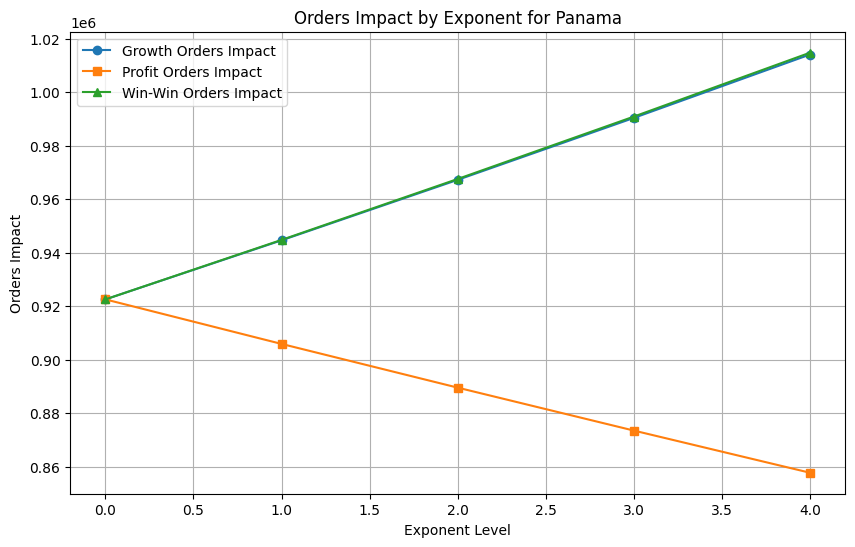

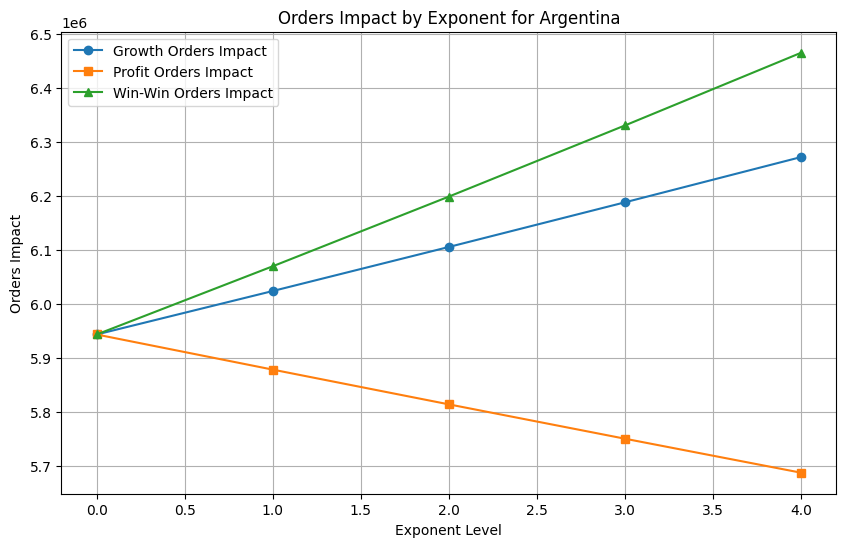

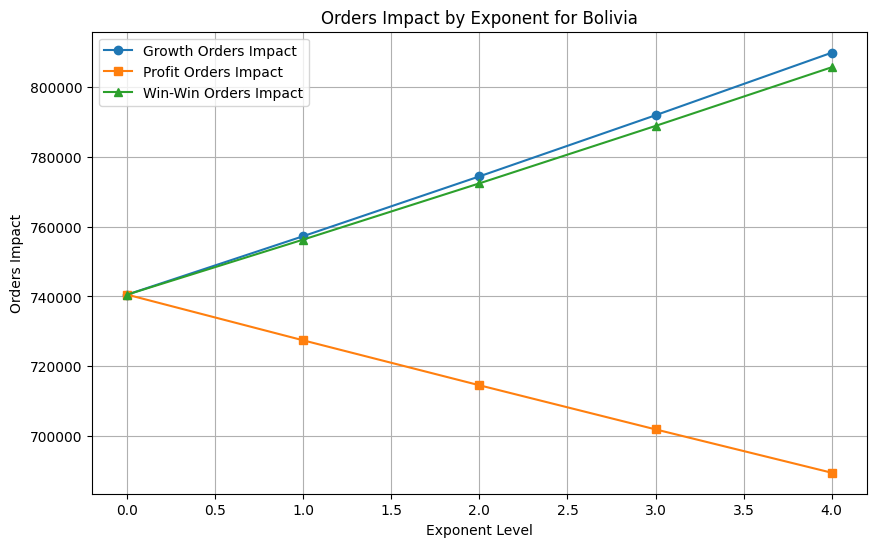

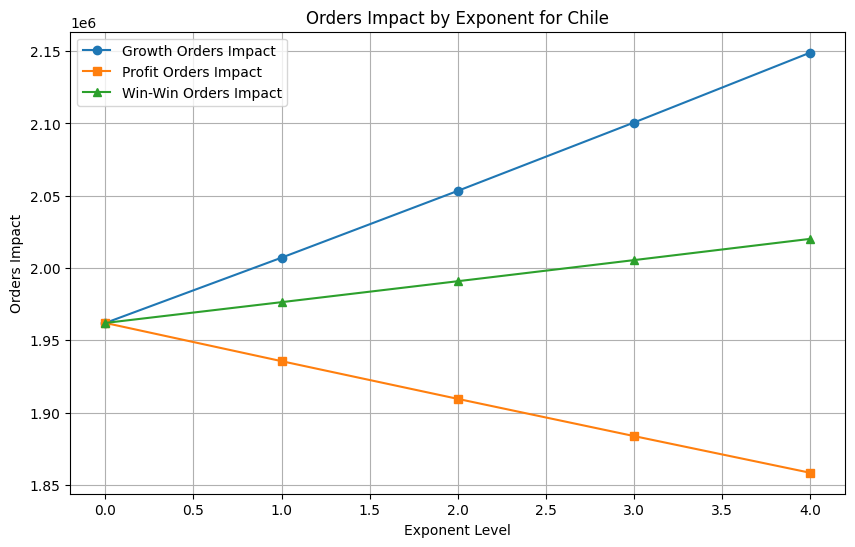

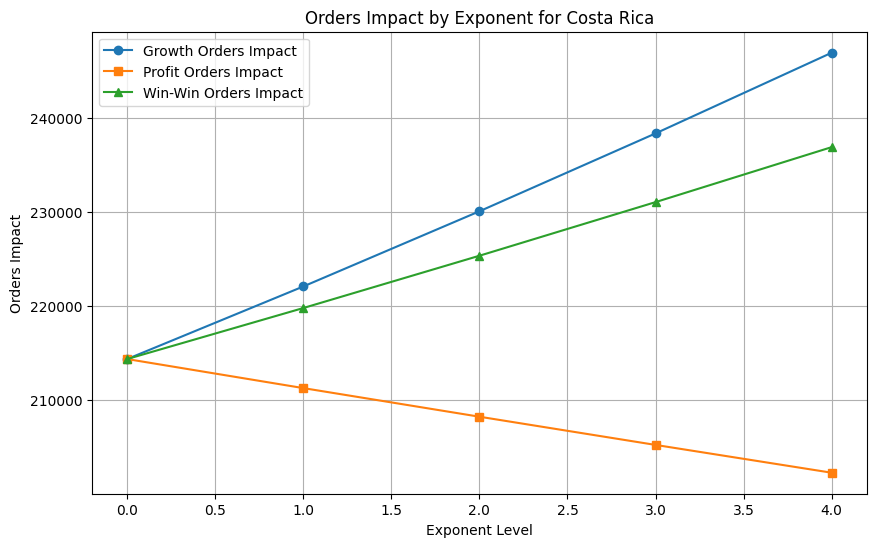

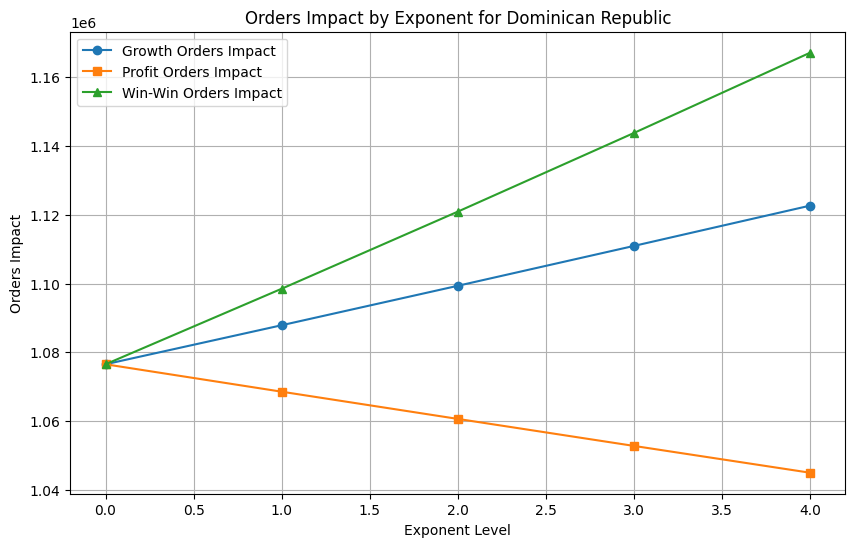

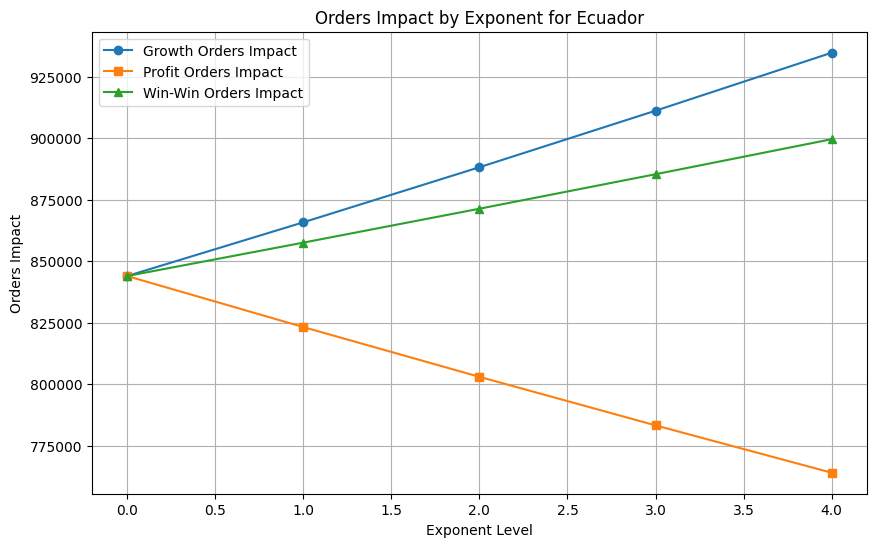

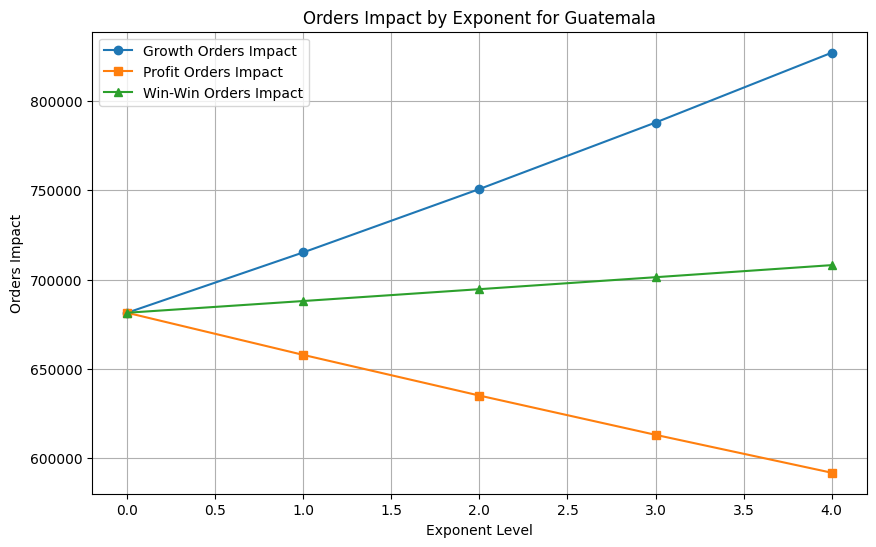

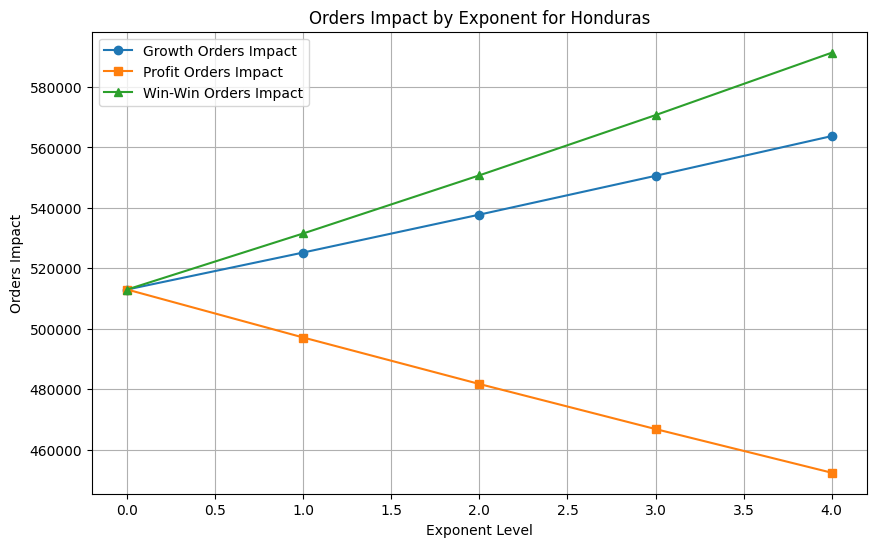

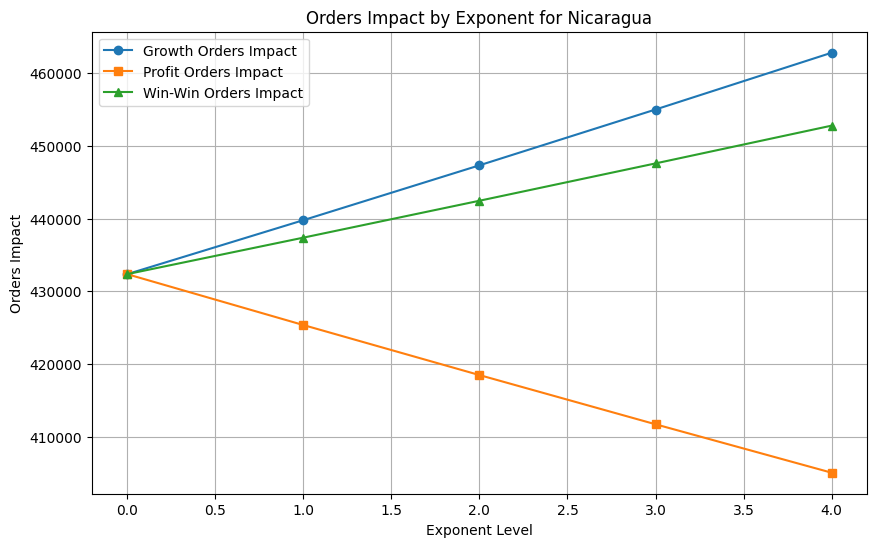

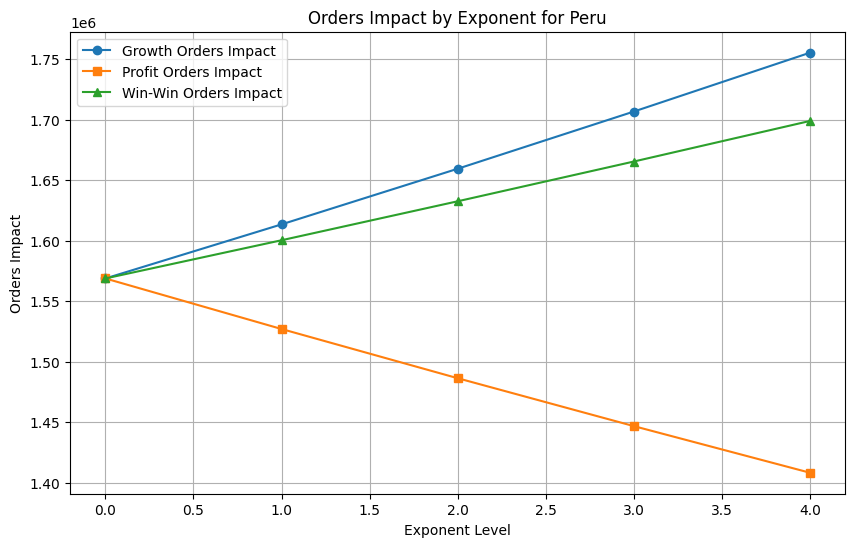

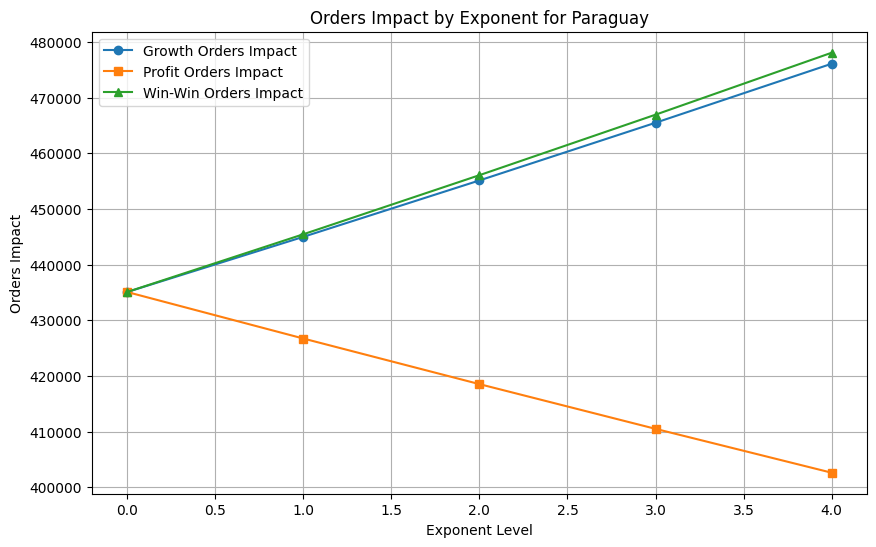

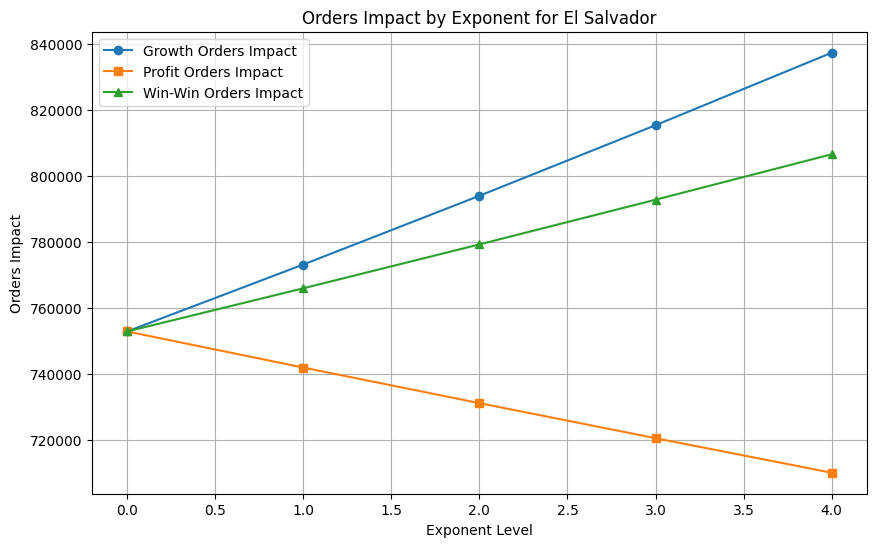

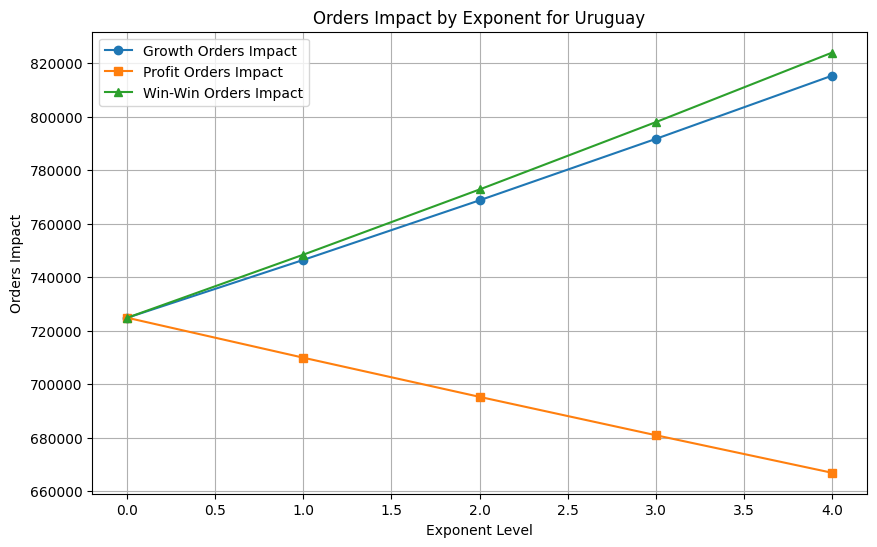

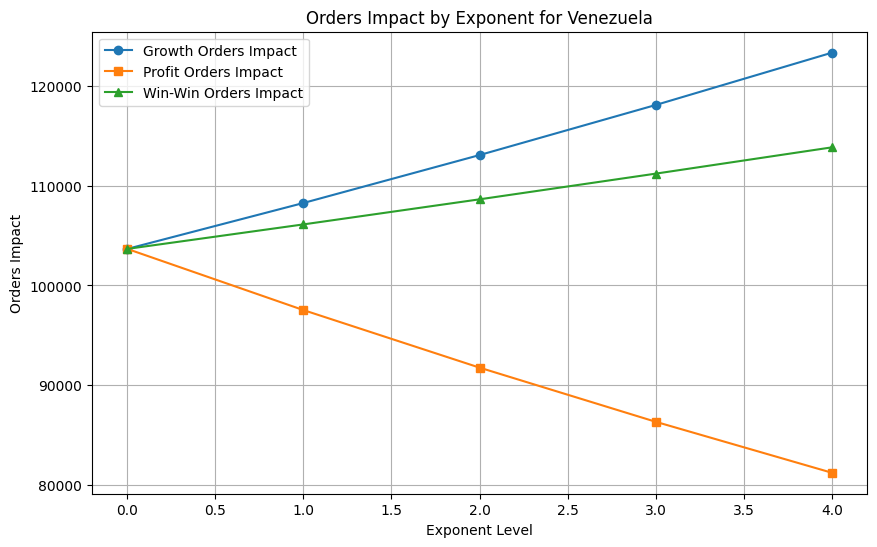

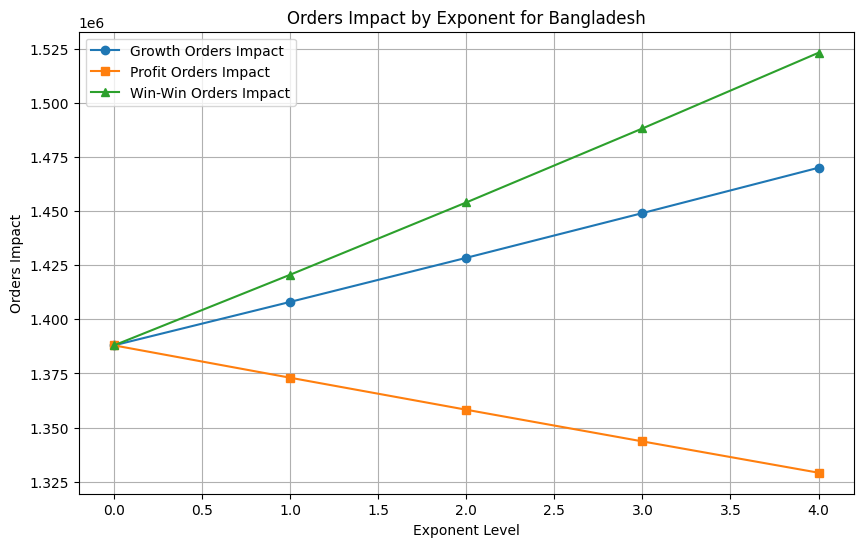

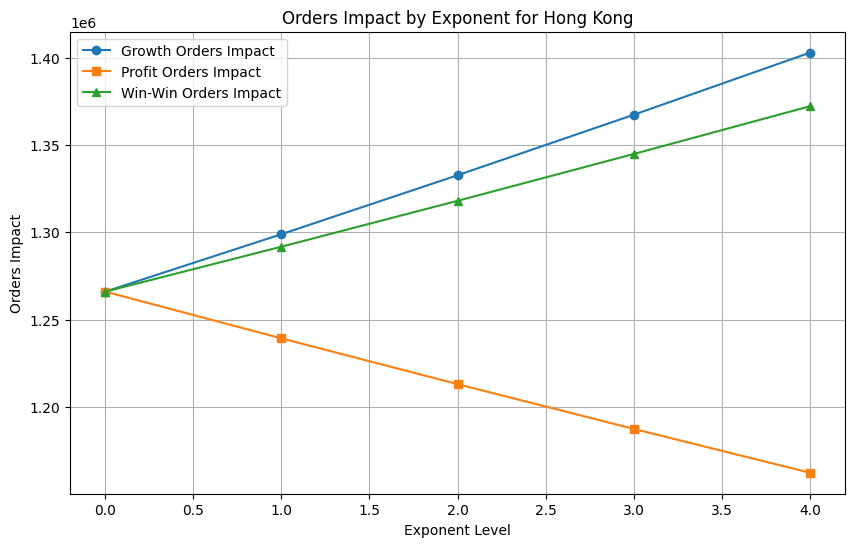

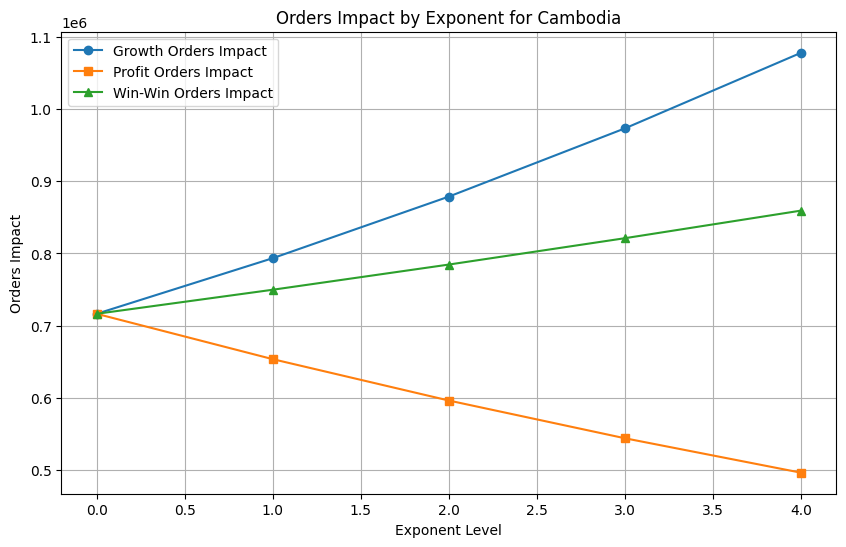

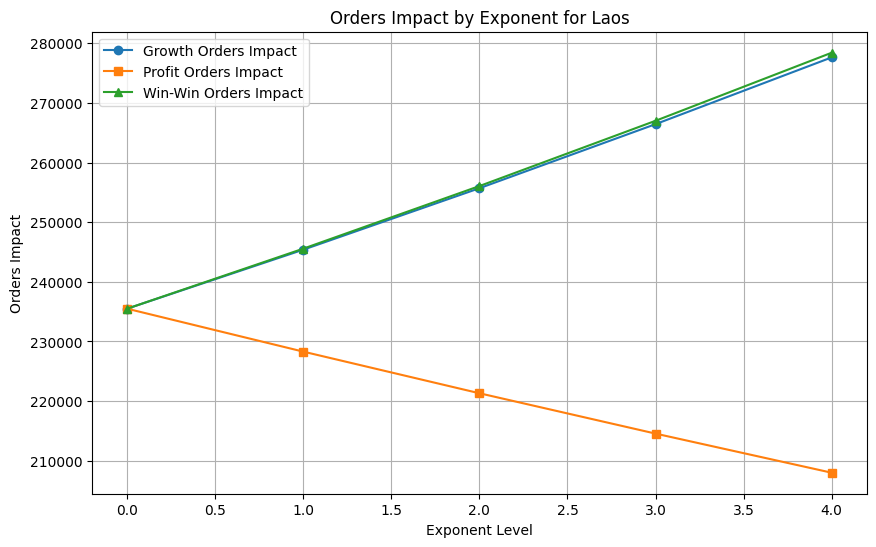

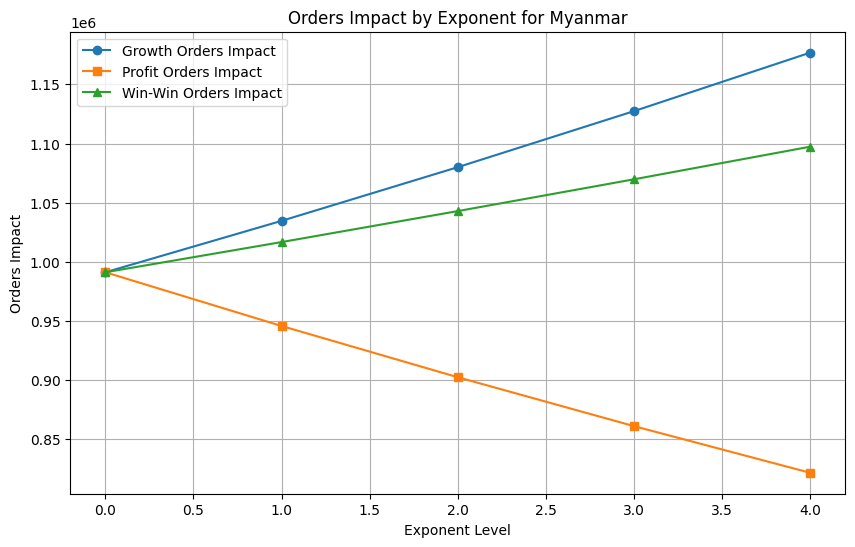

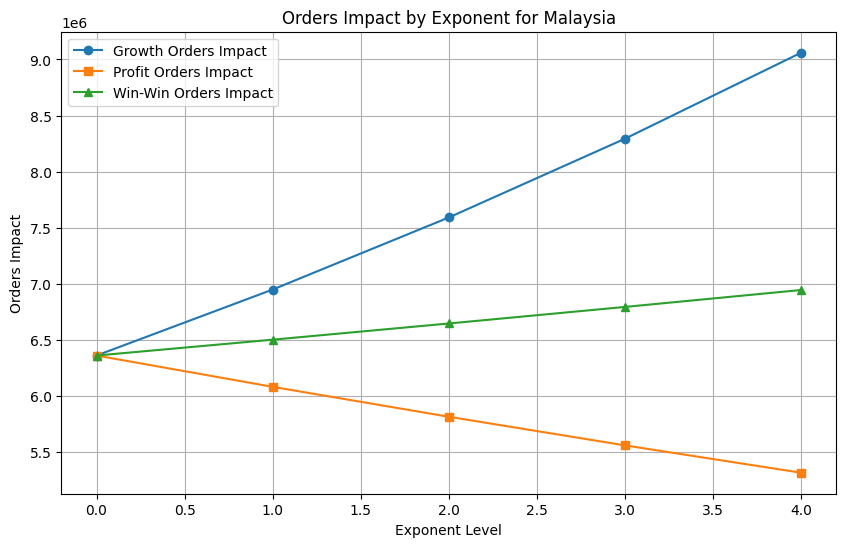

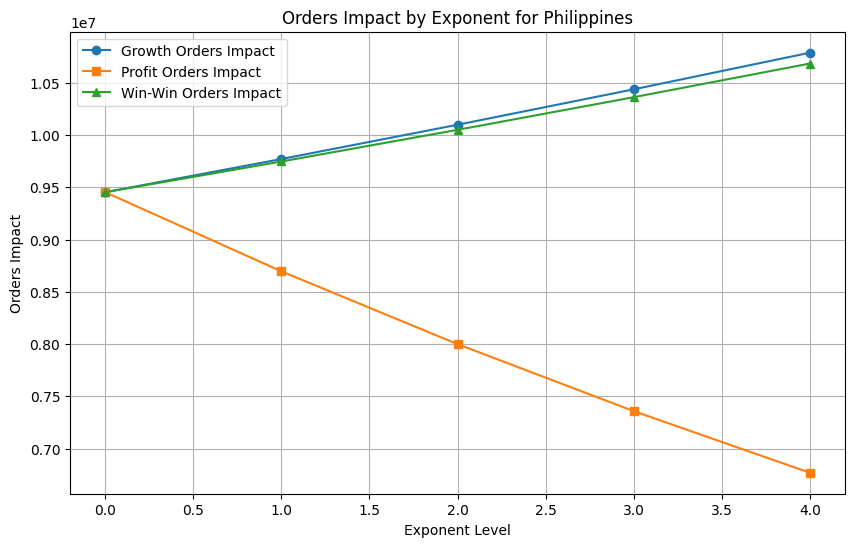

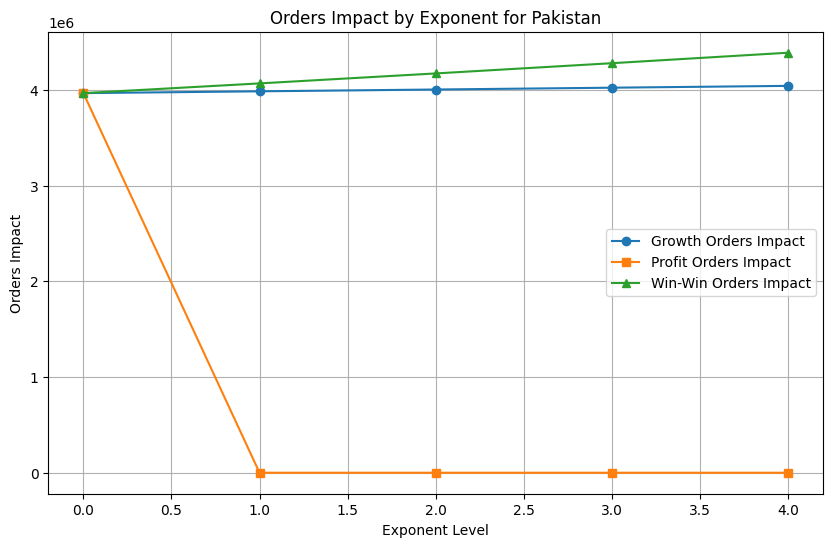

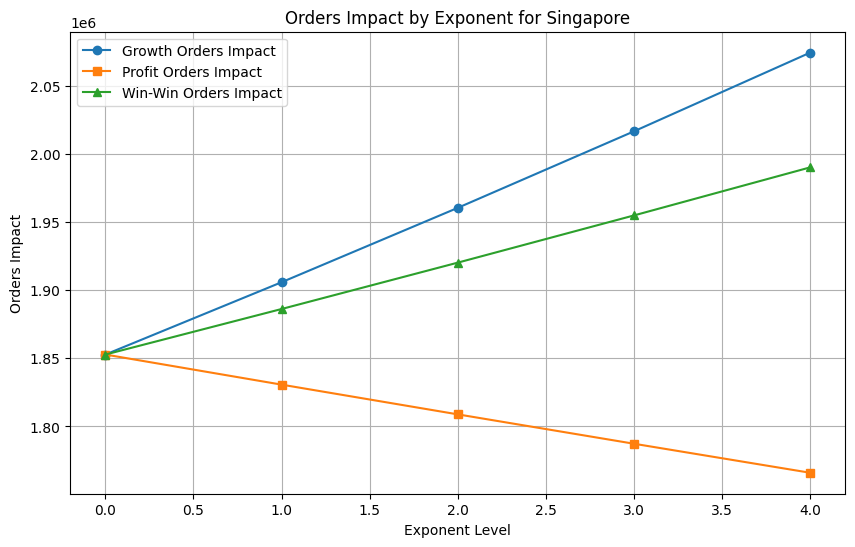

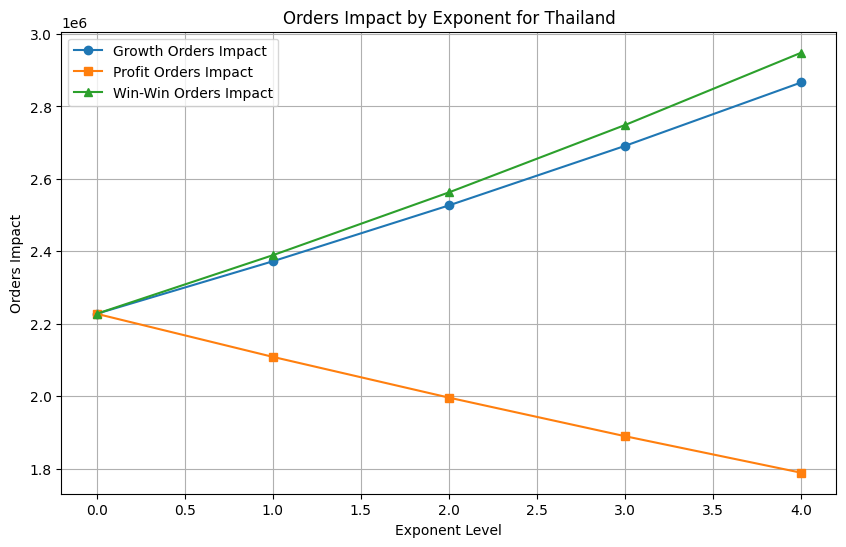

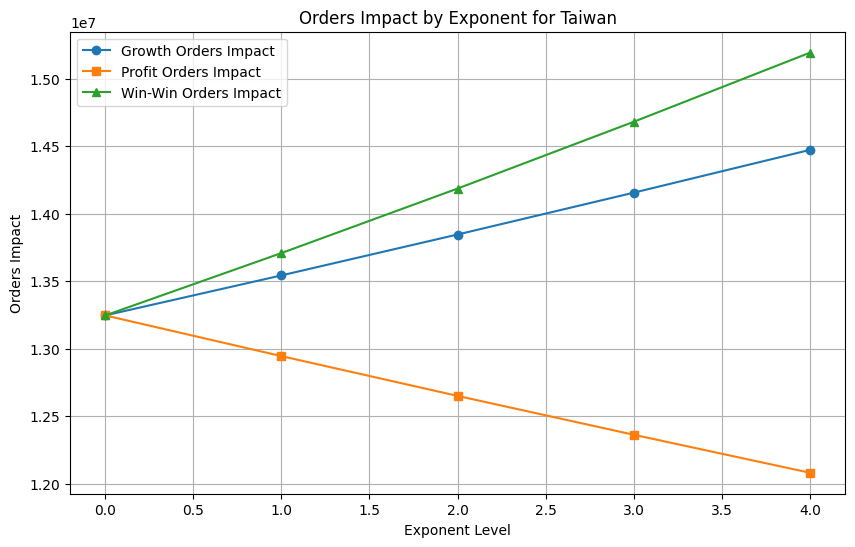

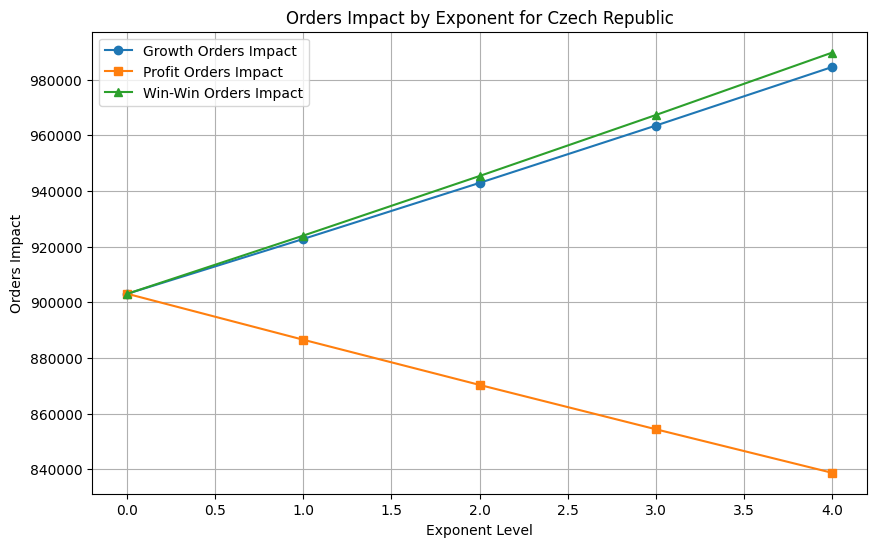

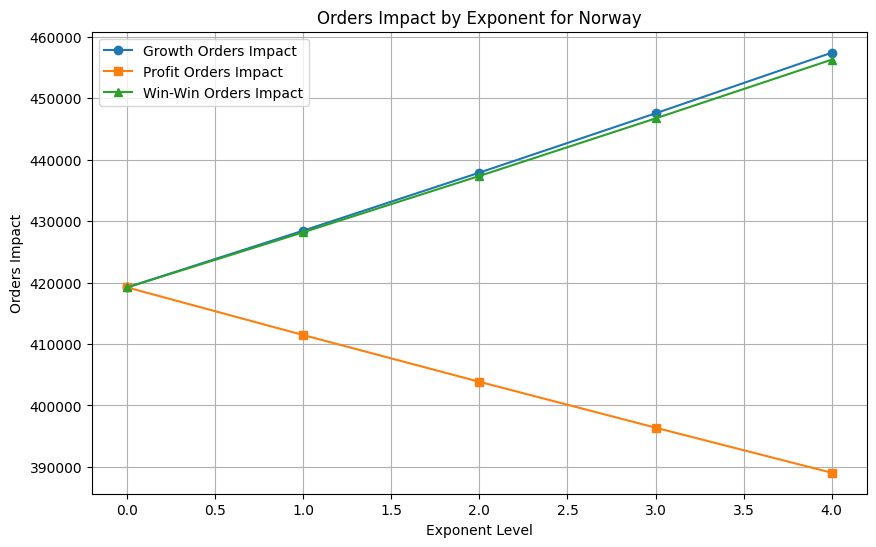

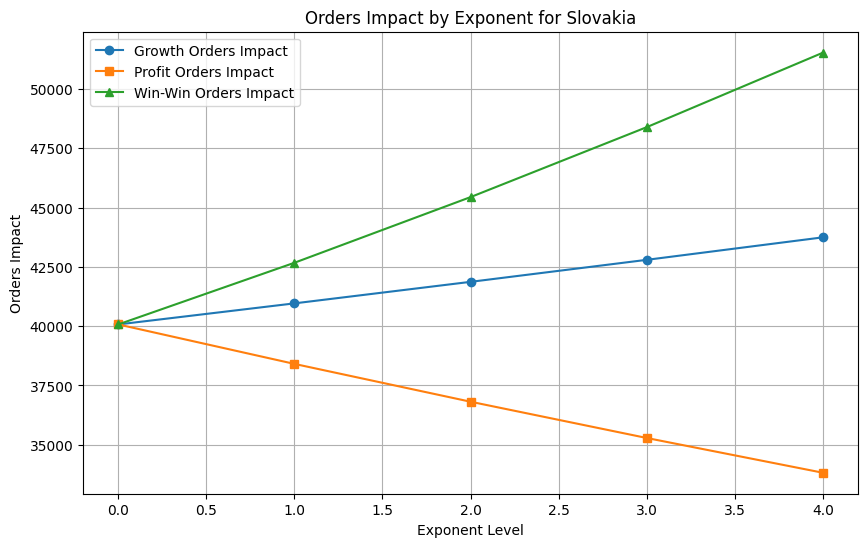

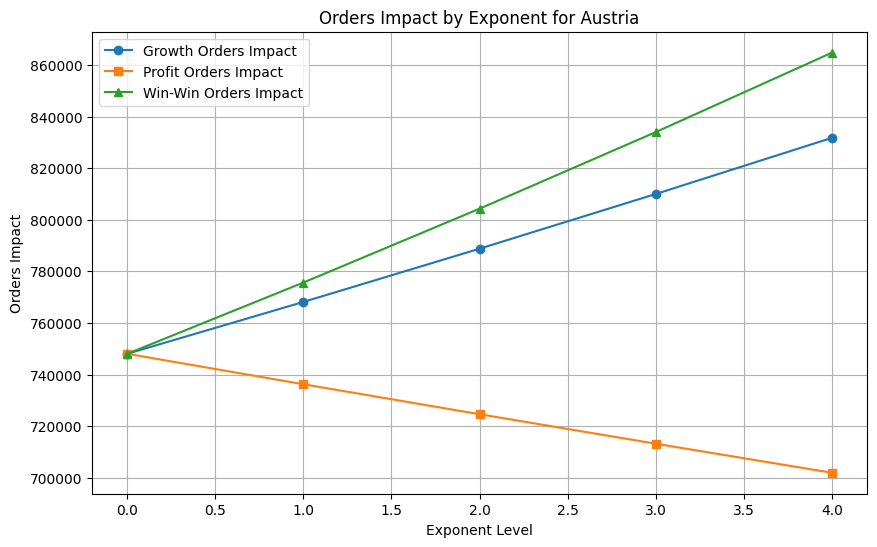

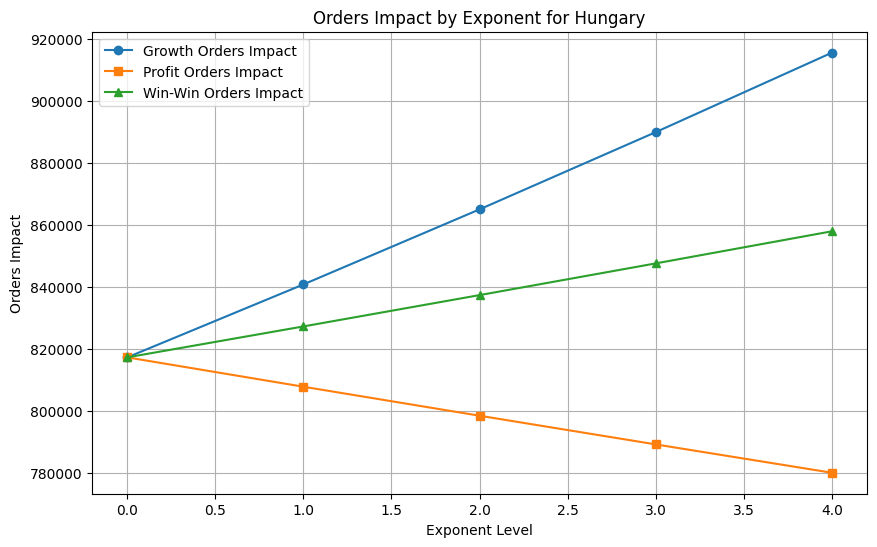

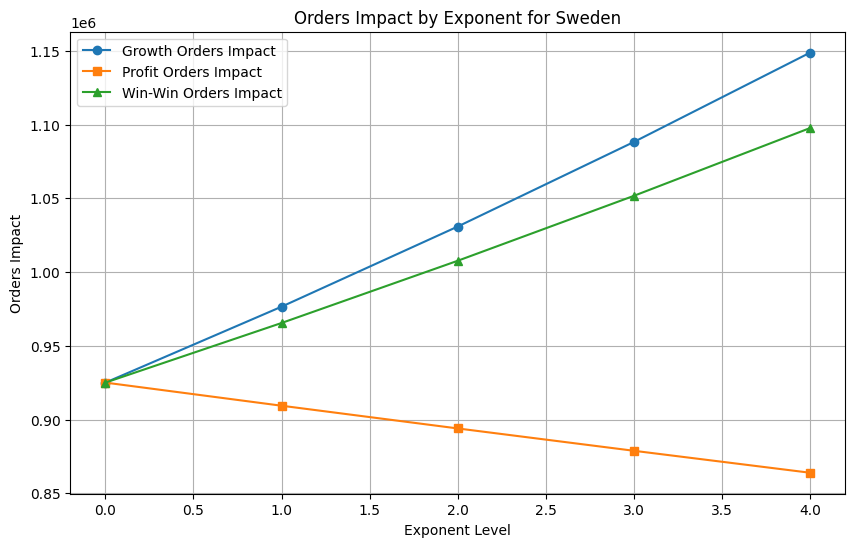

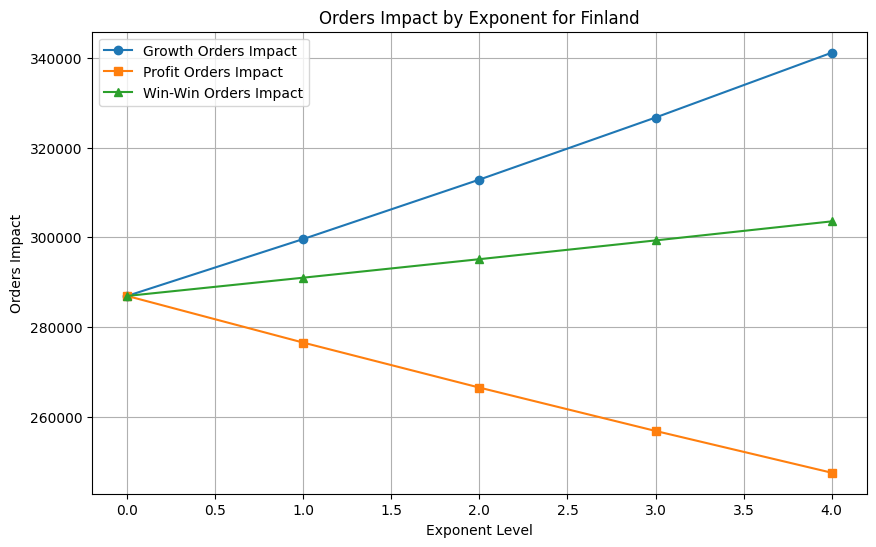

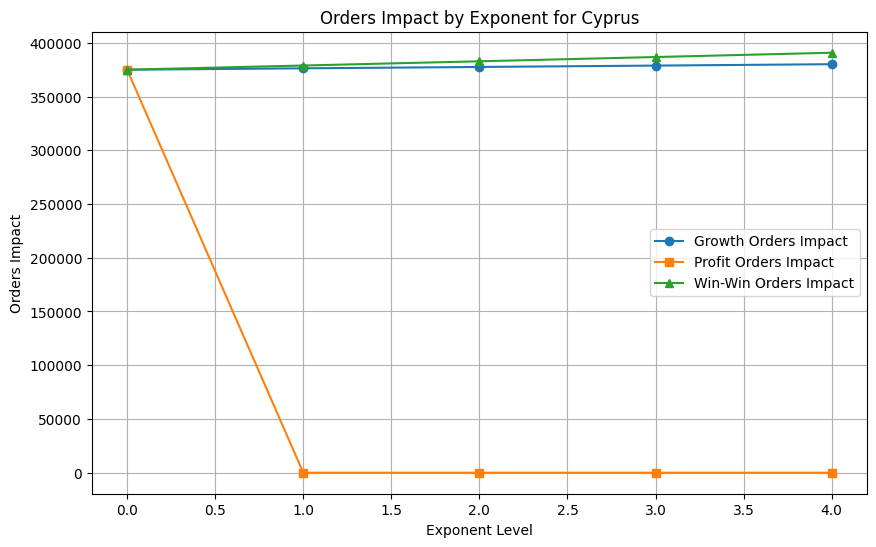

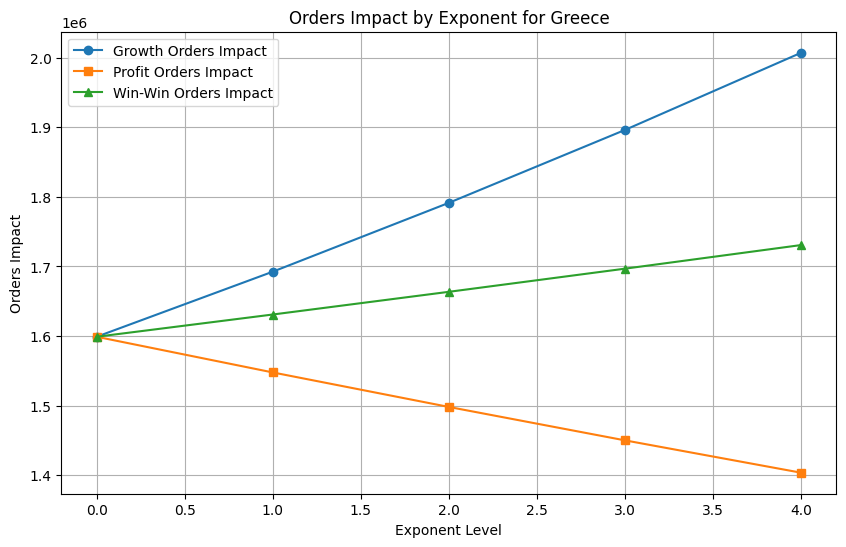

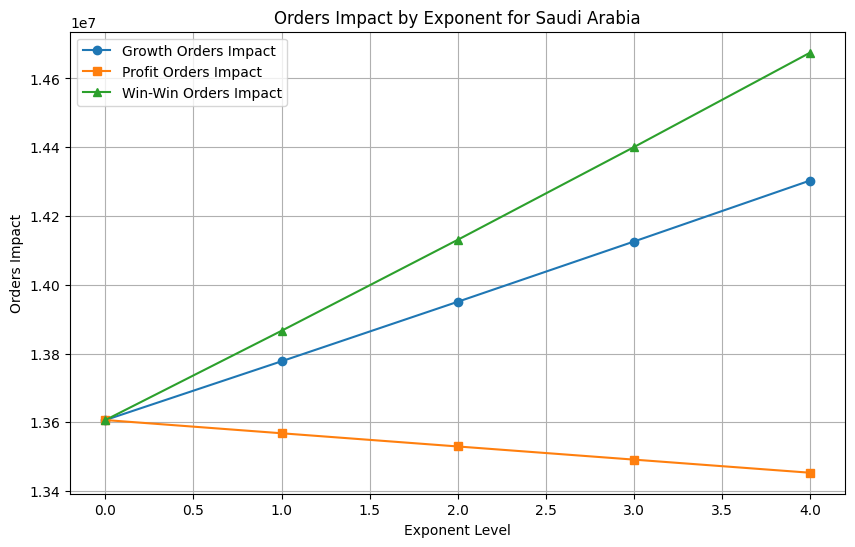

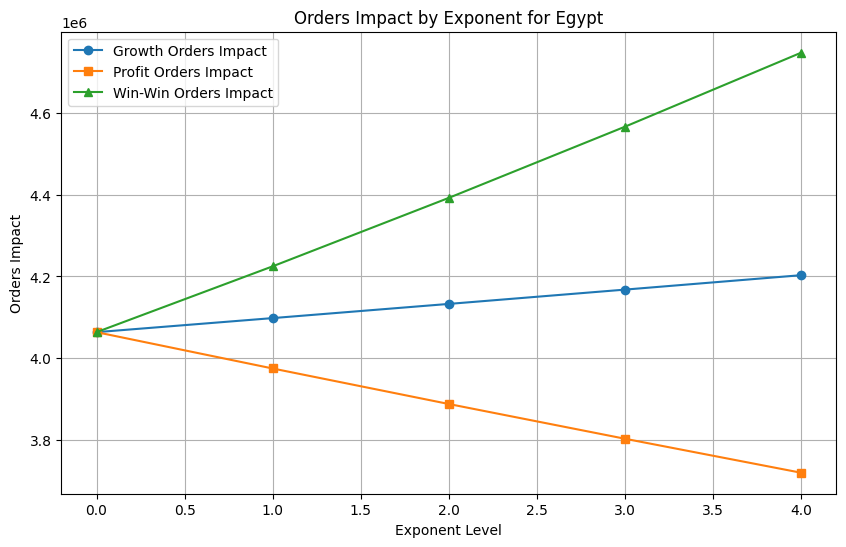

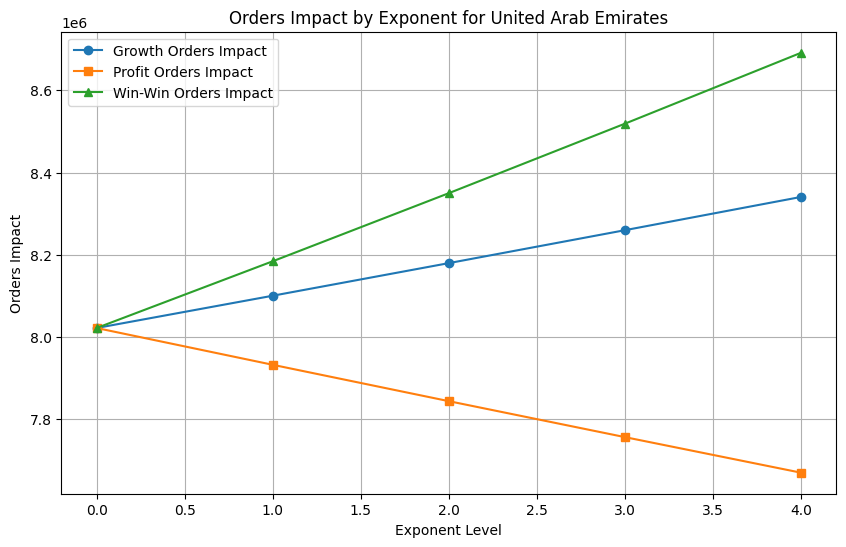

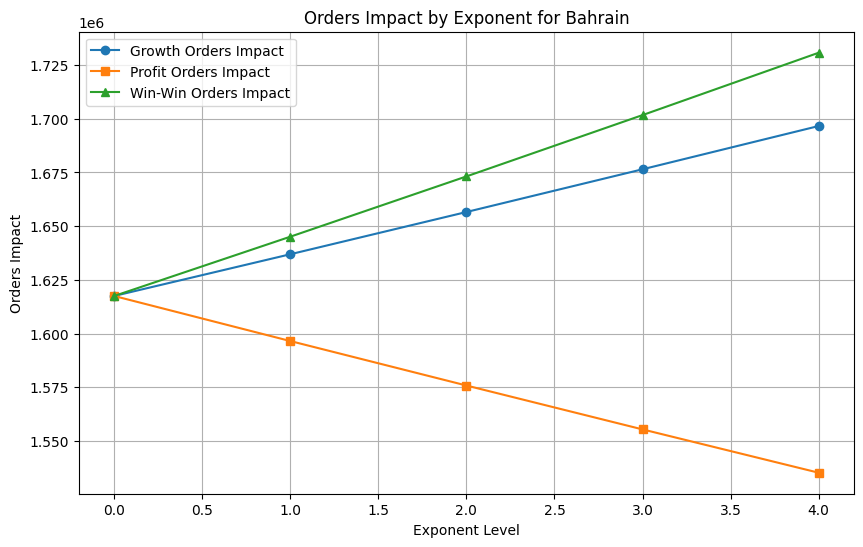

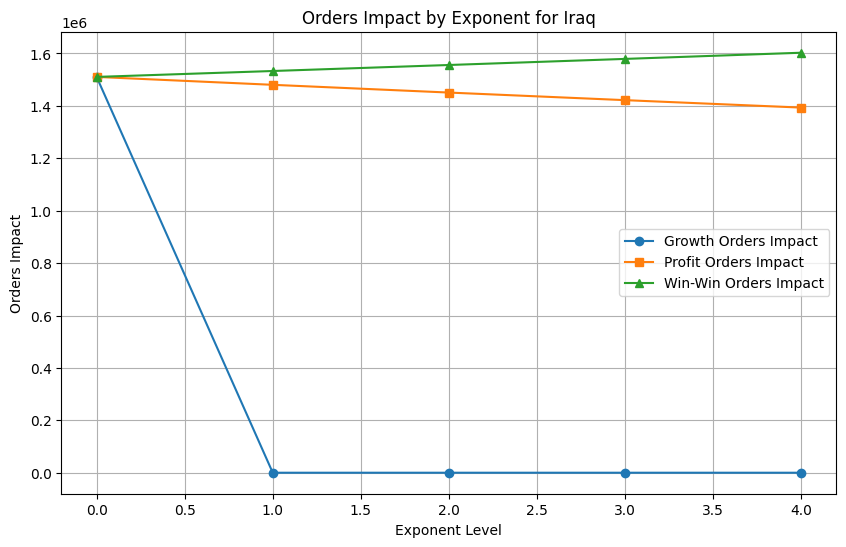

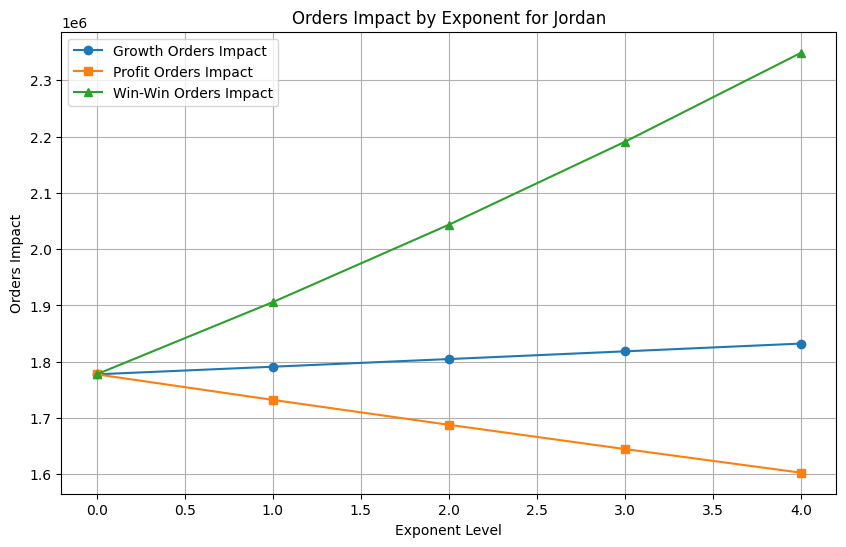

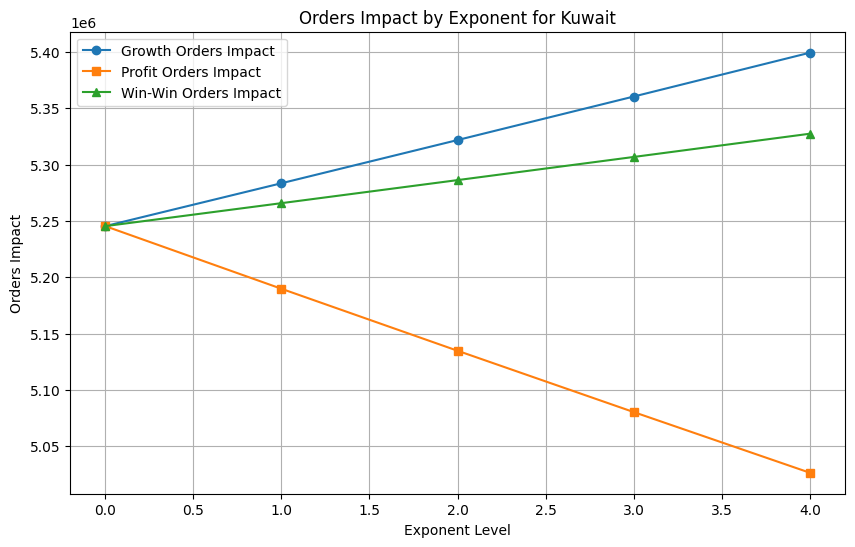

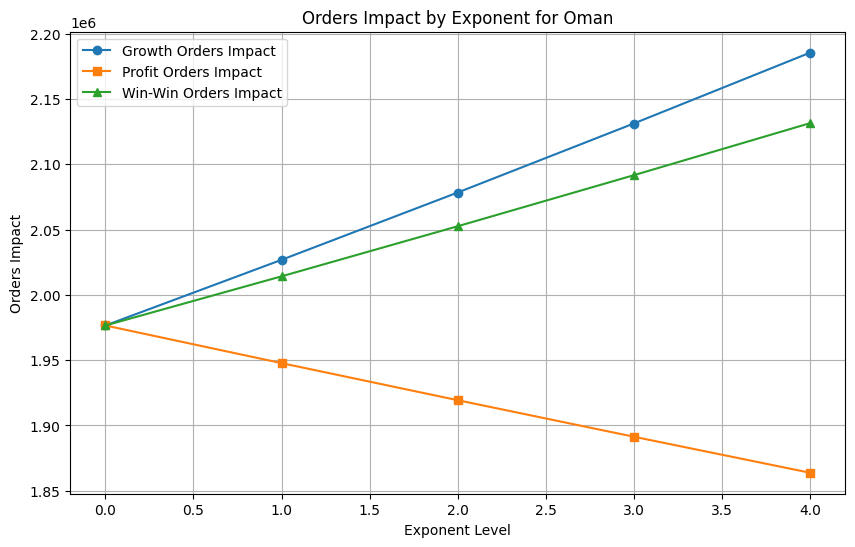

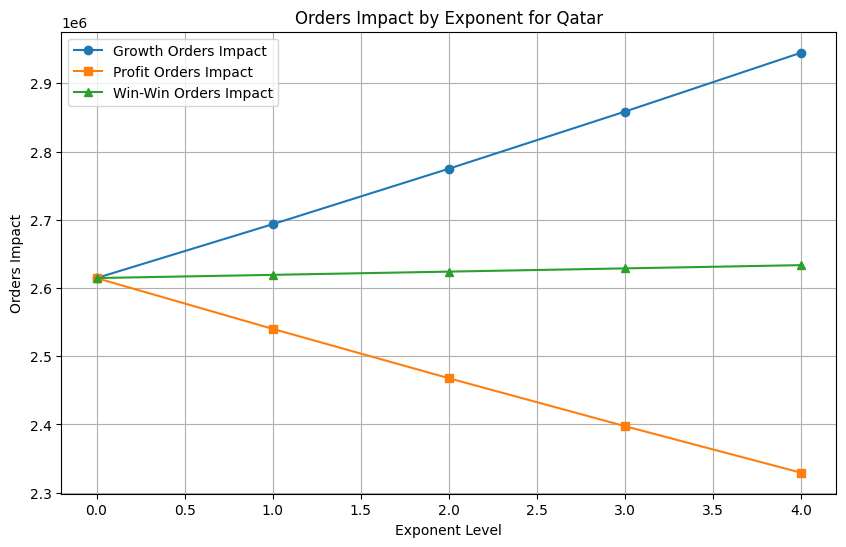

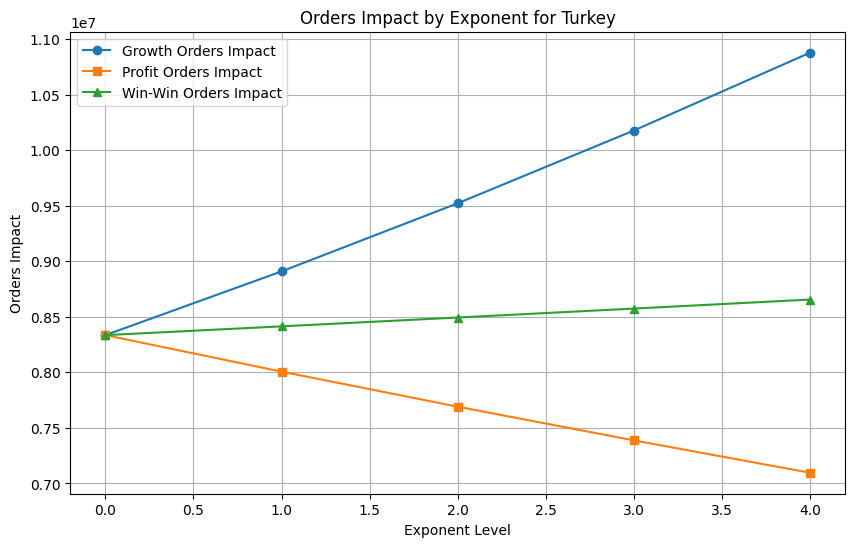

In [3073]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate orders impact at each exponent level
def calculate_exponent_orders_impact(row, max_exponent, increment=1):
    exponents = np.arange(0, max_exponent + increment, increment)
    growth_impacts = []
    profit_impacts = []
    win_impacts = []
    
    for exp in exponents:
        growth_impact = (
            row['avg_orders_per_user'] *
            ((row['orders_per_user_perc_change_CPiO - Growth at a Cost'] ** exp) * row['avg_total_active_users'])
        )
        profit_impact = (
            row['avg_orders_per_user'] *
            ((row['orders_per_user_perc_change_MPOL - Profit at a Cost'] ** exp) * row['avg_total_active_users'])
        )
        win_impact = (
            row['avg_orders_per_user'] *
            ((row['orders_per_user_perc_change_Win-Win'] ** exp) * row['avg_total_active_users'])
        )
        
        growth_impacts.append(growth_impact)
        profit_impacts.append(profit_impact)
        win_impacts.append(win_impact)
    
    return exponents, growth_impacts, profit_impacts, win_impacts

# Visualization of orders impact per exponent by country
countries = final_df['country_name'].unique()
max_exponent = 4  # Adjust as needed

for country in countries:
    country_data = final_df[final_df['country_name'] == country].iloc[0]
    exponents, growth_impacts, profit_impacts, win_impacts = calculate_exponent_orders_impact(country_data, max_exponent)
    
    plt.figure(figsize=(10, 6))
    plt.plot(exponents, growth_impacts, marker='o', linestyle='-', label="Growth Orders Impact")
    plt.plot(exponents, profit_impacts, marker='s', linestyle='-', label="Profit Orders Impact")
    plt.plot(exponents, win_impacts, marker='^', linestyle='-', label="Win-Win Orders Impact")
    
    plt.title(f"Orders Impact by Exponent for {country}")
    plt.xlabel("Exponent Level")
    plt.ylabel("Orders Impact")
    plt.legend()
    plt.grid(True)
    plt.show()


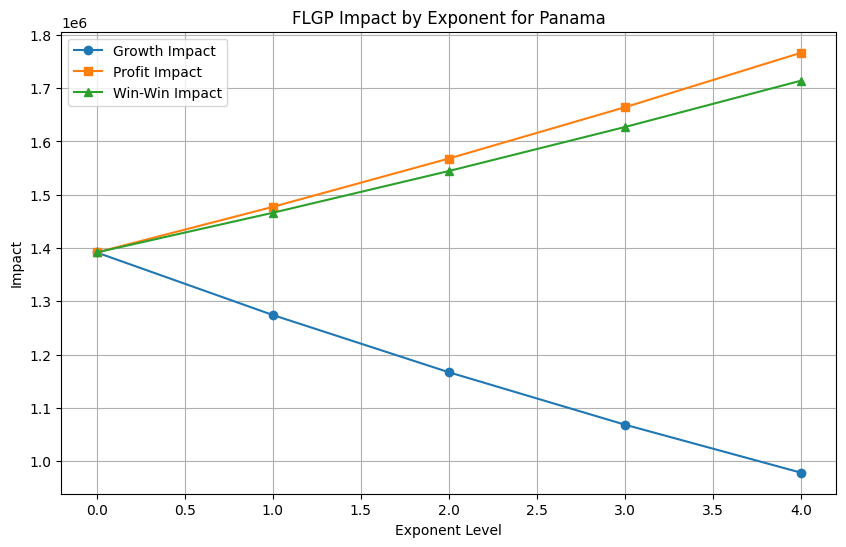

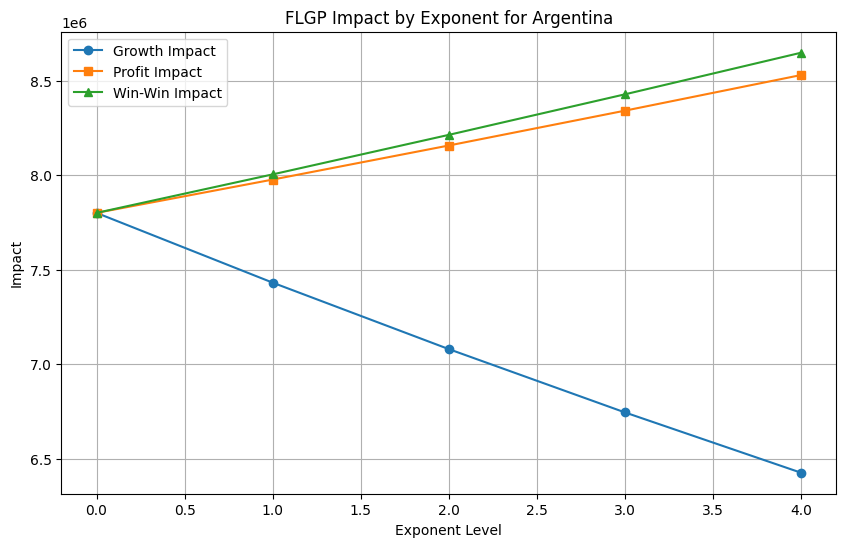

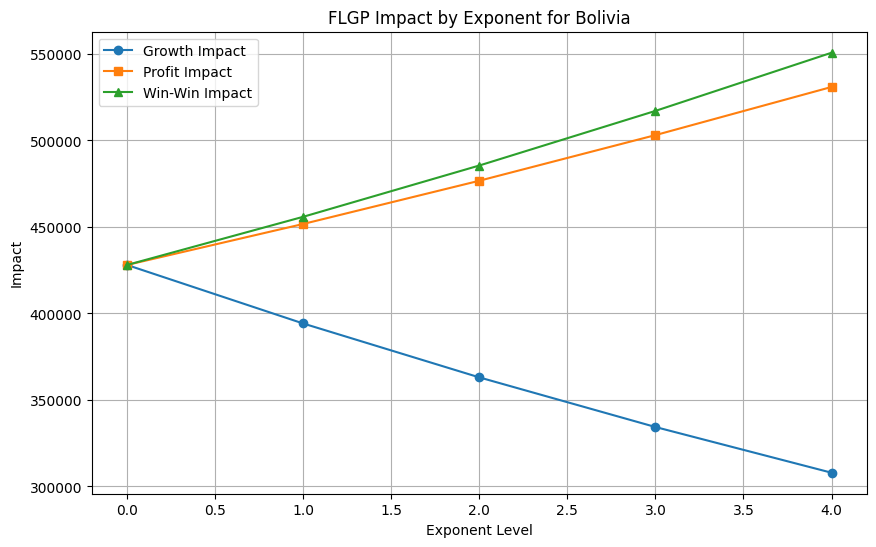

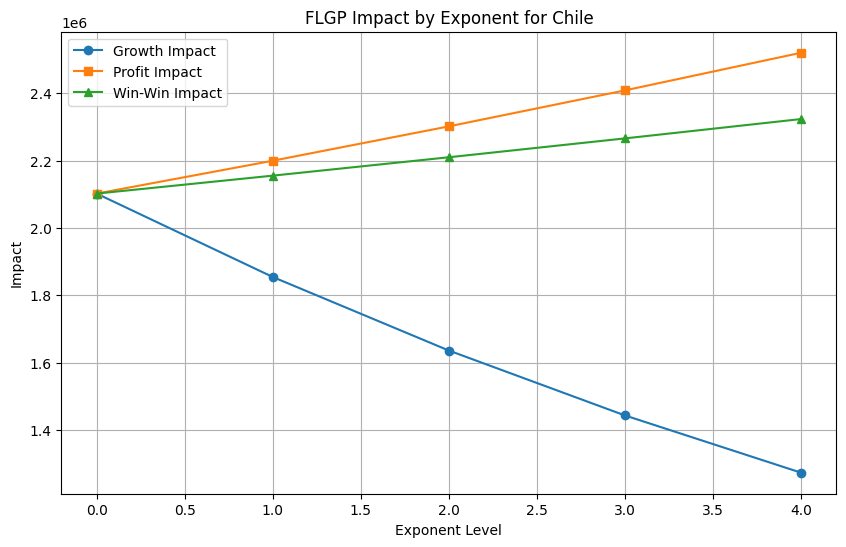

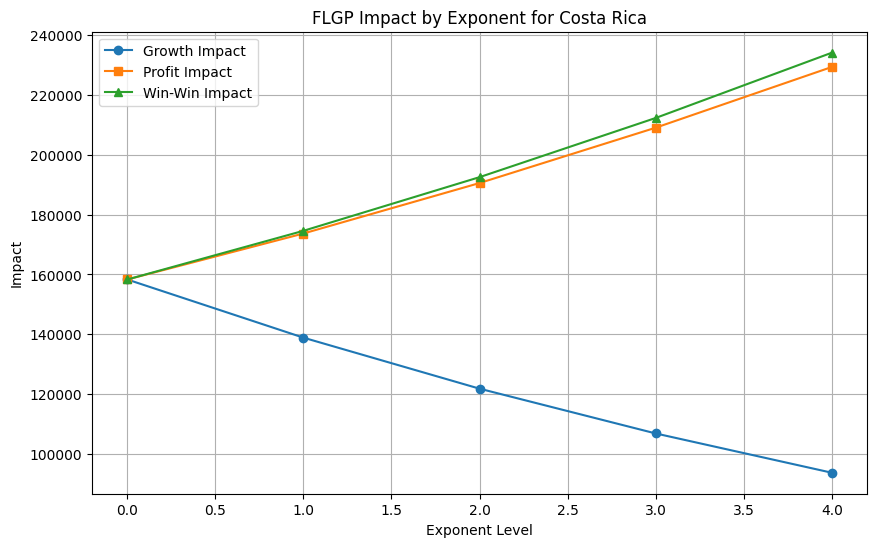

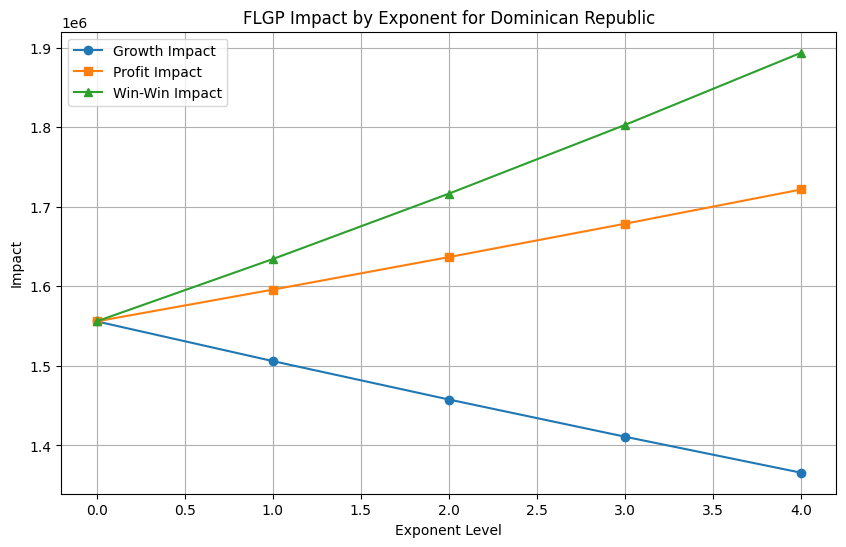

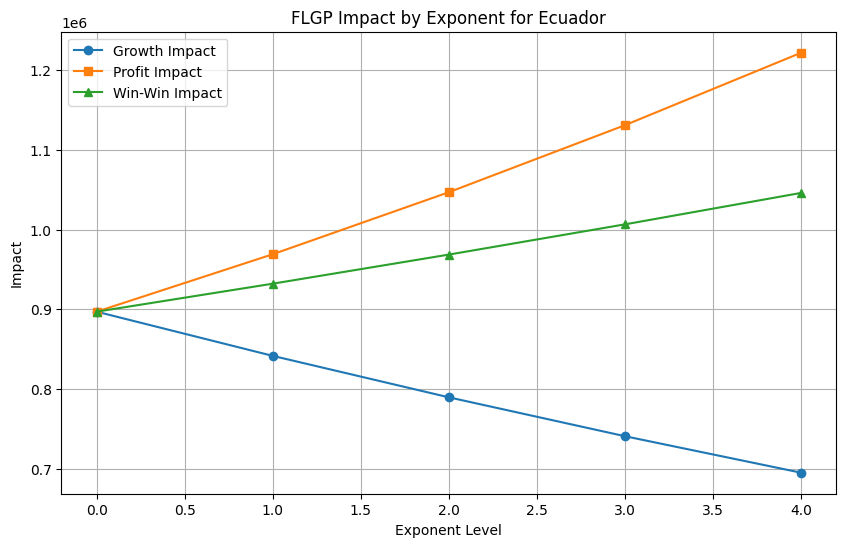

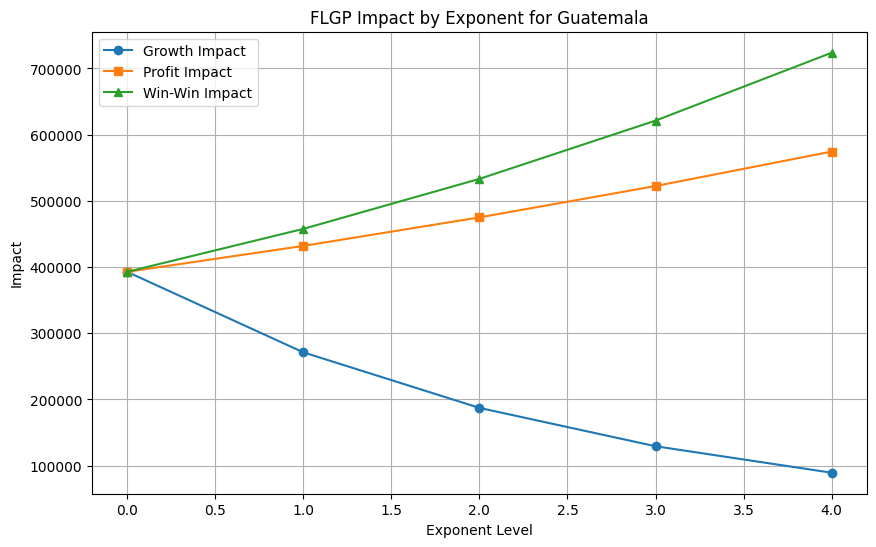

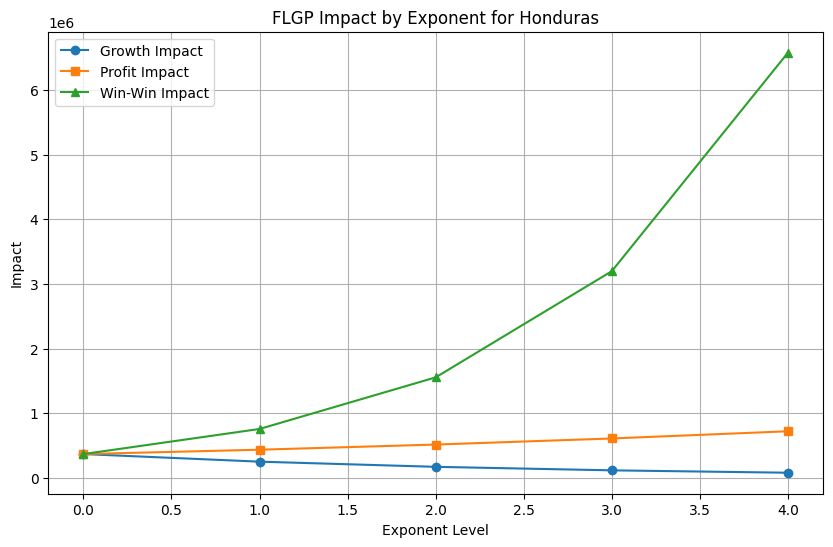

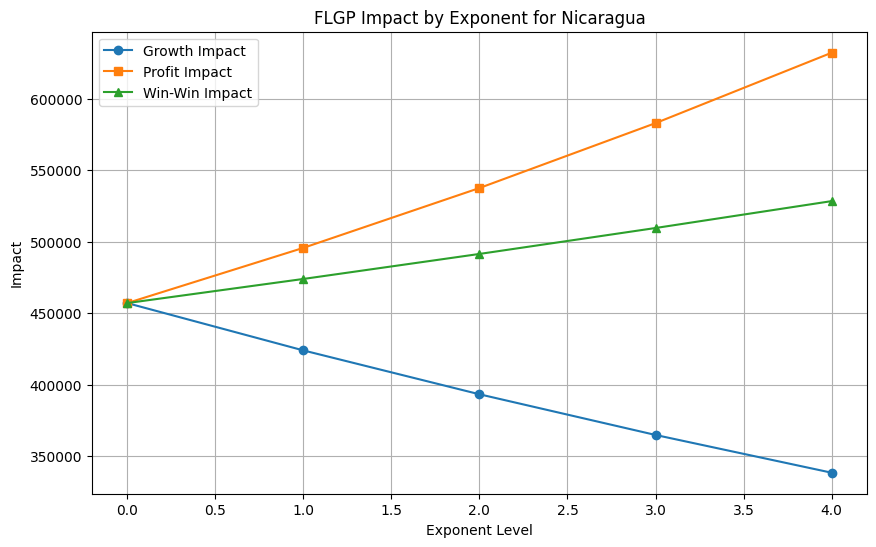

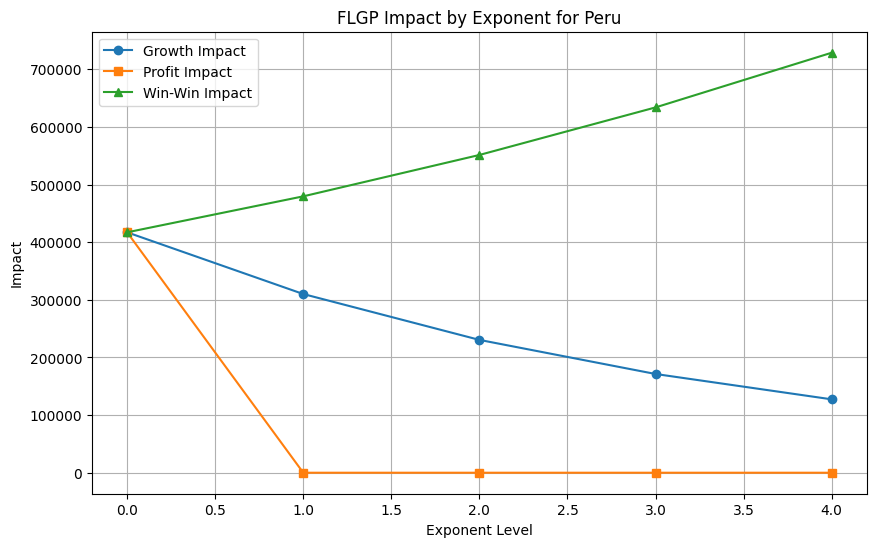

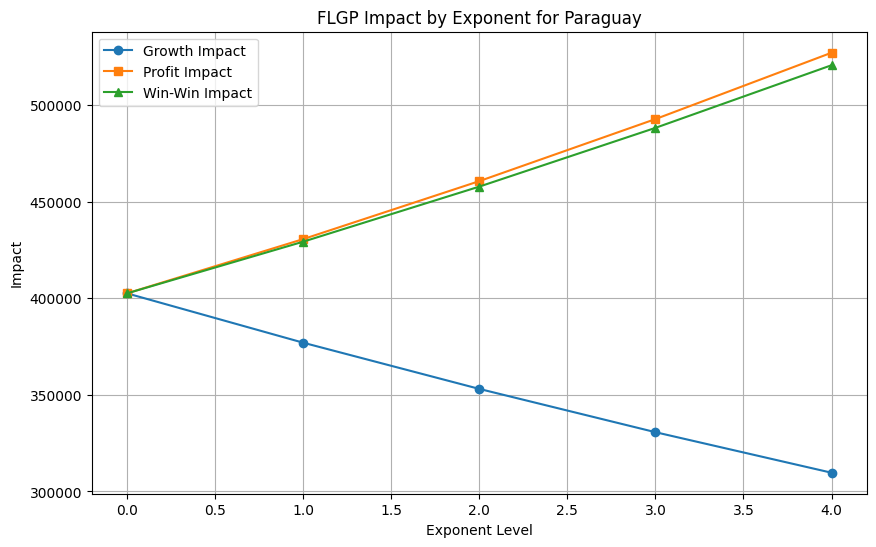

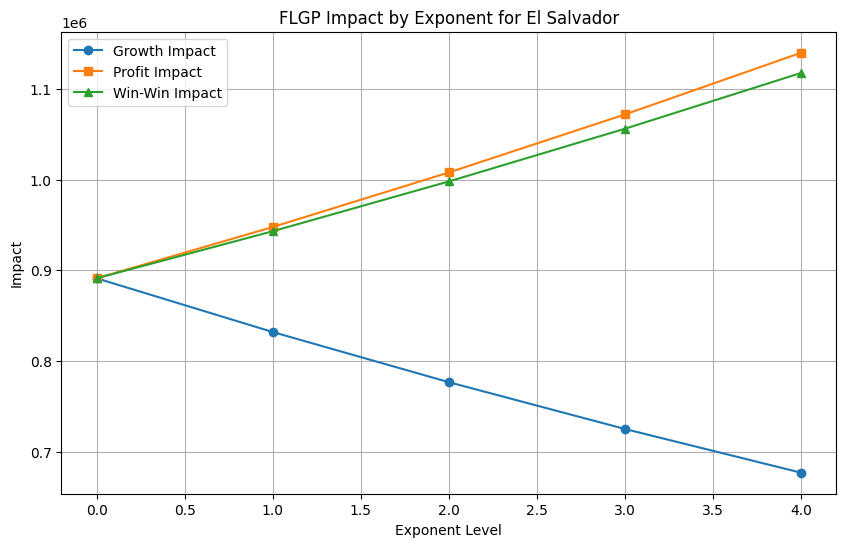

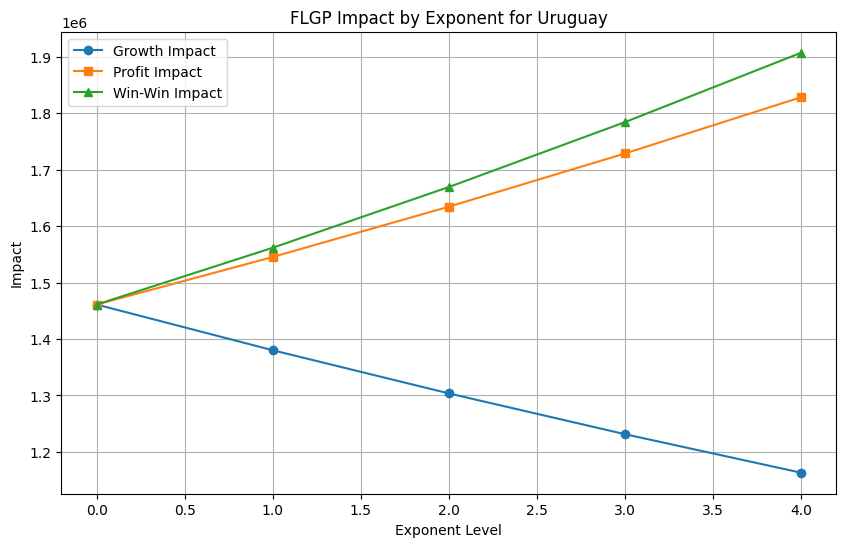

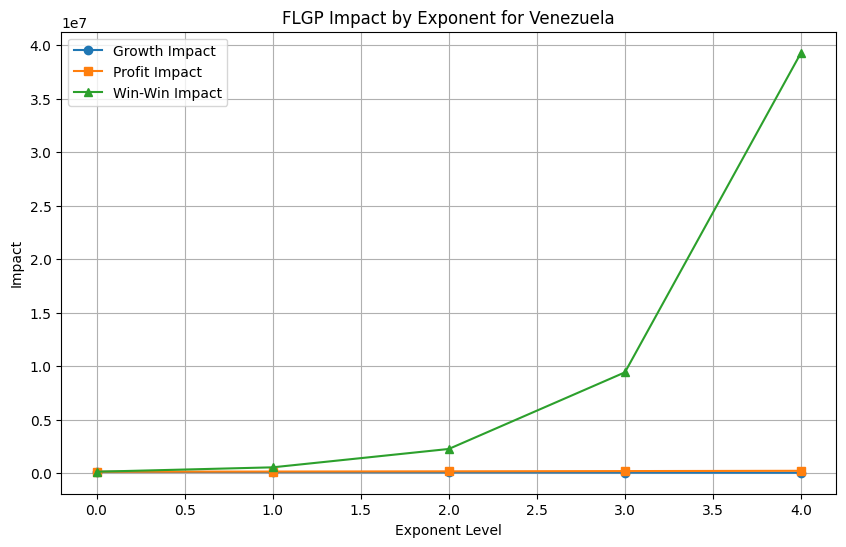

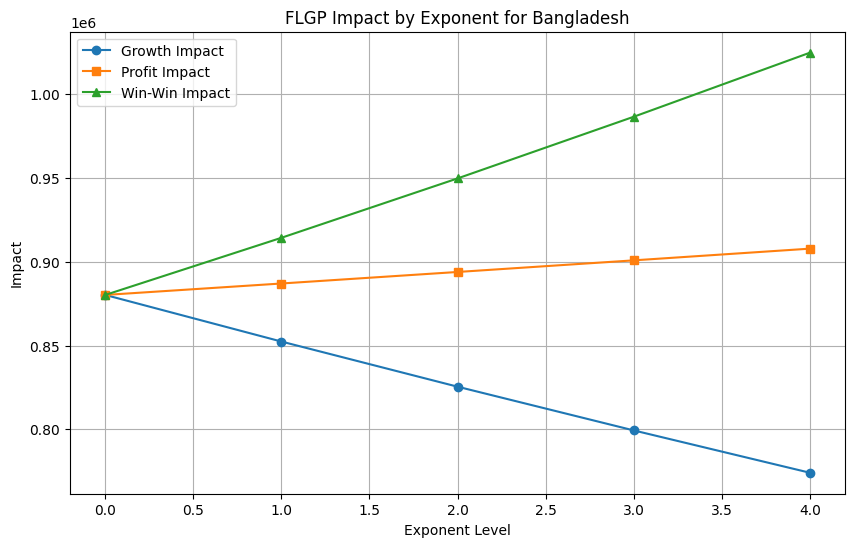

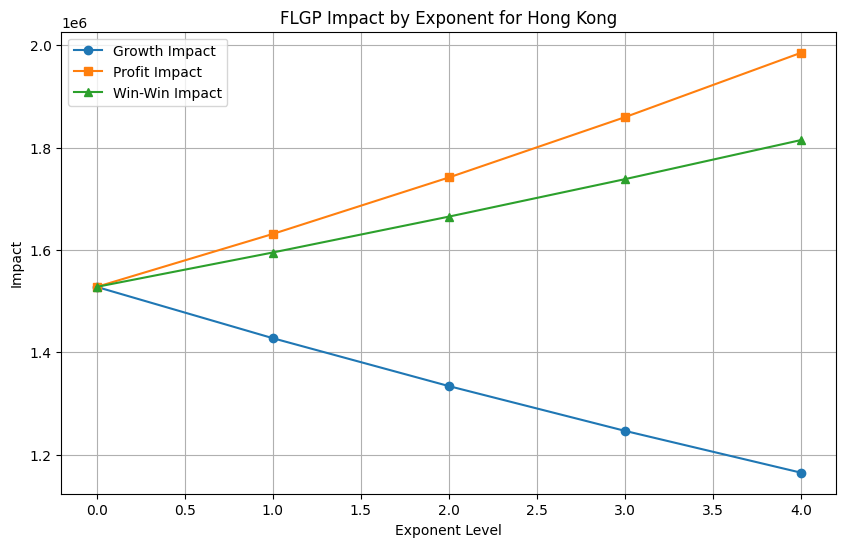

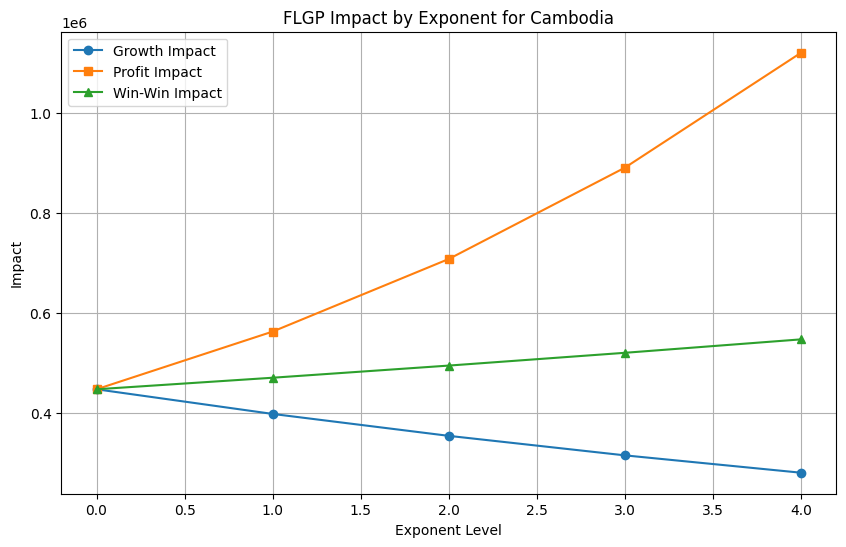

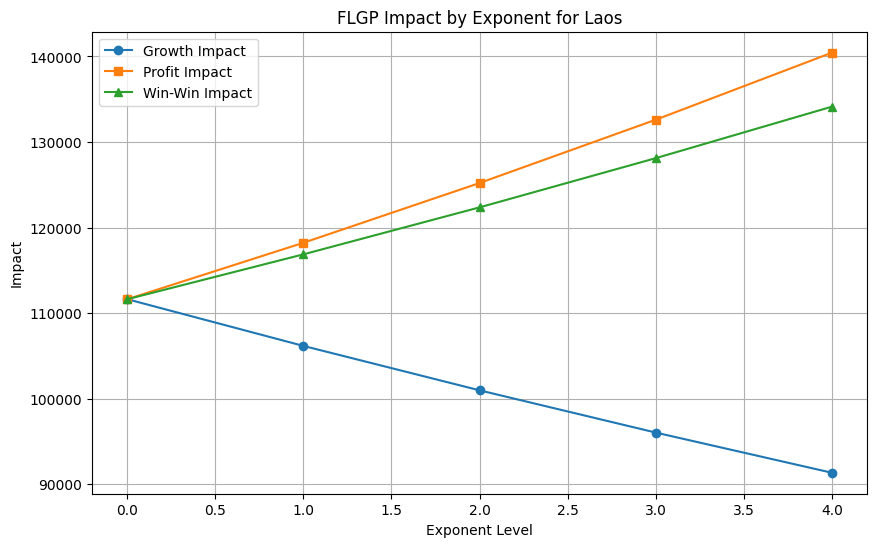

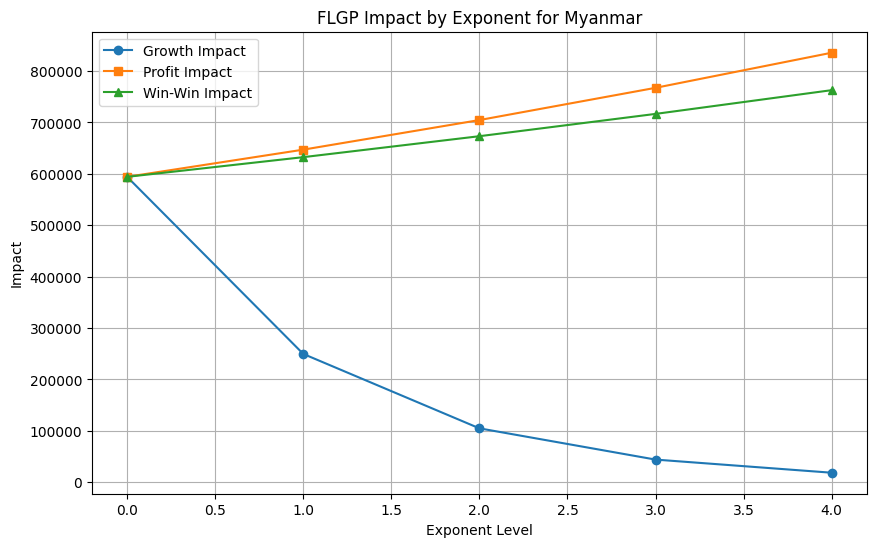

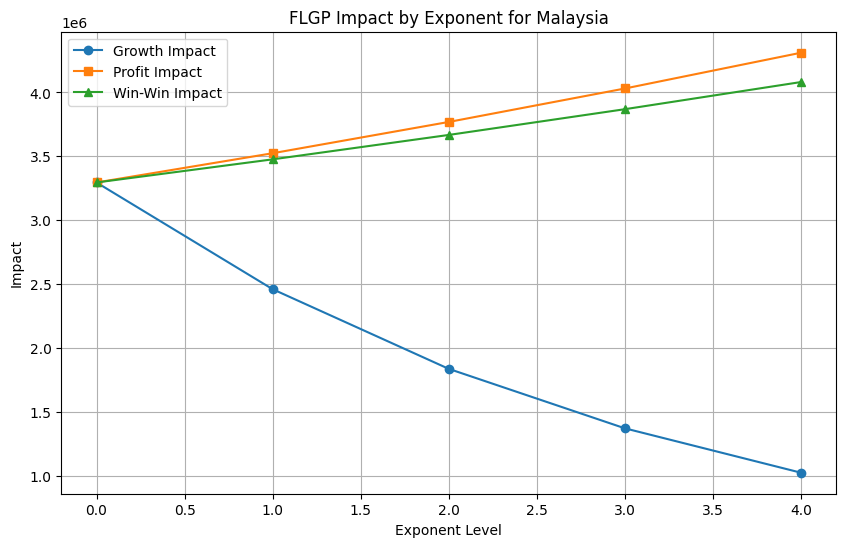

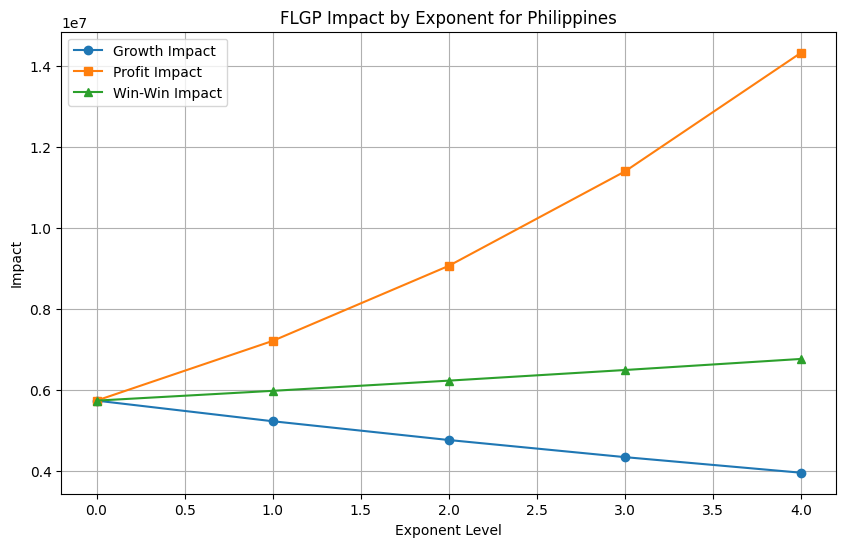

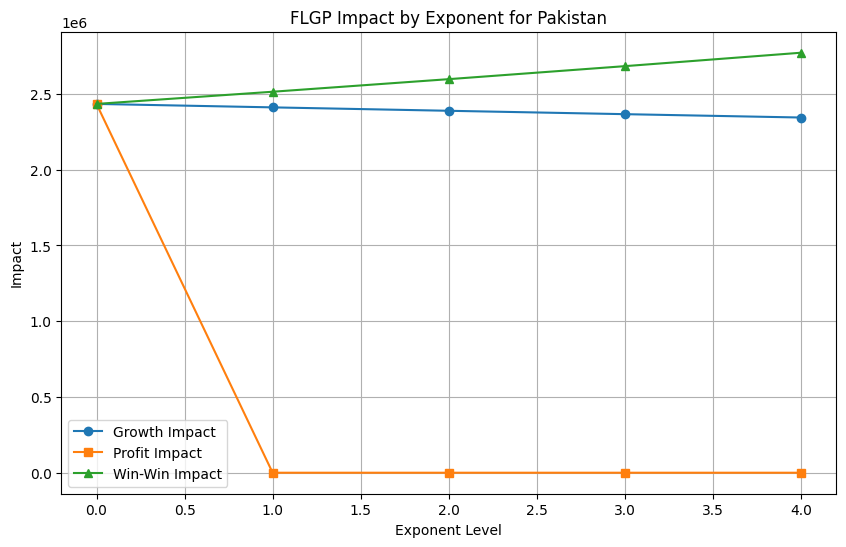

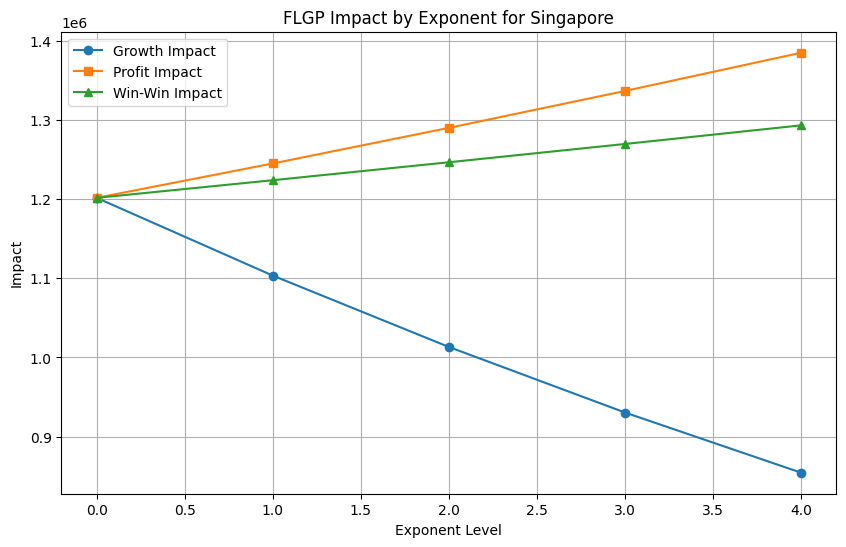

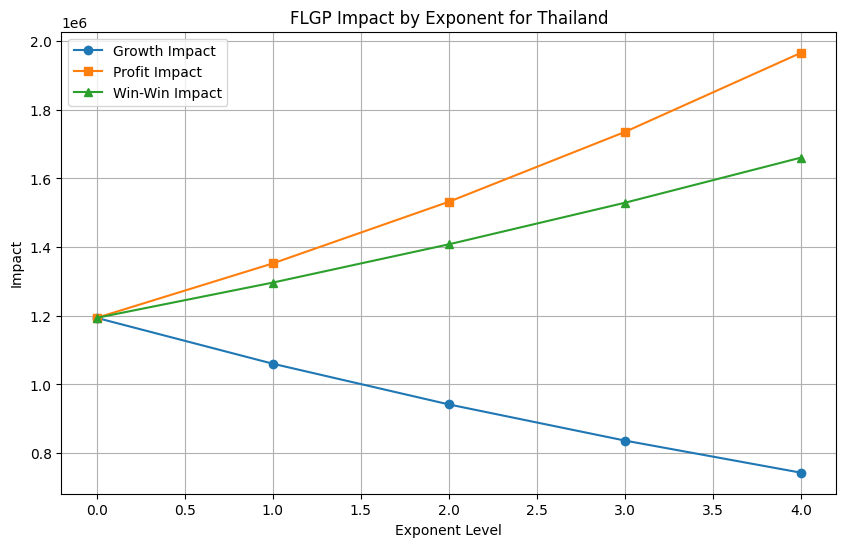

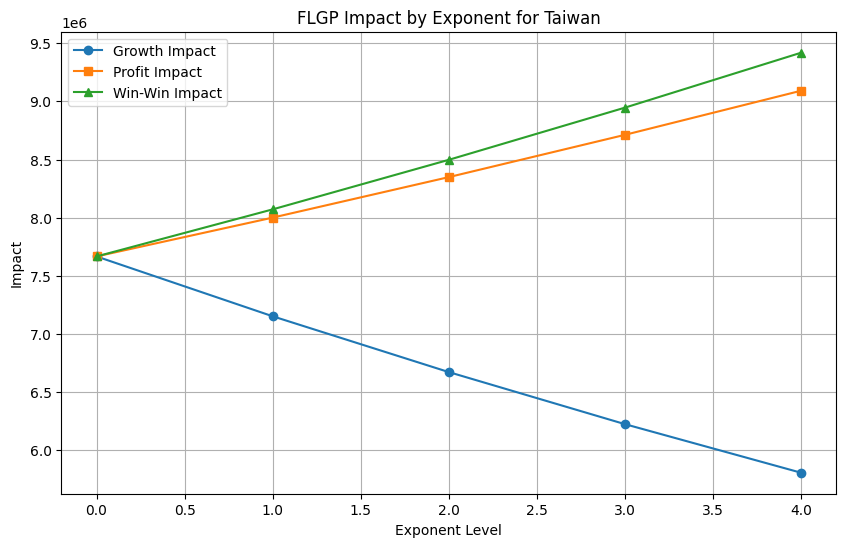

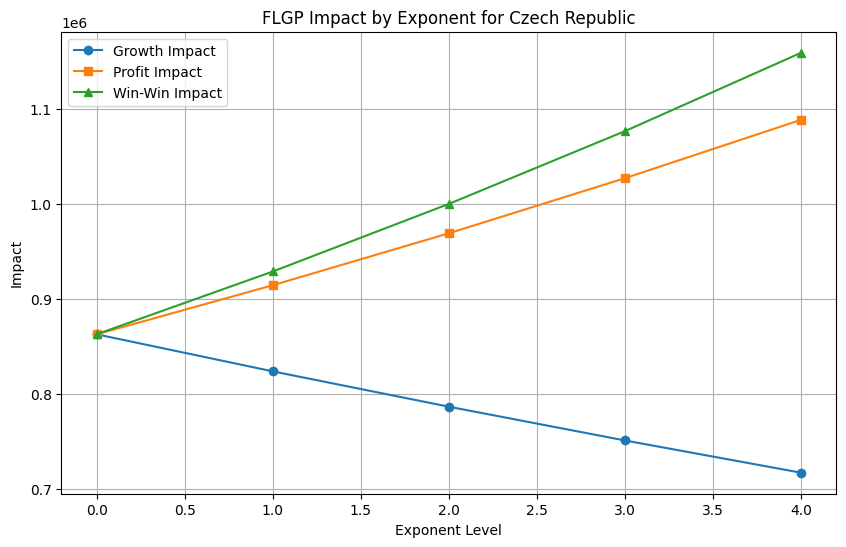

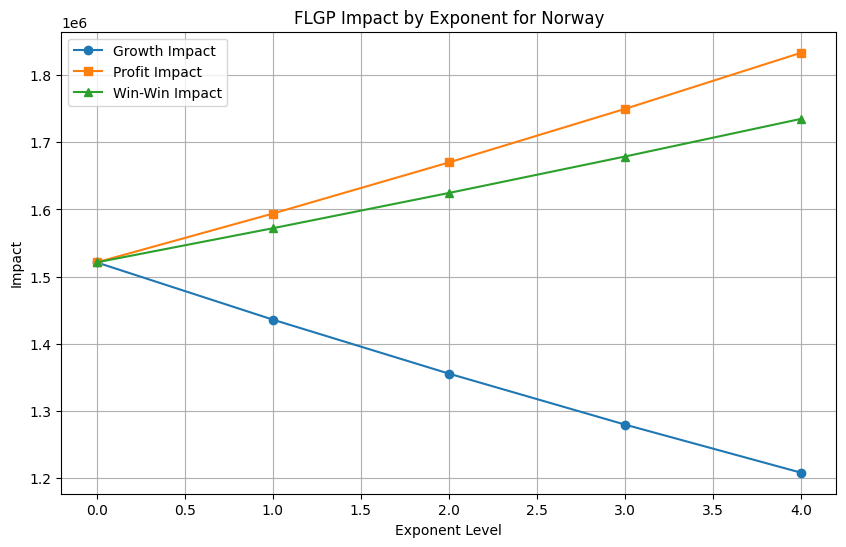

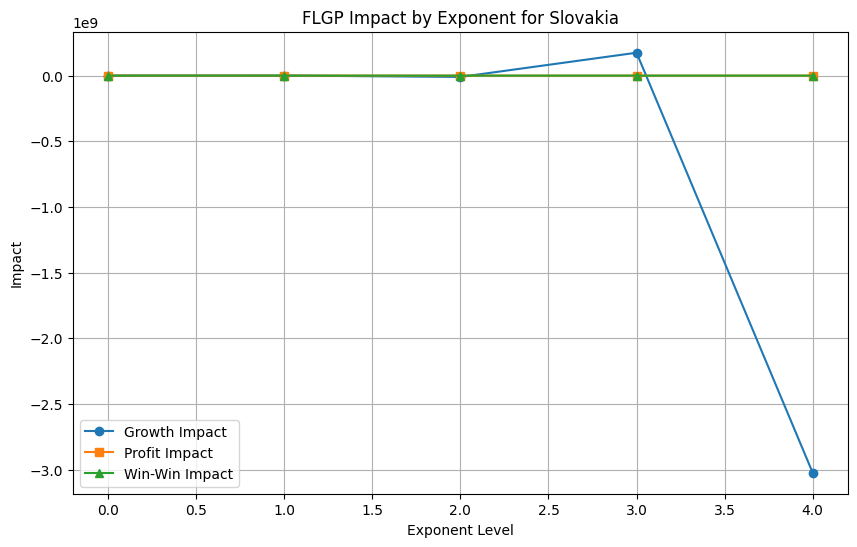

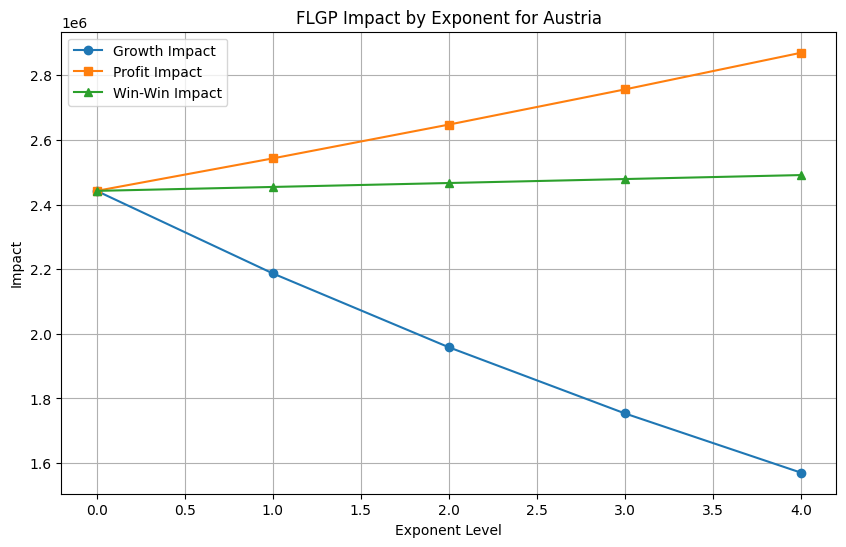

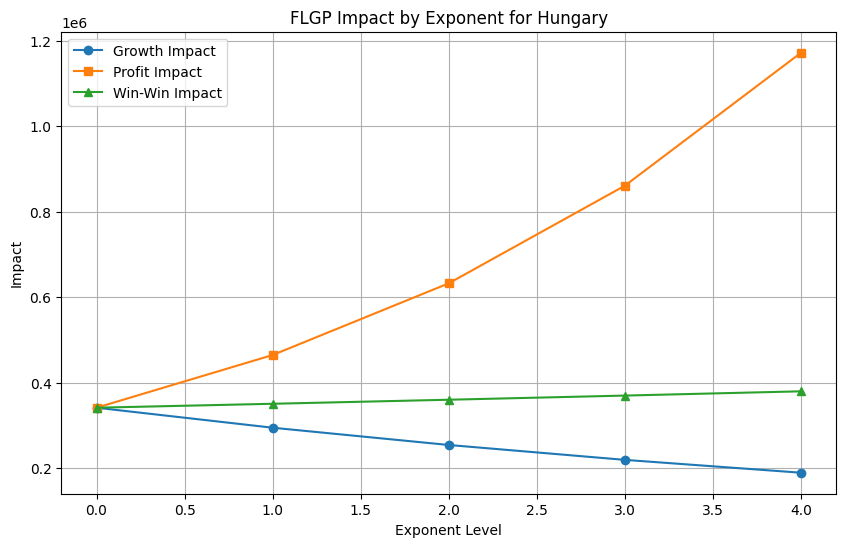

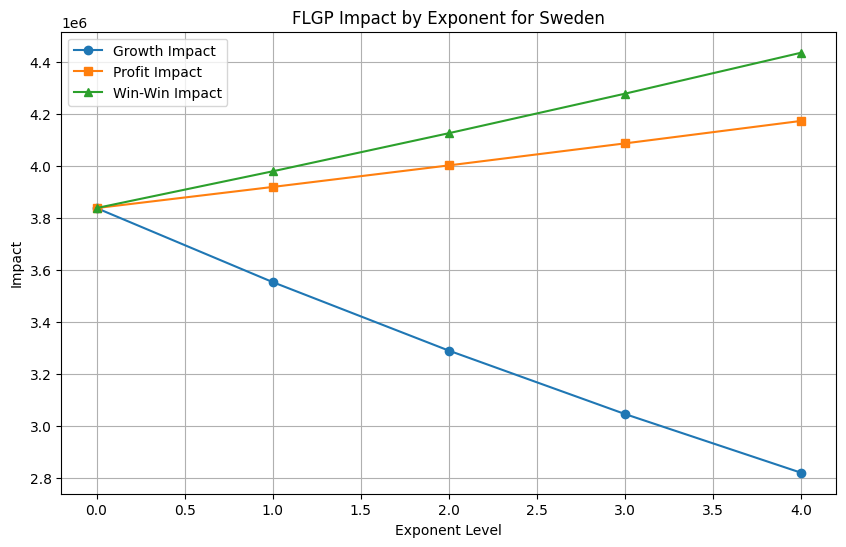

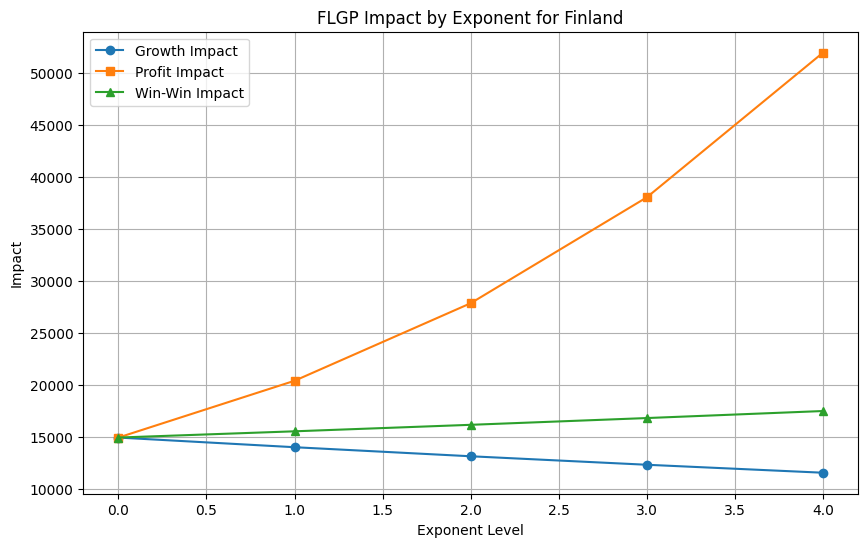

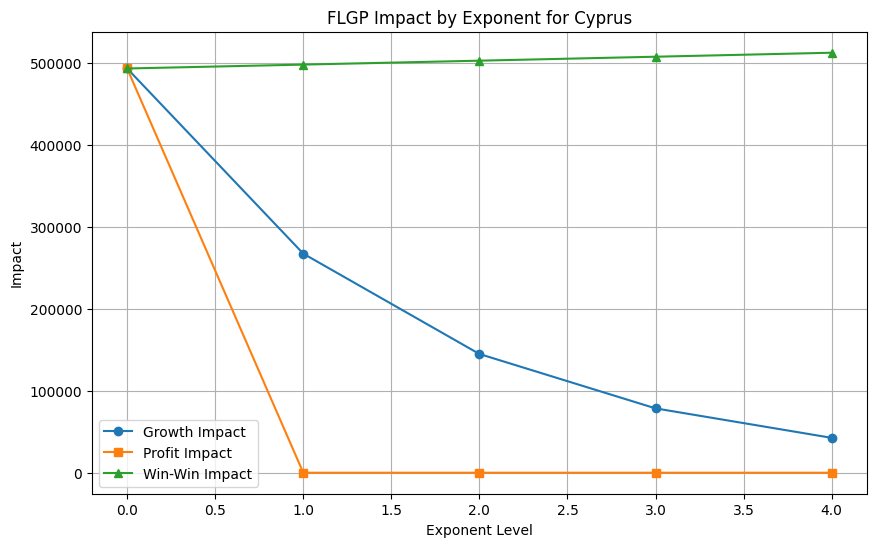

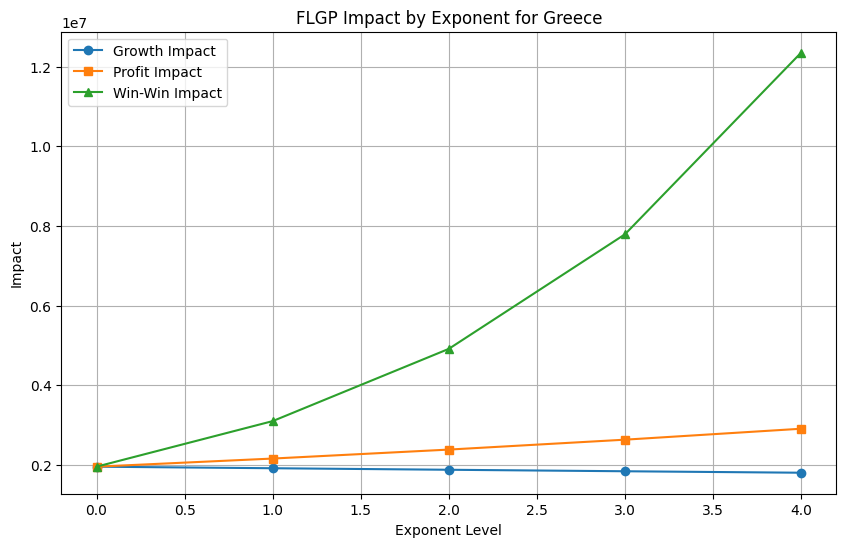

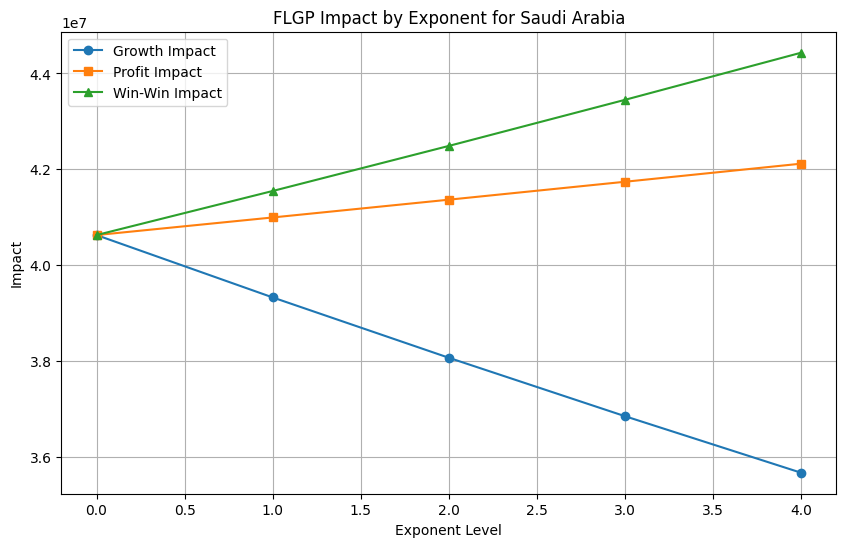

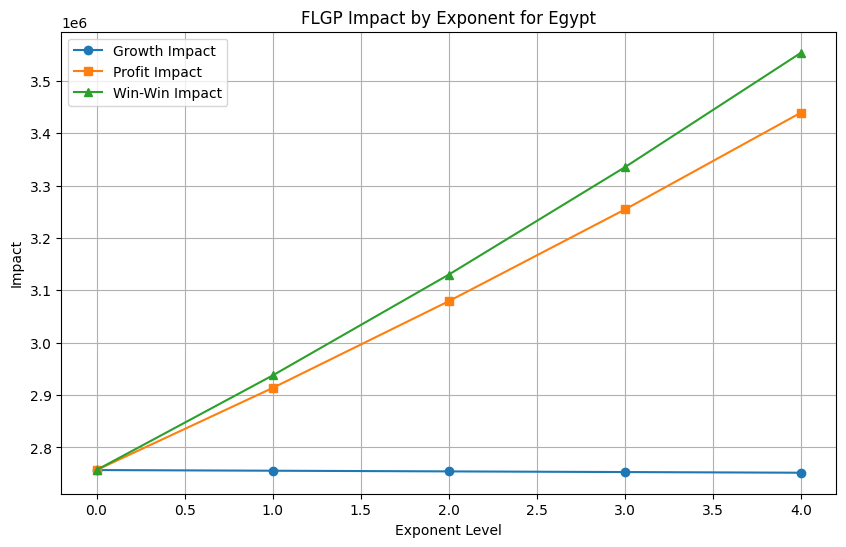

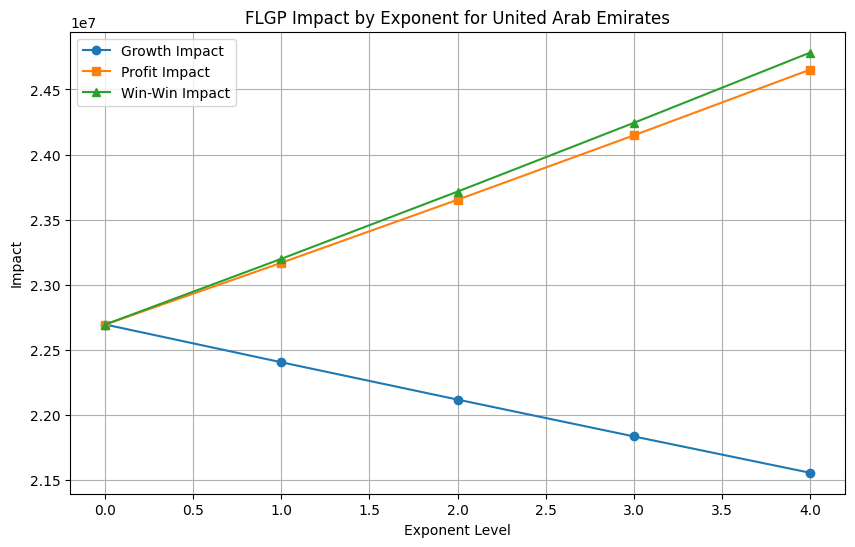

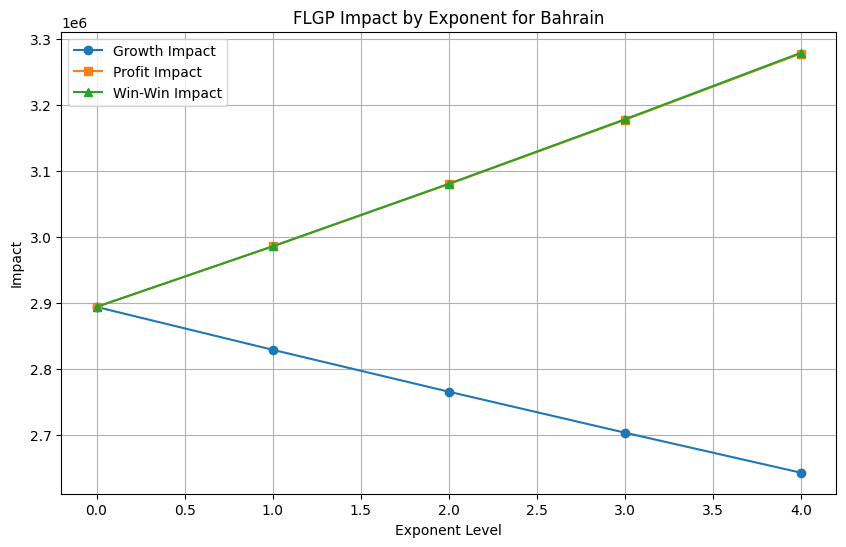

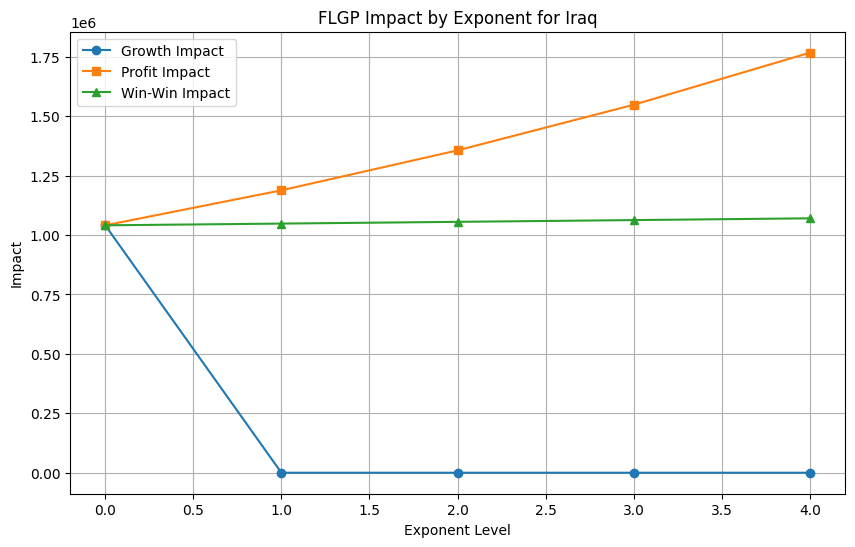

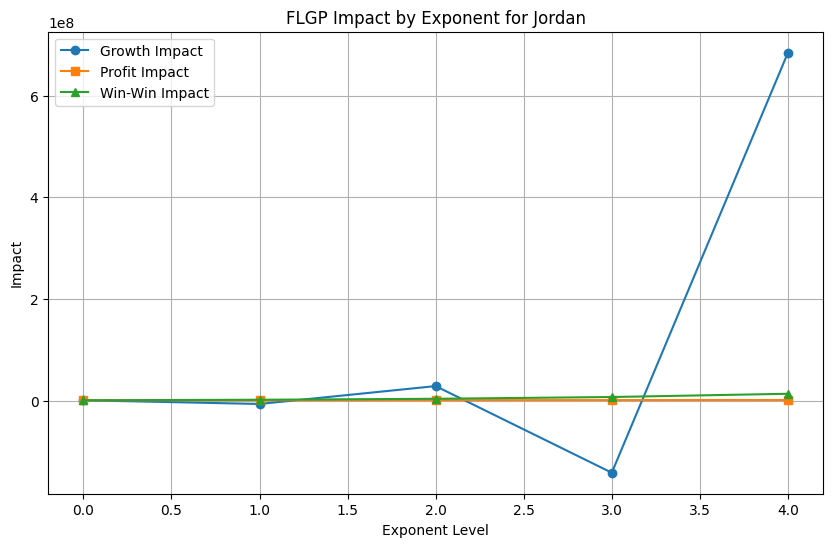

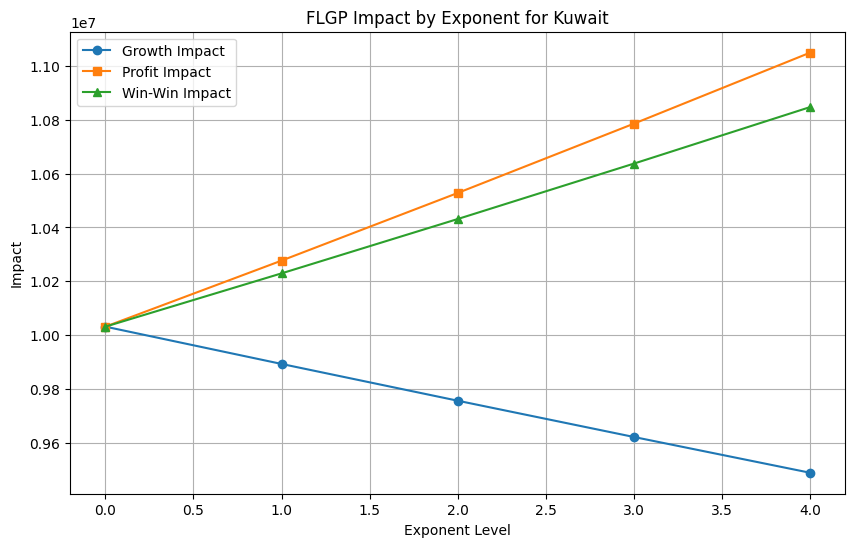

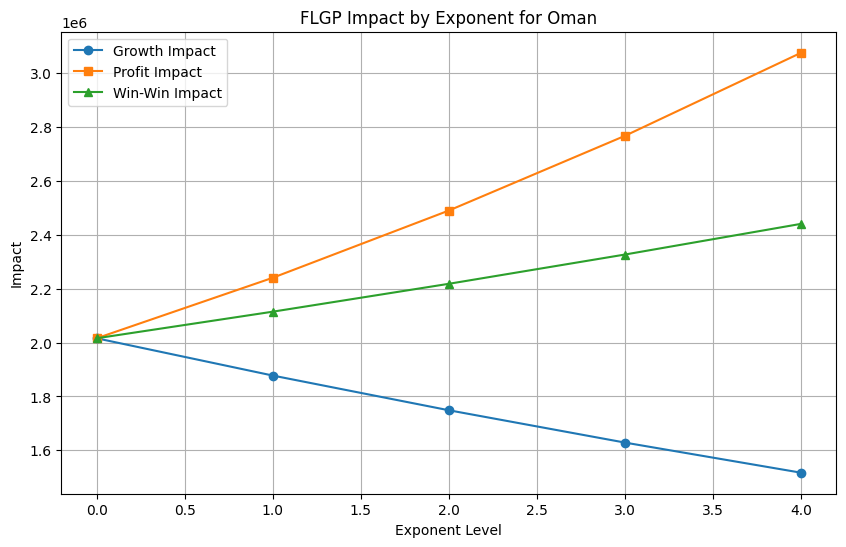

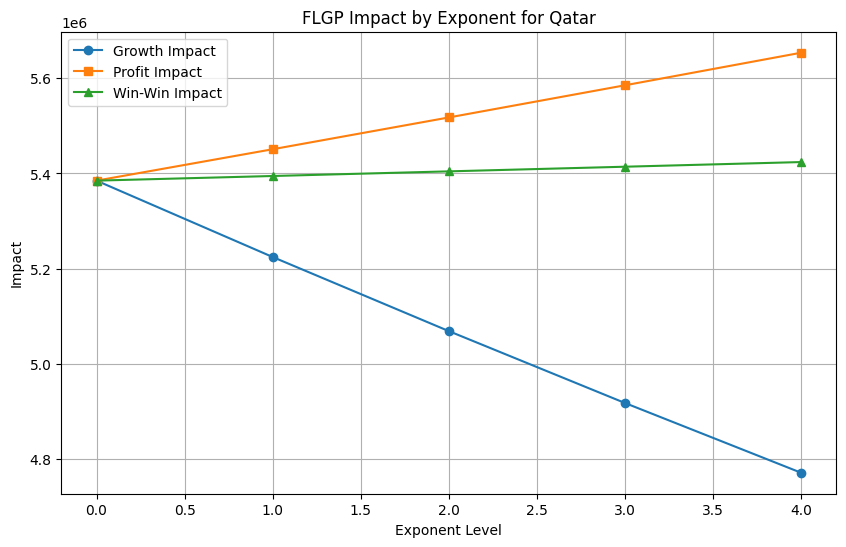

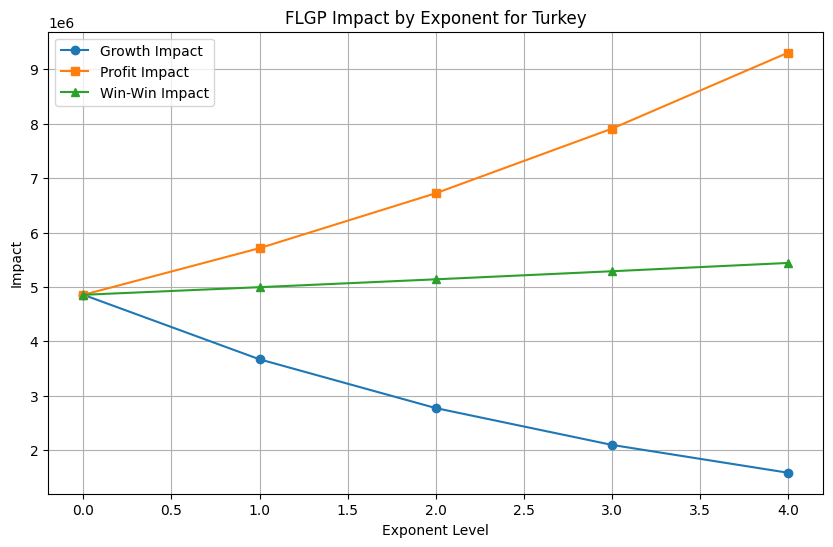

In [3074]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_exponent_impact(row, max_exponent, increment=1):
    exponents = np.arange(0, max_exponent + increment, increment)
    
    growth_impacts = []
    profit_impacts = []
    win_impacts = []

    for exp in exponents:
        try:
            # Ensure no missing values
            if None in (row['avg_flgp_per_user'], 
                        row['flgpu_perc_change_CPiO - Growth at a Cost'], 
                        row['avg_total_active_users']):
                raise ValueError("Missing data in row")
            
            # Growth impact calculation
            growth_base = row['flgpu_perc_change_CPiO - Growth at a Cost']
            if row['avg_flgp_per_user'] < 0:
                growth_adjusted_base = (1 / growth_base) ** exp
            else:
                growth_adjusted_base = growth_base ** exp
            growth_impact = (
                row['avg_flgp_per_user'] * 
                growth_adjusted_base * 
                row['avg_total_active_users']
            )
            growth_impacts.append(growth_impact)
            
            # Profit impact calculation
            profit_base = row['flgpu_perc_change_MPOL - Profit at a Cost']
            if row['avg_flgp_per_user'] < 0:
                profit_adjusted_base = (1 / profit_base) ** exp
            else:
                profit_adjusted_base = profit_base ** exp
            profit_impact = (
                row['avg_flgp_per_user'] * 
                profit_adjusted_base * 
                row['avg_total_active_users']
            )
            profit_impacts.append(profit_impact)
            
            # Win impact calculation
            win_base = row['flgpu_perc_change_Win-Win']
            if row['avg_flgp_per_user'] < 0:
                win_adjusted_base = (1 / win_base) ** exp
            else:
                win_adjusted_base = win_base ** exp
            win_impact = (
                row['avg_flgp_per_user'] * 
                win_adjusted_base * 
                row['avg_total_active_users']
            )
            win_impacts.append(win_impact)

        except TypeError as e:
            print(f"TypeError encountered for row: {row}, error: {e}")
        except ValueError as e:
            print(f"ValueError encountered for row: {row}, error: {e}")
    
    return exponents, growth_impacts, profit_impacts, win_impacts
      
    
    # growth_impacts = []
    # profit_impacts = []
    # win_impacts = []
    
    # for exp in exponents:
    #     # growth_impacts.append(row['avg_flgp_per_user'] * (np.abs(row['flgpu_perc_change_CPiO - Growth at a Cost'] * discount_factor) ** exp) * row['avg_total_active_users'])
    #     # profit_impacts.append(row['avg_flgp_per_user'] * (np.abs(row['flgpu_perc_change_MPOL - Profit at a Cost'] * discount_factor) ** exp) * row['avg_total_active_users'])
    #     # win_impacts.append(row['avg_flgp_per_user'] * (np.abs(row['flgpu_perc_change_Win-Win'] * discount_factor) ** exp) * row['avg_total_active_users'])

    #     growth_impacts.append(row['avg_flgp_per_user'] * (row['flgpu_perc_change_CPiO - Growth at a Cost'] * discount_factor) ** exp) * row['avg_total_active_users']
    #     profit_impacts.append(row['avg_flgp_per_user'] * (row['flgpu_perc_change_MPOL - Profit at a Cost'] * discount_factor) ** exp) * row['avg_total_active_users']
    #     win_impacts.append(row['avg_flgp_per_user'] * (row['flgpu_perc_change_Win-Win'] * discount_factor) ** exp) * row['avg_total_active_users']

    # return exponents, growth_impacts, profit_impacts, win_impacts

# Visualization of impacts per exponent by country
countries = final_df['country_name'].unique()
max_exponent = 4  # Adjust as needed

for country in countries:
    country_data = final_df[final_df['country_name'] == country].iloc[0]
    exponents, growth_impacts, profit_impacts, win_impacts = calculate_exponent_impact(country_data, max_exponent)
    
    plt.figure(figsize=(10, 6))
    plt.plot(exponents, growth_impacts, marker='o', linestyle='-', label="Growth Impact")
    plt.plot(exponents, profit_impacts, marker='s', linestyle='-', label="Profit Impact")
    plt.plot(exponents, win_impacts, marker='^', linestyle='-', label="Win-Win Impact")
    
    plt.title(f"FLGP Impact by Exponent for {country}")
    plt.xlabel("Exponent Level")
    plt.ylabel("Impact")
    plt.legend()
    plt.grid(True)
    plt.show()


In [3075]:
# def total_impact(df):
    
#     # Convert 'Month' column to datetime format and extract year and month
#     df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')
#     df['Year_o'] = df['Month'].dt.year
#     df['Month_o'] = df['Month'].dt.month

#     # Pivot the table
#     df_tmp = df.pivot_table(
#         index=['entity_id', 'Month_o'],
#         columns='Year_o',
#         values=['fully_loaded_gross_profit_eur', 'total_orders'],
#         fill_value=0
#     ).reset_index()

#     # Flatten column names
#     df_tmp.columns = [f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in df_tmp.columns]

#     # Calculate total FLGP and total orders based on conditions
#     df_tmp['total_flgp'] = np.where(
#         df_tmp['fully_loaded_gross_profit_eur_2024'] != 0, 
#         df_tmp['fully_loaded_gross_profit_eur_2024'], 
#         df_tmp['fully_loaded_gross_profit_eur_2023']
#     )
#     df_tmp['total_orders'] = np.where(
#         df_tmp['total_orders_2024'] != 0, 
#         df_tmp['total_orders_2024'], 
#         df_tmp['total_orders_2023']
#     )

#     # Group by 'entity_id' and aggregate the total orders and FLGP
#     result_df = df_tmp.groupby('entity_id').agg({'total_orders': 'sum', 'total_flgp': 'sum','total_orders_2023':'sum','total_orders_2024':'sum','fully_loaded_gross_profit_eur_2024':'sum','fully_loaded_gross_profit_eur_2023':'sum'}).reset_index()
    
#     return result_df


# impact_df = total_impact(seasonal_df)

In [3076]:
# # Convert the 'Month' column to datetime format and extract the year and month
# seasonal_df['Month'] = pd.to_datetime(seasonal_df['Month'], format='%Y-%m-%d')
# seasonal_df['Year_o'] = seasonal_df['Month'].dt.year
# seasonal_df['Month_o'] = seasonal_df['Month'].dt.month

# # Create a pivot table for gross profit and total orders by region, brand, entity, and country, indexed by year
# df_tmp = seasonal_df.pivot_table(
#     index=['entity_id','Month_o'],
#     columns='Year_o',
#     values=['fully_loaded_gross_profit_eur', 'total_orders'],
#     fill_value=0
# ).reset_index()

# # Flatten the MultiIndex columns to make them single-level with descriptive names
# df_tmp.columns = [
#     f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in df_tmp.columns
# ]

# df_tmp

In [3077]:
# seasonal_df.columns

In [3078]:
# a = seasonal_df[seasonal_df['entity_id'] == 'YS_TR']

# def plot_line_chart(df, x_column, y_columns, title="Line Chart", xlabel="X-axis", ylabel="Y-axis"):
#     # Plot each specified y_column against the x_column
#     for y_column in y_columns:
#         plt.plot(df[x_column], df[y_column], label=y_column)
    
#     # Adding labels and title
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.title(title)
#     plt.legend()  # Shows a legend for each line

#     # Display the chart
#     plt.show()

# # Example usage:
# # Assume 'Month' is the x-axis column and ['FLGP', 'Orders'] are y-axis columns
# plot_line_chart(a, x_column='Month', y_columns='fully_loaded_gross_profit_eur', title="FLGP and Orders Over Time", xlabel="Month", ylabel="Values")


In [3079]:
# def calculate_growth_seasonality_forecast(df):
    
#     df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')
#     df['Year_o'] = df['Month'].dt.year
#     df['Month_o'] = df['Month'].dt.month

#     # Pivot to have separate columns for each year
#     df_tmp = df.pivot_table(
#         index=['entity_id', 'Month_o'],
#         columns='Year_o',
#         values=['fully_loaded_gross_profit_eur', 'total_orders', 'total_users'],
#         fill_value=0
#     ).reset_index()

#     # Flatten columns
#     df_tmp.columns = [f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in df_tmp.columns]

#     # Calculate growth rates
#     df_tmp['flgp_growth_rate'] = ((df_tmp['fully_loaded_gross_profit_eur_2024'] - df_tmp['fully_loaded_gross_profit_eur_2023']) / abs(df_tmp['fully_loaded_gross_profit_eur_2023']))
#     df_tmp['orders_growth_rate'] = ((df_tmp['total_orders_2024'] - df_tmp['total_orders_2023']) / abs(df_tmp['total_orders_2023']))
#     df_tmp['users_growth_rate'] = ((df_tmp['total_users_2024'] - df_tmp['total_users_2023']) / abs(df_tmp['total_users_2023']))

#     # Calculate annual averages for growth rates
#     annual_avg_growth_rate = df_tmp.groupby('entity_id')[
#         ['flgp_growth_rate', 'orders_growth_rate', 'users_growth_rate']
#     ].mean().abs()
#     annual_avg_growth_rate.columns = ['avg_FLGP_growth', 'avg_orders_growth', 'avg_user_growth']

#     # Merge annual averages back to the main DataFrame
#     df_tmp = df_tmp.merge(annual_avg_growth_rate, on='entity_id')

#     # Calculate annual averages for 2023 metrics
#     annual_avg_2023_entity = df_tmp.groupby('entity_id')[
#         ['fully_loaded_gross_profit_eur_2023', 'total_orders_2023', 'total_users_2023']
#     ].mean().abs()
#     annual_avg_2023_entity.columns = ['annual_avg_FLGP_2023', 'annual_avg_orders_2023', 'annual_avg_users_2023']

#     # Merge annual averages back to the main DataFrame
#     df_tmp = df_tmp.merge(annual_avg_2023_entity, on='entity_id')

#     # Calculate seasonality indices for 2023
#     df_tmp['flgp_seasonality_index_2023'] = (df_tmp['fully_loaded_gross_profit_eur_2023'].abs()) / df_tmp['annual_avg_FLGP_2023']
#     df_tmp['orders_seasonality_index_2023'] = (df_tmp['total_orders_2023'].abs()) / df_tmp['annual_avg_orders_2023']
#     df_tmp['users_seasonality_index_2023'] = (df_tmp['total_users_2023'].abs()) / df_tmp['annual_avg_users_2023']

#     # Calculate final 2024 values for November and December based on seasonality indices and growth rates
#     for month in [11, 12]:
#         df_tmp.loc[df_tmp['Month_o'] == month, 'fully_loaded_gross_profit_eur_2024'] = (
#             df_tmp.loc[df_tmp['Month_o'] == month, 'fully_loaded_gross_profit_eur_2023'] *
#             df_tmp.loc[df_tmp['Month_o'] == month, 'flgp_seasonality_index_2023'] *
#             (1 + df_tmp.loc[df_tmp['Month_o'] == month, 'avg_FLGP_growth'])
#         )
#         df_tmp.loc[df_tmp['Month_o'] == month, 'total_orders_2024'] = (
#             df_tmp.loc[df_tmp['Month_o'] == month, 'total_orders_2023'] *
#             df_tmp.loc[df_tmp['Month_o'] == month, 'orders_seasonality_index_2023'] *
#             (1 + df_tmp.loc[df_tmp['Month_o'] == month, 'avg_orders_growth'])
#         )
#         df_tmp.loc[df_tmp['Month_o'] == month, 'total_users_2024'] = (
#             df_tmp.loc[df_tmp['Month_o'] == month, 'total_users_2023'] *
#             df_tmp.loc[df_tmp['Month_o'] == month, 'users_seasonality_index_2023'] *
#             (1 + df_tmp.loc[df_tmp['Month_o'] == month, 'avg_user_growth'])
#         )

#     df_tmp['total_flgp'] = df_tmp['fully_loaded_gross_profit_eur_2024'].sum()
#     df_tmp['total_orders'] = df_tmp['total_orders_2024'].sum()
#     df_tmp['total_users'] = df_tmp['total_users_2024'].sum()

#     return df_tmp

# impact_df = calculate_growth_seasonality_forecast(seasonal_df)

In [3080]:
# import pandas as pd

# def calculate_growth_seasonality_forecast(df):
#     # Ensure dates are correctly formatted
#     df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')
#     df['Year_o'] = df['Month'].dt.year
#     df['Month_o'] = df['Month'].dt.month

#     # Pivot data so each metric has columns for 2023 and 2024 by month
#     df_pivot = df.pivot_table(
#         index=['entity_id', 'Month_o'],
#         columns='Year_o',
#         values=['fully_loaded_gross_profit_eur', 'total_orders', 'total_users'],
#         fill_value=0
#     ).reset_index()

#     # Flatten columns
#     df_pivot.columns = [f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in df_pivot.columns]

#     for month in [11, 12]:
#         # Adjust fully_loaded_gross_profit_eur_2024 based on the difference from 2023
#         df_pivot.loc[df_pivot['Month_o'] == month, 'fully_loaded_gross_profit_eur_2024'] = (
#             df_pivot.loc[df_pivot['Month_o'] == month - 1, 'fully_loaded_gross_profit_eur_2024'].values +
#             (df_pivot.loc[df_pivot['Month_o'] == month, 'fully_loaded_gross_profit_eur_2023'].values -
#              df_pivot.loc[df_pivot['Month_o'] == (month - 1), 'fully_loaded_gross_profit_eur_2023'].values)
#         )
        
#         # Adjust total_orders_2024 based on the difference from 2023
#         df_pivot.loc[df_pivot['Month_o'] == month, 'total_orders_2024'] = (
#             df_pivot.loc[df_pivot['Month_o'] == month - 1, 'total_orders_2024'].values +
#             (df_pivot.loc[df_pivot['Month_o'] == month, 'total_orders_2023'].values -
#              df_pivot.loc[df_pivot['Month_o'] == (month - 1), 'total_orders_2023'].values)
#         )

#         # Adjust total_users_2024 based on the difference from 2023
#         df_pivot.loc[df_pivot['Month_o'] == month, 'total_users_2024'] = (
#             df_pivot.loc[df_pivot['Month_o'] == month - 1, 'total_users_2024'].values +
#             (df_pivot.loc[df_pivot['Month_o'] == month, 'total_users_2023'].values -
#              df_pivot.loc[df_pivot['Month_o'] == (month - 1), 'total_users_2023'].values)
#         )
    
#     # Calculate totals for 2024
#     df_pivot['total_flgp'] = df_pivot['fully_loaded_gross_profit_eur_2024']
#     df_pivot['total_orders'] = df_pivot['total_orders_2024']
#     df_pivot['total_users'] = df_pivot['total_users_2024']

#     result_df = df_pivot.groupby('entity_id').agg({'total_orders': 'sum', 'total_flgp': 'sum','total_orders_2023':'sum','total_orders_2024':'sum','fully_loaded_gross_profit_eur_2023':'sum','fully_loaded_gross_profit_eur_2024':'sum'}).reset_index()
    
#     return result_df

# impact_df = calculate_growth_seasonality_forecast(seasonal_df)

In [3081]:
def calculate_yoy_growth(df, target_year=2024, base_year=2023):
    """
    Calculate Year-over-Year (YoY) growth for fully loaded gross profit, orders, and users.
    Fills missing target year values based on the average YoY growth for each entity.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with 'Month', 'entity_id', 'fully_loaded_gross_profit_eur',
                           'total_orders', and 'total_users' columns.
        target_year (int): The year for which we want to fill missing values (default is 2024).
        base_year (int): The base year for calculating YoY growth (default is 2023).
    
    Returns:
        pd.DataFrame: A DataFrame with aggregated total values for each entity in both the base and target years.
    """
    df = df.copy()

    # Extract month and year from the date column
    df['Month_o'] = pd.to_datetime(df['Month']).dt.month
    df['Year_o'] = pd.to_datetime(df['Month']).dt.year

    # Initialize an empty DataFrame to store results for all entities
    all_entities_results = pd.DataFrame()

    # Get unique entities
    entities = df['entity_id'].unique()

    # Loop through each entity to calculate metrics and fill missing target year values
    for entity in entities:
        # Filter data for the current entity
        entity_df = df[df['entity_id'] == entity]

        pivot_df = entity_df.pivot_table(
            index=['entity_id', 'Month_o'],
            columns='Year_o', 
            values=['fully_loaded_gross_profit_eur', 'total_orders', 'total_users'], 
            fill_value=0
        ).reset_index()

        # Flatten the multi-level columns to a single level
        pivot_df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in pivot_df.columns]

        pivot_df.rename(columns={'entity_id_': 'entity_id'}, inplace = True)

        # Calculate percentage change for each metric
        pivot_df["profit_yoy_change"] = np.where(
            pivot_df[f"fully_loaded_gross_profit_eur_{target_year}"] != 0,
            ((pivot_df[f"fully_loaded_gross_profit_eur_{target_year}"] - pivot_df[f"fully_loaded_gross_profit_eur_{base_year}"]) /
             pivot_df[f"fully_loaded_gross_profit_eur_{base_year}"]),
            np.nan
        )
        
        pivot_df["orders_yoy_change"] = np.where(
            pivot_df[f"total_orders_{target_year}"] != 0,
            ((pivot_df[f"total_orders_{target_year}"] - pivot_df[f"total_orders_{base_year}"]) /
             pivot_df[f"total_orders_{base_year}"]),
            np.nan
        )

        pivot_df["users_yoy_change"] = np.where(
            pivot_df[f"total_users_{target_year}"] != 0,
            ((pivot_df[f"total_users_{target_year}"] - pivot_df[f"total_users_{base_year}"]) /
             pivot_df[f"total_users_{base_year}"]),
            np.nan
        )

        # Calculate average YoY changes
        average_yoy_profit = pivot_df["profit_yoy_change"].mean()
        average_yoy_orders = pivot_df["orders_yoy_change"].mean()
        average_yoy_users = pivot_df["users_yoy_change"].mean()

        # Fill missing target year values based on average YoY change
        pivot_df[f'fully_loaded_gross_profit_eur_{target_year}'] = np.where(
            pivot_df[f'fully_loaded_gross_profit_eur_{target_year}'] == 0,
            pivot_df[f'fully_loaded_gross_profit_eur_{base_year}'] * (1 + average_yoy_profit),
            pivot_df[f'fully_loaded_gross_profit_eur_{target_year}']
        )
        
        pivot_df[f'total_orders_{target_year}'] = np.where(
            pivot_df[f'total_orders_{target_year}'] == 0,
            pivot_df[f'total_orders_{base_year}'] * (1 + average_yoy_orders),
            pivot_df[f'total_orders_{target_year}']
        )
        
        pivot_df[f'total_users_{target_year}'] = np.where(
            pivot_df[f'total_users_{target_year}'] == 0,
            pivot_df[f'total_users_{base_year}'] * (1 + average_yoy_users),
            pivot_df[f'total_users_{target_year}']
        )

        all_entities_results = pd.concat([all_entities_results, pivot_df], ignore_index=True)

    # Aggregate results for each entity
    result_df = all_entities_results.groupby('entity_id').agg({
        f'total_orders_{base_year}': 'sum',
        f'total_orders_{target_year}': 'sum',
        f'fully_loaded_gross_profit_eur_{base_year}': 'sum',
        f'fully_loaded_gross_profit_eur_{target_year}': 'sum',
        f'total_users_{base_year}': 'sum',
        f'total_users_{target_year}': 'sum'
    }).reset_index()

    result_df['total_flgp'] = result_df['fully_loaded_gross_profit_eur_2024']
    result_df['total_orders'] = result_df['total_orders_2024']
    result_df['total_users'] = result_df['total_users_2024']

    return result_df


impact_df = calculate_yoy_growth(seasonal_df)

In [3082]:
# 271412.561886 - 165607.041072

In [3083]:
# impact_df.loc[(impact_df['entity_id'] == 'PY_HN') & (impact_df['Month_o'] == 12), 'fully_loaded_gross_profit_eur_2024'] = (332525 + 24423.462551000004 + 105805.52081399999)	

In [3084]:
# 670781.015804 - 634054.257370

In [3085]:
# for i in impact_df['entity_id'].unique():

#     a = impact_df[impact_df['entity_id'] == i]

#     def plot_line_chart(df, x_column, y_columns, title="Line Chart", xlabel="X-axis", ylabel="Y-axis"):
#         # Plot each specified y_column against the x_column
#         for y_column in y_columns:
#             plt.plot(df[x_column], df[y_column], label=y_column)
        
#         # Adding labels and title
#         plt.xlabel(xlabel)
#         plt.ylabel(ylabel)
#         plt.title(title)
#         plt.legend()  # Shows a legend for each line

#         # Display the chart
#         plt.show()

#     # Example usage:
#     # Assume 'Month' is the x-axis column and ['FLGP', 'Orders'] are y-axis columns
#     print(i)
#     plot_line_chart(a, x_column='Month_o', y_columns=['fully_loaded_gross_profit_eur_2023','fully_loaded_gross_profit_eur_2024'], title="FLGP and Orders Over Time", xlabel="Month", ylabel="Values")


In [3086]:
# df =  seasonal_df.copy()

# df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')
# df['Year_o'] = df['Month'].dt.year
# df['Month_o'] = df['Month'].dt.month

# df_tmp = df.pivot_table(
#     index=['entity_id', 'Month_o'],
#     columns='Year_o',
#     values=['fully_loaded_gross_profit_eur', 'total_orders','total_users'],
#     fill_value=0
# ).reset_index()

# df_tmp.columns = [f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in df_tmp.columns]

# df_tmp['flgp_growth_rate'] = ((df_tmp['fully_loaded_gross_profit_eur_2024'] - df_tmp['fully_loaded_gross_profit_eur_2023']) / abs(df_tmp['fully_loaded_gross_profit_eur_2023']))
# df_tmp['orders_growth_rate'] = ((df_tmp['total_orders_2024'] - df_tmp['total_orders_2023']) / abs(df_tmp['total_orders_2023']))
# df_tmp['users_growth_rate'] = ((df_tmp['total_users_2024'] - df_tmp['total_users_2023']) / abs(df_tmp['total_users_2023']))

# # Calculate seasonal index based on monthly averages
# df_tmp['flgp_average'] = (df_tmp['fully_loaded_gross_profit_eur_2023'] + df_tmp['fully_loaded_gross_profit_eur_2024']) / 2
# df_tmp['orders_average'] = (df_tmp['total_orders_2024'] + df_tmp['total_orders_2023']) / 2
# df_tmp['users_average'] = (df_tmp['total_users_2024'] + df_tmp['total_users_2023']) / 2

# annual_avg_FLGP = df_tmp['fully_loaded_gross_profit_eur'].mean()
# annual_avg_Orders = df_tmp['total_orders'].mean()
# annual_avg_Users = df_tmp['total_users'].mean()

# df_tmp['FLGP_Seasonal_Index'] = df_tmp['flgp_average'] / annual_avg_FLGP
# df_tmp['Orders_Seasonal_Index'] = df_tmp['orders_average'] / annual_avg_Orders
# df_tmp['Users_Seasonal_Index'] = df_tmp['users_average'] / annual_avg_Users



# df_tmp

In [3087]:
# import pandas as pd

# def forecast_for_entity(df_entity):
    
#     # Extract year and month components for ease of use
#     df_entity['Year'] = df_entity['Month'].dt.year
#     df_entity['Month_only'] = df_entity['Month'].dt.month
    
#     # Calculate YoY growth for FLGP, Orders, and Users
#     df_entity['FLGP_YoY_Growth'] = df_entity['fully_loaded_gross_profit_eur'].pct_change(periods=12)
#     df_entity['Orders_YoY_Growth'] = df_entity['total_orders'].pct_change(periods=12)
#     df_entity['Users_YoY_Growth'] = df_entity['total_users'].pct_change(periods=12)
    
#     # Calculate average YoY growth for January to October 2024
#     avg_flgp_yoy_growth = df_entity.loc[(df_entity['Month'] >= '2024-01-01') & (df_entity['Month'] <= '2024-10-01'), 'FLGP_YoY_Growth'].mean()
#     avg_orders_yoy_growth = df_entity.loc[(df_entity['Month'] >= '2024-01-01') & (df_entity['Month'] <= '2024-10-01'), 'Orders_YoY_Growth'].mean()
#     avg_users_yoy_growth = df_entity.loc[(df_entity['Month'] >= '2024-01-01') & (df_entity['Month'] <= '2024-10-01'), 'Users_YoY_Growth'].mean()
    
#     # Calculate seasonal index based on monthly averages
#     monthly_avg = df_entity.groupby('Month_only')[['fully_loaded_gross_profit_eur', 'total_orders', 'total_users']].mean()
#     annual_avg_FLGP = df_entity['fully_loaded_gross_profit_eur'].mean()
#     annual_avg_Orders = df_entity['total_orders'].mean()
#     annual_avg_Users = df_entity['total_users'].mean()
#     monthly_avg['FLGP_Seasonal_Index'] = monthly_avg['fully_loaded_gross_profit_eur'] / annual_avg_FLGP
#     monthly_avg['Orders_Seasonal_Index'] = monthly_avg['total_orders'] / annual_avg_Orders
#     monthly_avg['Users_Seasonal_Index'] = monthly_avg['total_users'] / annual_avg_Users
    
#     # Get the latest values for October 2024 as the base for forecasting
#     if '2024-10-01' in df_entity['Month'].astype(str).values:
#         latest_flgp = df_entity.loc[df_entity['Month'] == '2024-10-01', 'fully_loaded_gross_profit_eur'].values[0]
#         latest_orders = df_entity.loc[df_entity['Month'] == '2024-10-01', 'total_orders'].values[0]
#         latest_users = df_entity.loc[df_entity['Month'] == '2024-10-01', 'total_users'].values[0]
        
#         # Forecast for November and December using average YoY growth and seasonal index
#         nov_flgp_forecast = latest_flgp * (1 + avg_flgp_yoy_growth) * monthly_avg.loc[11, 'FLGP_Seasonal_Index']
#         dec_flgp_forecast = latest_flgp * (1 + avg_flgp_yoy_growth) * monthly_avg.loc[12, 'FLGP_Seasonal_Index']
        
#         nov_orders_forecast = latest_orders * (1 + avg_orders_yoy_growth) * monthly_avg.loc[11, 'Orders_Seasonal_Index']
#         dec_orders_forecast = latest_orders * (1 + avg_orders_yoy_growth) * monthly_avg.loc[12, 'Orders_Seasonal_Index']
        
#         nov_users_forecast = latest_users * (1 + avg_users_yoy_growth) * monthly_avg.loc[11, 'Users_Seasonal_Index']
#         dec_users_forecast = latest_users * (1 + avg_users_yoy_growth) * monthly_avg.loc[12, 'Users_Seasonal_Index']
#     else:
#         # If October data is missing, set forecasts as NaN
#         nov_flgp_forecast = dec_flgp_forecast = nov_orders_forecast = dec_orders_forecast = nov_users_forecast = dec_users_forecast = None

#     # Store the forecasted values
#     forecasts = {
#         'entity_id': df_entity['entity_id'].iloc[0],
#         'Month': ['2024-11-01', '2024-12-01'],
#         'YEAR': df_entity['Year'].iloc[0],
#         'fully_loaded_gross_profit_eur': [nov_flgp_forecast, dec_flgp_forecast],
#         'total_orders': [nov_orders_forecast, dec_orders_forecast],
#         'total_users': [nov_users_forecast, dec_users_forecast]
#     }
#     return pd.DataFrame(forecasts)
    
# # Apply the function to each entity group to get forecasted data
# forecast_df = seasonal_df.groupby('entity_id').apply(forecast_for_entity).reset_index(drop=True)

# # Concatenate the original seasonal_df with the forecast_df
# forecast_df_final = pd.concat([seasonal_df, forecast_df], ignore_index=True)

# forecast_df_final['flgpu_eur'] = forecast_df_final['fully_loaded_gross_profit_eur'] / forecast_df_final['total_users']
# forecast_df_final['orders_per_user'] = forecast_df_final['total_orders'] / forecast_df_final['total_users']

# forecast_df_final['Month'] = pd.to_datetime(forecast_df_final['Month'], format='%Y-%m-%d')

# forecast_df_final.dtypes

In [3088]:
# a = forecast_df_final[forecast_df_final['entity_id'] == 'FP_TH']

# def plot_line_chart(df, x_column, y_columns, title="Line Chart", xlabel="X-axis", ylabel="Y-axis"):
#     # Plot each specified y_column against the x_column
#     for y_column in y_columns:
#         plt.plot(df[x_column], df[y_column], label=y_column)
    
#     # Adding labels and title
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.title(title)
#     plt.legend()  # Shows a legend for each line

#     # Display the chart
#     plt.show()


# # Convert 'Month' to datetime format if needed and sort
# a['Month'] = pd.to_datetime(a['Month'], errors='coerce')  # Convert to datetime, handling errors
# a = a.sort_values(by='Month')  # Sort by Month column

# # Plotting function remains the same
# plot_line_chart(a, x_column='Month', y_columns=['flgpu_eur'])


In [3089]:
# seasonal_df

In [3095]:
# import pandas as pd

# # # Sample data (replace with actual data)
# # data = {
# #     'Month': pd.date_range(start='2023-01-01', end='2024-10-01', freq='MS'),
# #     'FLGP': [100000, 105000, 103000, 108000, 110000, 115000, 118000, 120000, 125000, 128000, 127000, 130000, 135000, 137000, 140000, 142000, 145000, 147000, 150000, 152000, 155000, 157000],
# #     'Orders': [2000, 2100, 2150, 2200, 2300, 2400, 2350, 2450, 2500, 2550, 2600, 2700, 2800, 2850, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600]
# # }
# # df = pd.DataFrame(data)

# df = seasonal_df.copy()

# # Calculate YoY growth for FLGP and Orders (2024 over 2023)
# df['Year'] = df['Month'].dt.year
# df['Month_only'] = df['Month'].dt.month

# # Shift values by 12 months for YoY calculation
# df['FLGP_YoY_Growth'] = df['fully_loaded_gross_profit_eur'].pct_change(periods=12) * 100
# df['Orders_YoY_Growth'] = df['total_orders'].pct_change(periods=12) * 100

# # Calculate seasonal index based on monthly averages
# monthly_avg = df.groupby('Month_only')[['fully_loaded_gross_profit_eur', 'total_orders']].mean()
# annual_avg_FLGP = df['fully_loaded_gross_profit_eur'].mean()
# annual_avg_Orders = df['total_orders'].mean()
# monthly_avg['FLGP_Seasonal_Index'] = monthly_avg['fully_loaded_gross_profit_eur'] / annual_avg_FLGP
# monthly_avg['Orders_Seasonal_Index'] = monthly_avg['total_orders'] / annual_avg_Orders

# # Forecast for November and December using YoY growth and seasonal index
# nov_flgp_forecast = df.loc[df['Month'] == '2024-10-01', 'fully_loaded_gross_profit_eur'].values[0] * (1 + 0.08) * monthly_avg.loc[11, 'FLGP_Seasonal_Index']
# dec_flgp_forecast = df.loc[df['Month'] == '2024-10-01', 'fully_loaded_gross_profit_eur'].values[0] * (1 + 0.08) * monthly_avg.loc[12, 'FLGP_Seasonal_Index']

# nov_orders_forecast = df.loc[df['Month'] == '2024-10-01', 'total_orders'].values[0] * (1 + 0.05) * monthly_avg.loc[11, 'Orders_Seasonal_Index']
# dec_orders_forecast = df.loc[df['Month'] == '2024-10-01', 'total_orders'].values[0] * (1 + 0.05) * monthly_avg.loc[12, 'Orders_Seasonal_Index']

# # Display the forecasted values
# forecasts = {
#     'Month': ['2024-11', '2024-12'],
#     'FLGP Forecast': [nov_flgp_forecast, dec_flgp_forecast],
#     'Orders Forecast': [nov_orders_forecast, dec_orders_forecast]
# }
# forecast_df = pd.DataFrame(forecasts)

# forecast_df

In [3096]:
impact_df['total_flgp'].sum()

1816218162.4860148

In [3097]:
(final_df['flgp_impact_incremental'].sum() / (impact_df['total_flgp'].sum())) * 100

(4.129967648748992+0.18469849559230522j)

In [3098]:
(final_df['orders_impact_incremental'].sum() / (impact_df['total_orders'].sum())) * 100

0.9891265964534386

In [3099]:
final_df[final_df['flgp_impact_incremental'] > 5000000]

region brand_name entity_id country_name  median_test_length_days  \
14  Americas  PedidosYa     PY_VE    Venezuela                     28.0   
34    Europe      eFood     EF_GR       Greece                     22.0   

    testing_capacity  avg_total_active_users  avg_flgp_per_user  \
14             11.79            1.652577e+05            0.78576   
34             15.00            2.387109e+06            0.81846   

    avg_orders_per_user  CPiO - Growth at a Cost  ...  orders_impact_growth  \
14             0.627320                      8.0  ...          1.213605e+05   
34             0.669809                      1.0  ...          1.716686e+06   

    orders_impact_profit  orders_impact_win  baseline_orders  \
14          9.541575e+04       1.140661e+05     1.036695e+05   
34          1.304205e+06       1.765383e+06     1.598908e+06   

    orders_impact_incremental                              flgp_impact_growth  \
14               19833.869014  4.247478e+04+0.000000e+                    00j   
34              -10450.840775  1.905010e+06+0.000000e+                    00j   

    flgp_impact_profit  flgp_impact_win  baseline_flgp  \
14        1.547485e+05     4.414344e+07   1.298529e+05   
34        3.633960e+06     1.957660e+07   1.953754e+06   

                           flgp_impact_incremental  
14  4.395110e+07+0.000000e+                    00j  
34  1.925430e+07+0.000000e+                    00j  

[2 rows x 52 columns]

In [3100]:
final_df[final_df['flgp_impact_incremental'] > 5000000]

region brand_name entity_id country_name  median_test_length_days  \
14  Americas  PedidosYa     PY_VE    Venezuela                     28.0   
34    Europe      eFood     EF_GR       Greece                     22.0   

    testing_capacity  avg_total_active_users  avg_flgp_per_user  \
14             11.79            1.652577e+05            0.78576   
34             15.00            2.387109e+06            0.81846   

    avg_orders_per_user  CPiO - Growth at a Cost  ...  orders_impact_growth  \
14             0.627320                      8.0  ...          1.213605e+05   
34             0.669809                      1.0  ...          1.716686e+06   

    orders_impact_profit  orders_impact_win  baseline_orders  \
14          9.541575e+04       1.140661e+05     1.036695e+05   
34          1.304205e+06       1.765383e+06     1.598908e+06   

    orders_impact_incremental                              flgp_impact_growth  \
14               19833.869014  4.247478e+04+0.000000e+                    00j   
34              -10450.840775  1.905010e+06+0.000000e+                    00j   

    flgp_impact_profit  flgp_impact_win  baseline_flgp  \
14        1.547485e+05     4.414344e+07   1.298529e+05   
34        3.633960e+06     1.957660e+07   1.953754e+06   

                           flgp_impact_incremental  
14  4.395110e+07+0.000000e+                    00j  
34  1.925430e+07+0.000000e+                    00j  

[2 rows x 52 columns]

In [3101]:
print(impact_df['total_orders'].sum() , impact_df['total_flgp'].sum())

1353735917.2825894 1816218162.4860148


In [3102]:
impact_df_final = pd.merge(final_df, impact_df, on='entity_id', how='left')

In [3103]:
impact_df_final['total_flgp_target'] = impact_df_final['total_flgp'] + impact_df_final['flgp_impact_incremental']
impact_df_final['total_orders_target'] = impact_df_final['total_orders'] + impact_df_final['orders_impact_incremental']
impact_df_final['flgp_yoy_2024'] = (impact_df_final['fully_loaded_gross_profit_eur_2024'] - impact_df_final['fully_loaded_gross_profit_eur_2023']) / impact_df_final['fully_loaded_gross_profit_eur_2023']
impact_df_final['orders_yoy_2024'] = (impact_df_final['total_orders_2024'] - impact_df_final['total_orders_2023']) / impact_df_final['total_orders_2023']



In [3104]:
impact_df_final.to_csv('combined_targets.csv', index=False)

In [3105]:
impact_df_final[impact_df_final['country_name'] == 'Slovakia']['flgp_impact_incremental']

28   -8.042876e+05+2.981137e+                    06j
Name: flgp_impact_incremental, dtype: complex128

In [3106]:
3395973

3395973

In [3107]:
summary_df = impact_df_final.groupby('brand_name').agg({'total_orders_target':'sum','total_flgp_target':'sum','flgp_impact_incremental':'sum','orders_impact_incremental':'sum','fully_loaded_gross_profit_eur_2023':'sum','fully_loaded_gross_profit_eur_2024':'sum','total_orders_2024':'sum','total_orders_2023':'sum'}).reset_index()

# Calculate the total for each column in summary_df, excluding 'brand_name'
totals = summary_df[['total_orders_target', 'total_flgp_target', 'flgp_impact_incremental', 
                     'orders_impact_incremental', 'fully_loaded_gross_profit_eur_2023', 
                     'fully_loaded_gross_profit_eur_2024', 'total_orders_2024', 
                     'total_orders_2023']].sum()

# Convert the totals to a DataFrame row
totals_df = pd.DataFrame([totals], columns=totals.index)

# Add a 'brand_name' for the totals row
totals_df.insert(0, 'brand_name', 'Total')

# Append the totals row to the summary_df
summary_df = pd.concat([summary_df, totals_df], ignore_index=True)

# Display the summary DataFrame with totals row
summary_df['perc_flgp'] = summary_df['flgp_impact_incremental'] / summary_df['total_flgp_target']
summary_df['perc_orders'] = summary_df['orders_impact_incremental'] / summary_df['total_orders_target']

summary_df


brand_name  total_orders_target  \
0        Foodora         5.135887e+07   
1      Foodpanda         5.021532e+08   
2          Foody         5.151233e+06   
3  HungerStation         1.608043e+08   
4      PedidosYa         2.004782e+08   
5        Talabat         3.105926e+08   
6    Yemeksepeti         1.155585e+08   
7          eFood         2.102932e+07   
8          Total         1.367126e+09   

                                total_flgp_target  \
0  1.014851e+08+2.981137e+                    06j   
1  3.069585e+08+0.000000e+                    00j   
2  6.318746e+06+0.000000e+                    00j   
3  5.286359e+08+0.000000e+                    00j   
4  2.691277e+08+0.000000e+                    00j   
5  5.831853e+08+3.733902e+                    05j   
6  4.990972e+07+0.000000e+                    00j   
7  4.560645e+07+0.000000e+                    00j   
8  1.891227e+09+3.354528e+                    06j   

                          flgp_impact_incremental  orders_impact_incremental  \
0 -1.351605e+06+2.981137e+                    06j               7.861108e+05   
1  1.775294e+06+0.000000e+                    00j               8.000420e+06   
2 -3.172468e+05+0.000000e+                    00j               9.109128e+03   
3 -1.312221e+06+0.000000e+                    00j               1.359291e+06   
4  4.589893e+07+0.000000e+                    00j               1.586590e+06   
5  7.748152e+06+3.733902e+                    05j               1.243931e+06   
6  3.313614e+06+0.000000e+                    00j               4.151608e+05   
7  1.925430e+07+0.000000e+                    00j              -1.045084e+04   
8  7.500922e+07+3.354528e+                    06j               1.339016e+07   

   fully_loaded_gross_profit_eur_2023  fully_loaded_gross_profit_eur_2024  \
0                        1.166665e+08                        1.028367e+08   
1                        3.316111e+08                        3.051832e+08   
2                        2.529987e+06                        6.635993e+06   
3                        4.253043e+08                        5.299481e+08   
4                        2.150745e+08                        2.232288e+08   
5                        4.156088e+08                        5.754371e+08   
6                        1.996776e+06                        4.659610e+07   
7                        3.586599e+06                        2.635215e+07   
8                        1.512378e+09                        1.816218e+09   

   total_orders_2024  total_orders_2023           perc_flgp  perc_orders  
0       5.057276e+07         41949707.0 -0.012445+0.029741j     0.015306  
1       4.941528e+08        548328397.0  0.005783+0.000000j     0.015932  
2       5.142124e+06          2641885.0 -0.050207+0.000000j     0.001768  
3       1.594450e+08        142865673.0 -0.002482+0.000000j     0.008453  
4       1.988916e+08        174698206.0  0.170547+0.000000j     0.007914  
5       3.093486e+08        232334442.0  0.013286+0.000632j     0.004005  
6       1.151433e+08         33035636.0  0.066392+0.000000j     0.003593  
7       2.103977e+07          8404450.0  0.422184+0.000000j    -0.000497  
8       1.353736e+09       1184258396.0  0.039665+0.001703j     0.009794

In [3108]:
52888790

52888790

In [3109]:
19254300

19254300

In [3110]:
summary_df.to_csv('summary_impact.csv', index=False)

In [3111]:
# # Convert 'Year' column in seasonal_df to string format
# seasonal_df['Year'] = seasonal_df['Year'].astype(str)

# # Filter seasonal_df for the year 2023-01-01 and group by 'brand_name' for profit and order sums
# seasonal_summary = seasonal_df[seasonal_df['Year'] == '2023-01-01'] \
#     .groupby('brand_name') \
#     .agg(
#         total_fully_loaded_gross_profit=('fully_loaded_gross_profit_eur', 'sum'),
#         total_orders=('total_orders', 'sum')
#     ).reset_index()

# # Group final_df by 'brand_name' to summarize FLGP and order targets
# target_summary = final_df.groupby('brand_name') \
#     .agg(
#         total_flgp_target_win=('flgp_impact_final', 'sum'),
#         total_order_target_win=('orders_impact_final', 'sum')
#     ).reset_index()

# # Merge the summaries on 'brand_name' and calculate percentage of targets met
# merged_summary = pd.merge(seasonal_summary, target_summary, on='brand_name', how='left')
# merged_summary['flgp_target_percentage'] = merged_summary['total_flgp_target_win'] / merged_summary['total_fully_loaded_gross_profit']
# merged_summary['orders_target_percentage'] = merged_summary['total_order_target_win'] / merged_summary['total_orders']

# merged_summary

In [3112]:
# discount_factor = 1  # Equivalent to the discount factor in Method 3

# # Define functions to calculate each impact with discount factor exponentiation for each row (Method 3)
# def calculate_impact_growth_method(row):
#     return (
#         row['avg_flgp_per_user'] * 
#         (np.real((row['flgpu_perc_change_CPiO - Growth at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_growth']))) * 
#         row['avg_total_active_users']
#     )

# def calculate_impact_profit_method(row):
#     return (
#         row['avg_flgp_per_user'] * 
#         (np.real((row['flgpu_perc_change_MPOL - Profit at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_profit']))) * 
#         row['avg_total_active_users']
#     )

# def calculate_impact_win_method(row):
#     return (
#         row['avg_flgp_per_user'] * 
#         (np.real((row['flgpu_perc_change_Win-Win']) ** (discount_factor * row['testing_capacity'] * row['percentage_win_win']))) * 
#         row['avg_total_active_users']
#     )

# # Apply the Method 3 functions to the DataFrame
# final_df['flgp_impact_growth'] = final_df.apply(calculate_impact_growth_method, axis=1)
# final_df['flgp_impact_profit'] = final_df.apply(calculate_impact_profit_method, axis=1)
# final_df['flgp_impact_win'] = final_df.apply(calculate_impact_win_method, axis=1)

# final_df['baseline_flgp'] = final_df['avg_total_active_users'] * final_df['avg_flgp_per_user']

# # Calculate the final impact using the results of the three calculated columns for Method 3
# final_df['flgp_impact_final'] = (final_df['flgp_impact_growth'] - final_df['baseline_flgp']) \
# + (final_df['flgp_impact_profit'] - final_df['baseline_flgp']) \
# + (final_df['flgp_impact_win'] - final_df['baseline_flgp'])

In [3113]:
# discount_factor = 1  # Equivalent to the discount factor in Method 3

# # Define functions to calculate each impact with discount factor exponentiation for each row (Method 3)
# def calculate_impact_growth_method(row):
#     return (
#         row['avg_orders_per_user'] * 
#         (((row['orders_per_user_perc_change_CPiO - Growth at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_growth']))) * 
#         row['avg_total_active_users']
#     )

# def calculate_impact_profit_method(row):
#     return (
#         row['avg_orders_per_user'] * 
#         (((row['orders_per_user_perc_change_MPOL - Profit at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_profit']))) * 
#         row['avg_total_active_users']
#     )

# def calculate_impact_win_method(row):
#     return (
#         row['avg_orders_per_user'] * 
#         (((row['orders_per_user_perc_change_Win-Win']) ** (discount_factor * row['testing_capacity'] * row['percentage_win_win']))) * 
#         row['avg_total_active_users']
#     )

# # Apply the Method 3 functions to the DataFrame
# final_df['orders_impact_growth'] = final_df.apply(calculate_impact_growth_method, axis=1)
# final_df['orders_impact_profit'] = final_df.apply(calculate_impact_profit_method, axis=1)
# final_df['orders_impact_win'] = final_df.apply(calculate_impact_win_method, axis=1)

# final_df['baseline_orders'] = final_df['avg_total_active_users'] * final_df['avg_orders_per_user']

# # Calculate the final impact using the results of the three calculated columns for Method 3
# final_df['orders_impact_final'] = (final_df['orders_impact_growth'] - final_df['baseline_orders']) \
# + (final_df['orders_impact_profit'] - final_df['baseline_orders']) \
# + (final_df['orders_impact_win'] - final_df['baseline_orders'])


In [3114]:
# final_df.to_csv('combined_targets.csv', index=False)

In [3115]:
# (final_df['flgp_impact_final'].sum() / seasonal_df[seasonal_df['Month'].dt.year == 2024]['fully_loaded_gross_profit_eur'].sum()) * 100

In [3116]:
# (final_df['orders_impact_final'].sum() / seasonal_df[seasonal_df['Month'].dt.year == 2024]['total_orders'].sum()) * 100

In [3117]:
# final_df['flgp_impact_growth'] = (final_df['avg_flgp_per_user'] + (final_df['flgp_per_user_incremental_CPiO - Growth at a Cost'] * (final_df['testing_capacity'] * final_df['percentage_growth']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_profit'] = (final_df['avg_flgp_per_user'] + (final_df['flgp_per_user_incremental_MPOL - Profit at a Cost'] * (final_df['testing_capacity'] * final_df['percentage_profit']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_win'] = (final_df['avg_flgp_per_user'] + (final_df['flgp_per_user_incremental_Win-Win'] * (final_df['testing_capacity'] * final_df['percentage_win_win']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_final'] = ((final_df['flgp_impact_win'] + final_df['flgp_impact_profit']) -  final_df['flgp_impact_growth']) - (final_df['avg_total_active_users'] * final_df['avg_flgp_per_user'])

# final_df['orders_impact_growth'] = (final_df['avg_orders_per_user'] + (final_df['orders_per_user_incremental_CPiO - Growth at a Cost'] * (final_df['testing_capacity'] * final_df['percentage_growth']))) * final_df['avg_total_active_users']
# final_df['orders_impact_profit'] = (final_df['avg_orders_per_user'] + (final_df['orders_per_user_incremental_MPOL - Profit at a Cost'] * (final_df['testing_capacity'] * final_df['percentage_profit']))) * final_df['avg_total_active_users']
# final_df['orders_impact_win'] = (final_df['avg_orders_per_user'] + (final_df['orders_per_user_incremental_Win-Win'] * (final_df['testing_capacity'] * final_df['percentage_win_win']))) * final_df['avg_total_active_users']
# final_df['orders_impact_final'] = (final_df['orders_impact_win'] + final_df['orders_impact_growth']) -  final_df['orders_impact_profit']

# final_df['flgp_impact_growth'] = (final_df['avg_flgp_per_user'] + (final_df['flgp_per_user_incremental_CPiO - Growth at a Cost'] * (final_df['testing_capacity'] * final_df['percentage_growth']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_profit'] = (final_df['avg_flgp_per_user'] + (final_df['flgp_per_user_incremental_MPOL - Profit at a Cost'] * (final_df['testing_capacity'] * final_df['percentage_profit']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_win'] = (final_df['avg_flgp_per_user'] + (final_df['flgp_per_user_incremental_Win-Win'] * (final_df['testing_capacity'] * final_df['percentage_win_win']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_final'] = (final_df['flgp_impact_win'] + final_df['flgp_impact_profit']) -  final_df['flgp_impact_growth']

# final_df['flgp_impact_growth'] = (final_df['avg_flgp_per_user'] * ((1 + final_df['flgpu_perc_change_CPiO - Growth at a Cost']) ** (0.2 * final_df['testing_capacity'] * final_df['percentage_growth']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_profit'] = (final_df['avg_flgp_per_user'] * ((1 + final_df['flgpu_perc_change_MPOL - Profit at a Cost']) ** (0.2 * final_df['testing_capacity'] * final_df['percentage_profit']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_win'] = (final_df['avg_flgp_per_user'] * ((1 + final_df['flgpu_perc_change_Win-Win']) ** (0.2 * final_df['testing_capacity'] * final_df['percentage_win_win']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_final'] = ((final_df['flgp_impact_win'] + final_df['flgp_impact_profit']) -  final_df['flgp_impact_growth']) - (final_df['avg_total_active_users'] * final_df['avg_flgp_per_user'])

# final_df['orders_impact_growth'] = (final_df['avg_orders_per_user'] * ((1 + final_df['orders_per_user_perc_change_CPiO - Growth at a Cost']) ** (0.2 * final_df['testing_capacity'] * final_df['percentage_growth']))) * final_df['avg_total_active_users']
# final_df['orders_impact_profit'] = (final_df['avg_orders_per_user'] * ((1 + final_df['orders_per_user_perc_change_MPOL - Profit at a Cost']) ** (0.2 * final_df['testing_capacity'] * final_df['percentage_profit']))) * final_df['avg_total_active_users']
# final_df['orders_impact_win'] = (final_df['avg_orders_per_user'] * ((1 + final_df['orders_per_user_perc_change_Win-Win']) ** (0.2 * final_df['testing_capacity'] * final_df['percentage_win_win']))) * final_df['avg_total_active_users']
# final_df['orders_impact_final'] = ((final_df['orders_impact_win'] + final_df['orders_impact_growth']) -  final_df['orders_impact_profit']) - (final_df['avg_total_active_users'] * final_df['avg_orders_per_user'])

# discount_factor = 0.2

# final_df['flgp_impact_growth'] = (final_df['avg_flgp_per_user'] * ((1 + final_df['flgpu_perc_change_CPiO - Growth at a Cost'] * discount_factor) ** (final_df['testing_capacity'] * final_df['percentage_growth']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_profit'] = (final_df['avg_flgp_per_user'] * ((1 + final_df['flgpu_perc_change_MPOL - Profit at a Cost'] * discount_factor) ** (final_df['testing_capacity'] * final_df['percentage_profit']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_win'] = (final_df['avg_flgp_per_user'] * ((1 + final_df['flgpu_perc_change_Win-Win'] * discount_factor) ** (final_df['testing_capacity'] * final_df['percentage_win_win']))) * final_df['avg_total_active_users']
# final_df['flgp_impact_final'] = ((final_df['flgp_impact_win'] + final_df['flgp_impact_profit']) -  final_df['flgp_impact_growth']) - (final_df['avg_total_active_users'] * final_df['avg_flgp_per_user'])

# final_df['orders_impact_growth'] = (final_df['avg_orders_per_user'] * ((1 + final_df['orders_per_user_perc_change_CPiO - Growth at a Cost'] * discount_factor) ** (final_df['testing_capacity'] * final_df['percentage_growth']))) * final_df['avg_total_active_users']
# final_df['orders_impact_profit'] = (final_df['avg_orders_per_user'] * ((1 + final_df['orders_per_user_perc_change_MPOL - Profit at a Cost'] * discount_factor) ** (final_df['testing_capacity'] * final_df['percentage_profit']))) * final_df['avg_total_active_users']
# final_df['orders_impact_win'] = (final_df['avg_orders_per_user'] * ((1 + final_df['orders_per_user_perc_change_Win-Win'] * discount_factor) ** (final_df['testing_capacity'] * final_df['percentage_win_win']))) * final_df['avg_total_active_users']
# final_df['orders_impact_final'] = ((final_df['orders_impact_win'] + final_df['orders_impact_growth']) -  final_df['orders_impact_profit']) - (final_df['avg_total_active_users'] * final_df['avg_orders_per_user'])

In [3118]:
# # Apply decay factor for all required calculations
# decay_factor = 0.15

# # Define functions to calculate each impact with decay for each row
# def calculate_impact_growth(row):
#     return (
#         row['avg_flgp_per_user'] * row['avg_total_active_users'] *
#         sum((1 + row['flgpu_perc_change_CPiO - Growth at a Cost']) * (decay_factor ** i)
#             for i in range(int(row['testing_capacity'] * row['percentage_growth'])))
#     )

# def calculate_impact_profit(row):
#     return (
#         row['avg_flgp_per_user'] * row['avg_total_active_users'] *
#         sum((1 + row['flgpu_perc_change_MPOL - Profit at a Cost']) * (decay_factor ** i)
#             for i in range(int(row['testing_capacity'] * row['percentage_profit'])))
#     )

# def calculate_impact_win(row):
#     return (
#         row['avg_flgp_per_user'] * row['avg_total_active_users'] *
#         sum((1 + row['flgpu_perc_change_Win-Win']) * (decay_factor ** i)
#             for i in range(int(row['testing_capacity'] * row['percentage_win_win'])))
#     )

# # Apply functions to the DataFrame
# final_df['flgp_impact_growth'] = final_df.apply(calculate_impact_growth, axis=1)
# final_df['flgp_impact_profit'] = final_df.apply(calculate_impact_profit, axis=1)
# final_df['flgp_impact_win'] = final_df.apply(calculate_impact_win, axis=1)

# # Calculate the final impact using the results of the three calculated columns
# final_df['flgp_impact_final'] = (
#     (final_df['flgp_impact_win'] + final_df['flgp_impact_profit']) - final_df['flgp_impact_growth']
# ) - (final_df['avg_total_active_users'] * final_df['avg_flgp_per_user'])


In [3119]:
# discount_factor = 0.20  # Equivalent to the discount factor in Method 3

# # Define functions to calculate each impact with discount factor exponentiation for each row (Method 3)
# def calculate_impact_growth_method(row):
#     return (
#         row['avg_flgp_per_user'] * 
#         (np.real((1 + row['flgpu_perc_change_CPiO - Growth at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_growth']))) * 
#         row['avg_total_active_users']
#     )

# def calculate_impact_profit_method(row):
#     return (
#         row['avg_flgp_per_user'] * 
#         (np.real((1 + row['flgpu_perc_change_MPOL - Profit at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_profit']))) * 
#         row['avg_total_active_users']
#     )

# def calculate_impact_win_method(row):
#     return (
#         row['avg_flgp_per_user'] * 
#         (np.real((1 + row['flgpu_perc_change_Win-Win']) ** (discount_factor * row['testing_capacity'] * row['percentage_win_win']))) * 
#         row['avg_total_active_users']
#     )

# # Apply the Method 3 functions to the DataFrame
# final_df['flgp_impact_growth'] = final_df.apply(calculate_impact_growth_method, axis=1)
# final_df['flgp_impact_profit'] = final_df.apply(calculate_impact_profit_method, axis=1)
# final_df['flgp_impact_win'] = final_df.apply(calculate_impact_win_method, axis=1)

# # Calculate the final impact using the results of the three calculated columns for Method 3
# final_df['flgp_impact_final'] = (
#     (final_df['flgp_impact_win'] + final_df['flgp_impact_profit'] - final_df['flgp_impact_growth'])
#     - (final_df['avg_total_active_users'] * final_df['avg_flgp_per_user'])
# )

In [3120]:
# discount_factor = 0.2  # Equivalent to the discount factor in Method 3

# # Define functions to calculate each impact with discount factor exponentiation for each row (Method 3)
# def calculate_impact_growth_method(row):
#     return (
#         row['avg_orders_per_user'] * 
#         (np.real((1 + row['orders_per_user_perc_change_CPiO - Growth at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_growth']))) * 
#         row['avg_total_active_users']
#     )

# def calculate_impact_profit_method(row):
#     return (
#         row['avg_orders_per_user'] * 
#         (np.real((1 + row['orders_per_user_perc_change_MPOL - Profit at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_profit']))) * 
#         row['avg_total_active_users']
#     )

# def calculate_impact_win_method(row):
#     return (
#         row['avg_orders_per_user'] * 
#         (np.real((1 + row['orders_per_user_perc_change_Win-Win']) ** (discount_factor * row['testing_capacity'] * row['percentage_win_win']))) * 
#         row['avg_total_active_users']
#     )

# # Apply the Method 3 functions to the DataFrame
# final_df['orders_impact_growth'] = final_df.apply(calculate_impact_growth_method, axis=1)
# final_df['orders_impact_profit'] = final_df.apply(calculate_impact_profit_method, axis=1)
# final_df['orders_impact_win'] = final_df.apply(calculate_impact_win_method, axis=1)

# # Calculate the final impact using the results of the three calculated columns for Method 3
# final_df['orders_impact_final'] = (
#     (final_df['orders_impact_win'] + final_df['orders_impact_growth'] - final_df['flgp_impact_profit'])
#     - (final_df['avg_total_active_users'] * final_df['avg_orders_per_user'])
# )


In [3121]:
# final_df.to_csv('combined_targets.csv', index=False)

In [3122]:
# final_df['flgp_impact_final'].sum()

In [3123]:
# seasonal_df.columns

In [3124]:
# final_df['flgp_impact_final'].sum()

In [3125]:
# seasonal_df[seasonal_df['Month'].dt.year == 2024]['fully_loaded_gross_profit_eur'].sum()

In [3126]:
# 191324402.78957525 / 1706002413.8100698

In [3127]:
# final_df['orders_impact_final'].sum()

In [2362]:
# seasonal_df[seasonal_df['Month'].dt.year == 2024]['total_orders'].sum()

In [2363]:
(456319783.26369405 / 1517983115) * 100

30.060926156197333

In [2364]:
# (139496853.87937203 / 1706002413.8100698) * 100

In [2365]:
# 151346843.42647952 / 1517983115

In [2710]:
# # Convert the 'Month' column to datetime format and extract the year and month
# seasonal_df['Month'] = pd.to_datetime(seasonal_df['Month'], format='%Y-%m-%d')
# seasonal_df['Year_o'] = seasonal_df['Month'].dt.year
# seasonal_df['Month_o'] = seasonal_df['Month'].dt.month

# # Create a pivot table for gross profit and total orders by region, brand, entity, and country, indexed by year
# df_tmp = seasonal_df.pivot_table(
#     index=['entity_id','Month_o'],
#     columns='Year_o',
#     values=['fully_loaded_gross_profit_eur', 'total_orders'],
#     fill_value=0
# ).reset_index()

# # Flatten the MultiIndex columns to make them single-level with descriptive names
# df_tmp.columns = [
#     f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in df_tmp.columns
# ]

# # Display the resulting DataFrame
# # f_pivot = f_pivot.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
# #                                                         'entity_id_': 'entity_id', 'country_name_': 'country_name'})


# # Calculate average_flgp with additional condition to handle non-zero values
# df_tmp['average_flgp'] = df_tmp.apply(
#     lambda row: (row['fully_loaded_gross_profit_eur_2023'] + row['fully_loaded_gross_profit_eur_2024']) / 2
#                 if row['fully_loaded_gross_profit_eur_2023'] != 0 and row['fully_loaded_gross_profit_eur_2024'] != 0
#                 else row['fully_loaded_gross_profit_eur_2023'] if row['fully_loaded_gross_profit_eur_2024'] == 0
#                 else row['fully_loaded_gross_profit_eur_2024'],
#     axis=1
# )

# # Calculate average_orders with additional condition to handle non-zero values
# df_tmp['average_orders'] = df_tmp.apply(
#     lambda row: (row['total_orders_2023'] + row['total_orders_2024']) / 2
#                 if row['total_orders_2023'] != 0 and row['total_orders_2024'] != 0
#                 else row['total_orders_2023'] if row['total_orders_2024'] == 0
#                 else row['total_orders_2024'],
#     axis=1
# )

# df_tmp

# # Calculate total values for each column
# total_average_flgp = df_tmp['average_flgp'].sum()
# total_average_orders = df_tmp['average_orders'].sum()

# # Calculate percentage of total for each row in each column
# df_tmp['percentage_of_total_flgp'] = (df_tmp['average_flgp'] / total_average_flgp) * 100
# df_tmp['percentage_of_total_orders'] = (df_tmp['average_orders'] / total_average_orders) * 100

In [2711]:
# final_df['flgp_target_win'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) \
#                             * ((final_df['flgp_per_user_incremental_Win-Win'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                             * final_df['final_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) \
#                         * ((final_df['flgp_per_user_incremental_MPOL - Profit at a Cost'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                         * final_df['final_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) \
#                         * ((final_df['flgp_per_user_incremental_CPiO - Growth at a Cost'] * ((final_df['testing_capacity'] * (final_df['percentage_growth']/100))))
#                         * final_df['final_users']))

# final_df['order_target_win'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) \
#                             * ((final_df['orders_per_user_incremental_Win-Win'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                             * final_df['final_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) \
#                         * ((final_df['orders_per_user_incremental_MPOL - Profit at a Cost'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                         * final_df['final_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) \
#                         * ((final_df['orders_per_user_incremental_CPiO - Growth at a Cost'] * ((final_df['testing_capacity'] * (final_df['percentage_growth']/100))))
#                         * final_df['final_users']))   

In [2712]:
# def convert_to_numeric(df):
    
#     df['variation_share'] = pd.to_numeric(df['variation_share'], errors='coerce')
    
#     return df

# def calculate_users(df, growth = 0):

#     df['total_users'] = (df['users_control'] + df['users_variation']) * (1 + growth)

#     return df

# def calculate_incremental(df):

#     df['orders_per_user_incremental'] = df['orders_per_user_variation'] - df['orders_per_user_control']
#     df['flgp_per_user_incremental'] = df['flgpu_variation'] - df['flgpu_control']

#     return df

# # Function to create test_capacity
# def create_duration_table(df, days_slack = 7, total_days = 330):
    
#     duration_df = df.groupby(['region', 'brand_name', 'entity_id', 'country_name']).agg(
#         test_length=('test_length', lambda x: x[df['test_length'] > 7].median()),
#         total_users=('total_users', 'mean')
#     ).reset_index().rename(columns={'test_length': 'median_test_length_days'})
    
#     duration_df['median_test_length_days'] += days_slack
#     duration_df['testing_capacity'] = round(total_days / duration_df['median_test_length_days'], 2)
    
#     return duration_df

# # Function to create the scenario pivot table
# def test_pecentage(df):
    
#     pivot_table = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#         {'test_id': 'nunique'}
#     ).reset_index().pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                                 columns='scenario', values='test_id', fill_value=0)
    
#     pivot_table = pivot_table.reset_index()
    
#     # Calculate total tests and percentages
#     pivot_table['Total_tests'] = pivot_table['CPiO - Growth at a Cost'] + pivot_table['Lose-Lose'] + \
#                                  pivot_table['MPOL - Profit at a Cost'] + pivot_table['Win-Win']
    
#     pivot_table['percentage_growth'] = round(((pivot_table['CPiO - Growth at a Cost'] / pivot_table['Total_tests']) * 100), 2)
#     pivot_table['percentage_lose_lose'] = round(((pivot_table['Lose-Lose'] / pivot_table['Total_tests']) * 100), 2)
#     pivot_table['percentage_profit'] = round(((pivot_table['MPOL - Profit at a Cost'] / pivot_table['Total_tests']) * 100), 2)
#     pivot_table['percentage_win_win'] = round(((pivot_table['Win-Win'] / pivot_table['Total_tests']) * 100), 2)
    
#     return pivot_table

# # Function to calculate incremental means and create pivot table
# def calculate_incremental_means(df):
    
#     # pivot_table_extended = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#     #     flgp_per_user_incremental=('flgp_per_user_incremental', 'mean'),
#     #     orders_per_user_incremental=('orders_per_user_incremental', 'mean')
#     # ).reset_index()

#     pivot_table_extended = test_df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
#         flgp_per_user_incremental=('flgp_per_user_incremental', lambda x: x.quantile(0.75)),
#         orders_per_user_incremental=('orders_per_user_incremental', lambda x: x.quantile(0.75))
#     ).reset_index()
    
#     # Pivot table with scenario as columns
#     pivot_table_extended_pivot = pivot_table_extended.pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                                                                   columns='scenario',
#                                                                   values=['flgp_per_user_incremental', 'orders_per_user_incremental'],
#                                                                   fill_value=0)
    
#     pivot_table_extended_pivot_reset = pivot_table_extended_pivot.reset_index()
    
#     # Flatten multi-level columns
#     pivot_table_flat = pivot_table_extended_pivot_reset.copy()
#     pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]
    
#     pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
#                                                         'entity_id_': 'entity_id', 'country_name_': 'country_name'})
#     return pivot_table_flat


# def calculate_yoy_increase(group):
    
#     # Get the maximum date for this country
#     max_date = group['Month'].max()
    
#     # Adjust max_date to the last full month
#     last_month = max_date - pd.DateOffset(months=1)
    
#     # Calculate the last 6 months period starting from the last month
#     six_months_ago = last_month - pd.DateOffset(months=5)
    
#     # Filter the last 6 months for this country
#     last_6_months = group[(group['Month'] >= six_months_ago) & (group['Month'] <= last_month)]
    
#     # Filter the same period in the previous year for this country
#     previous_year_six_months_start = six_months_ago - pd.DateOffset(years=1)
#     previous_year_six_months_end = last_month - pd.DateOffset(years=1)
#     previous_year_6_months = group[(group['Month'] >= previous_year_six_months_start) & (group['Month'] <= previous_year_six_months_end)]
    
#     # Aggregate total active users for both periods
#     current_year_users = last_6_months['total_active_users'].sum()
#     previous_year_users = previous_year_6_months['total_active_users'].sum()
    
#     # Calculate the YoY increase
#     if previous_year_users > 0:
#         yoy_increase = 1 + ((current_year_users - previous_year_users) / previous_year_users)
#     else:
#         yoy_increase = None  # Handle cases where previous year data is zero or missing
    
#     return pd.Series({
#         'current_year_users': current_year_users,
#         'previous_year_users': previous_year_users,
#         'yoy_change': yoy_increase
#     })

In [2713]:
# -90546.088961 + 711979.624482 + -111445.50177 + 689030.009237 + 1271003.758469 + 2701749.169377 + 643155.080028 + 649499.656117

In [2714]:
# yoy_increase_by_country

In [2715]:
# seasonal_df.columns


In [2716]:
# seasonal_df

In [2717]:
# test_df['variation_share'] = pd.to_numeric(test_df['variation_share'], errors='coerce')
# test_df['total_users'] = (test_df['users_control'] + test_df['users_variation'])
# test_df['orders_per_user_incremental'] = test_df['orders_per_user_variation'] - test_df['orders_per_user_control']
# test_df['flgp_per_user_incremental'] = test_df['flgpu_variation'] - test_df['flgpu_control']

# #base table
# duration_df = test_df.groupby(['region','brand_name','entity_id','country_name']).agg(
#             test_length = ('test_length', lambda x: x[test_df['test_length'] > 7].median()),
#             total_users = ('total_users', 'mean')
# ).reset_index().rename(columns={'test_length': 'median_test_length_days'})

# duration_df['median_test_length_days'] = duration_df['median_test_length_days'] + 7 

# duration_df['testing_capacity'] = round(330 / duration_df['median_test_length_days'],2)

# # percentage_of_tests
# pivot_table = test_df.groupby(['region','brand_name','entity_id','country_name','scenario']).agg(
#     {'test_id': 'nunique'}
# ).reset_index().pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                             columns='scenario', values='test_id', fill_value=0)


# pivot_table = pivot_table.reset_index()

# pivot_table['Total_tests'] = pivot_table['CPiO - Growth at a Cost'] + pivot_table['Lose-Lose'] \
#                       + pivot_table['MPOL - Profit at a Cost'] + pivot_table['Win-Win']

# pivot_table['percentage_growth'] = round(((pivot_table['CPiO - Growth at a Cost'] / pivot_table['Total_tests']) * 100),2)
# pivot_table['percentage_lose_lose'] = round(((pivot_table['Lose-Lose'] / pivot_table['Total_tests']) * 100),2)
# pivot_table['percentage_profit'] = round(((pivot_table['MPOL - Profit at a Cost'] / pivot_table['Total_tests']) * 100),2)
# pivot_table['percentage_win_win'] = round(((pivot_table['Win-Win'] / pivot_table['Total_tests']) * 100),2)

# #average incremental
# # Groupby and aggregation for 'incremental_profit' and 'incremental_orders'
# pivot_table_extended = test_df.groupby(['region','brand_name','entity_id','country_name','scenario']).agg(
#     {'flgp_per_user_incremental': 'mean',
#     'orders_per_user_incremental': 'mean'}).reset_index()

# # pivot_table_extended = test_df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
# #     flgp_per_user_incremental=('flgp_per_user_incremental', lambda x: x.quantile(0.75)),
# #     orders_per_user_incremental=('orders_per_user_incremental', lambda x: x.quantile(0.75))
# # ).reset_index()

# # Convert this to a pivot table with 'scenario' as columns
# pivot_table_extended_pivot = pivot_table_extended.pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
#                                                               columns='scenario',
#                                                               values=['flgp_per_user_incremental', 'orders_per_user_incremental'],
#                                                               fill_value=0)

# # Reset index for easier readability
# pivot_table_extended_pivot_reset = pivot_table_extended_pivot.reset_index()

# # Flatten the multi-level columns to a single level
# pivot_table_flat = pivot_table_extended_pivot_reset.copy()
# pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]

# pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region','brand_name_':'brand_name','entity_id_':'entity_id','country_name_':'country_name'})


In [2718]:
# merged_df = pd.merge(duration_df, pivot_table, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')
# final_df = pd.merge(merged_df, pivot_table_flat, on=['region', 'brand_name', 'entity_id', 'country_name'], how='left')

In [2719]:
# #  final_df['flgp_target_win'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) * (final_df['flgp_per_user_incremental_Win-Win'] * final_df['total_users'])) \
# #                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) * (final_df['flgp_per_user_incremental_MPOL - Profit at a Cost'] * final_df['total_users'])) \
# #                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) * (final_df['flgp_per_user_incremental_CPiO - Growth at a Cost'] * final_df['total_users']))

# # final_df['order_target_win'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) * (final_df['orders_per_user_incremental_Win-Win'] * final_df['total_users'])) \
# #                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) * (final_df['orders_per_user_incremental_MPOL - Profit at a Cost'] * final_df['total_users'])) \
# #                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) * (final_df['orders_per_user_incremental_CPiO - Growth at a Cost'] * final_df['total_users']))   


# final_df['flgp_target_win'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) \
#                             * ((final_df['flgp_per_user_incremental_Win-Win'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                             * final_df['total_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) \
#                         * ((final_df['flgp_per_user_incremental_MPOL - Profit at a Cost'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                         * final_df['total_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) \
#                         * ((final_df['flgp_per_user_incremental_CPiO - Growth at a Cost'] * ((final_df['testing_capacity'] * (final_df['percentage_growth']/100))))
#                         * final_df['total_users']))

# final_df['order_target_win'] = ((final_df['testing_capacity'] * (final_df['percentage_win_win']/100)) \
#                             * ((final_df['orders_per_user_incremental_Win-Win'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                             * final_df['total_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_profit']/100)) \
#                         * ((final_df['orders_per_user_incremental_MPOL - Profit at a Cost'] * (final_df['testing_capacity'] * (final_df['percentage_win_win']/100))) \
#                         * final_df['total_users'])) \
#                         + ((final_df['testing_capacity'] * (final_df['percentage_growth']/100)) \
#                         * ((final_df['orders_per_user_incremental_CPiO - Growth at a Cost'] * ((final_df['testing_capacity'] * (final_df['percentage_growth']/100))))
#                         * final_df['total_users']))   

# final_df

In [2720]:
# seasonal_df.columns

In [2721]:
# seasonal_df['Month'] = pd.to_datetime(seasonal_df['Month'], format='%Y-%m-%d')

# # Take the max year and month for each entity and country
# seasonal_df['Year_o'] = seasonal_df['Month'].dt.year
# seasonal_df['Month_o'] = seasonal_df['Month'].dt.month

# # Find the max year and month for each country
# max_year_month_df = seasonal_df.groupby(['entity_id','country_name']).agg({
#     'Year_o': 'max',
#     'Month_o': 'max'
# }).reset_index()

# # Merge with the aggregated data based on country, year, and month
# agg_df = seasonal_df.groupby(['entity_id','country_name', 'Year_o', 'Month_o']).agg({
#     'fully_loaded_gross_profit_eur': 'sum',
#     'total_orders': 'sum',
#     'total_active_users': 'sum'
# }).reset_index()

# # Filter the aggregated data for the max year and month for each country
# result_df = pd.merge(agg_df, max_year_month_df, on=['entity_id','country_name', 'Year_o', 'Month_o'], how='inner')

# result_df

In [2722]:
# seasonal_df['Year'] = seasonal_df['Year'].astype(str)
# b = seasonal_df[seasonal_df['Year'] == '2023-01-01']
# c = b.groupby('brand_name').agg({'fully_loaded_gross_profit_eur':'sum','total_orders':'sum'}).reset_index()

In [2723]:
# d = final_df.groupby('brand_name').agg({'flgp_target_win':'sum','order_target_win':'sum'}).reset_index()

In [2724]:
# e = pd.merge(c, d, on='brand_name', how='left')
# e['flgp_perc'] = (e['flgp_target_win'] / e['fully_loaded_gross_profit_eur']) * 100
# e['orders_perc'] = (e['order_target_win'] / e['total_orders']) * 100

# e

In [2725]:
#857547.88637 + 1118909.584856 + -29952.931095 + 854306.537631 + 1604053.785006 + 3550115.98905 + 518409.874184 + 534768.277195

In [2726]:
# b['fully_loaded_gross_profit_eur'].sum()

In [2727]:
# b['total_orders'].sum()

In [2728]:
# final_df['flgp_target_win'].sum()

In [2729]:
# (9008159.003197 / 865959876.9862474) * 100

In [2730]:
# seasonal_df['']

In [2731]:
# # Re-creating the 'date' column and ensuring it works correctly
# #df['date'] = pd.to_datetime(df[['Year_o', 'Month_o']].astype(str).agg('-'.join, axis=1) + '-01')

# # Grouping by country and calculating the maximum date per country, then filtering the last six months
# df_grouped = seasonal_df.groupby('country_name').apply(
#     lambda x: x[x['Month'] >= x['Month'].max() - pd.DateOffset(months=6)]
# ).reset_index(drop=True)

# df_grouped

In [2732]:
# df_grouped[df_grouped['country_name'] == 'Argentina']

In [ ]:
pd.read()